In [120]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


/scratch/hp636/GTN/GTN2_torch.py:534: SyntaxWarning: invalid escape sequence '\d'
  elif geometry == 'diamond':


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from time import time

In [4]:
cd /scratch/hp636/GTN

/scratch/hp636/GTN


In [3]:
from GTN2_torch import *
from utils_torch import *
from plot_helper import *

In [ ]:
# from importlib import reload

# import GTN2
# reload(GTN2)
# from GTN2 import *

In [12]:
# from importlib import reload

# import utils
# reload(utils)
# from utils import *

In [6]:
from importlib import reload

import GTN2_torch
reload(GTN2_torch)
from GTN2_torch import *

In [7]:
from importlib import reload

import utils_torch
reload(utils_torch)
from utils_torch import *

In [8]:
from importlib import reload

import plot_helper
reload(plot_helper)
from plot_helper import *

In [4]:
def measure_feedback_layer(gtn2,mu):
    # margin_x=0 if gtn2.bcx==1 else gtn2.nshell
    margin_x=0 
    ilist = range(margin_x,gtn2.Lx-margin_x)
    # margin_y=0 if gtn2.bcy==1 else gtn2.nshell
    margin_y=0
    jlist = range(margin_y,gtn2.Ly-margin_y)
    ij_list = [(i,j) for i in (ilist) for j in (jlist)]
    for i,j in (ij_list):
        gtn2.measure_feedback(ij = [i,j],tau=(1,1),mu=mu)
        gtn2.measure_feedback(ij = [i,j],tau=(1,-1),mu=mu)

In [5]:
def randomize(gtn2,measure=True):
    # for i in tqdm(range(2*gtn2.L+1,4*gtn2.L,2),desc='randomize'):
    for i in range(2*gtn2.L+1,4*gtn2.L,2):
        # print([i, (i+1)%(2*gtn2.L)+2*gtn2.L])
        gtn2.randomize([i, (i+1)%(2*gtn2.L)+2*gtn2.L])
    if measure:
        # for i in tqdm(range(2*gtn2.L,4*gtn2.L,2),desc='measure'):
        for i in range(2*gtn2.L,4*gtn2.L,2):
            gtn2.measure_single_mode_Born([i,i+1],mode=[1])

In [6]:
def randomize_inter(gtn2,scale=1):
    # for i in tqdm(range(2*gtn2.L+1,4*gtn2.L,2),desc='randomize'):
    for i in range(0,2*gtn2.L,2):
        gtn2.randomize([i, (i+1)%(2*gtn2.L)],scale=scale)

# Ground state

In [7]:
gtn2=GTN2_torch(Lx=12,Ly=12,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=1,complex128=True,gpu=True)

Using cuda
GPU Model: NVIDIA RTX A4000


In [11]:
C_m=gtn2.covariance_matrix(mu=2.05)

In [12]:
C_m[:4,2:6]

tensor([[-7.9971e-17, -8.9369e-17,  1.9572e-17, -6.9509e-02],
        [ 8.9369e-17, -7.9971e-17,  6.9509e-02,  1.9572e-17],
        [ 0.0000e+00, -8.3107e-01, -2.4112e-01, -1.8204e-16],
        [ 8.3107e-01,  0.0000e+00,  1.8204e-16, -2.4112e-01]], device='cuda:0',
       dtype=torch.float64)

In [239]:
gtn2.C_m=C_m

In [241]:
gtn2.tripartite_mutual_information()

tensor(-0.4586, device='cuda:0', dtype=torch.float64)

In [13]:
def TMI(mu,L):
    gtn2=GTN2_torch(Lx=L,Ly=L,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=1,complex128=True,gpu=True)
    C_m=gtn2.covariance_matrix(mu=mu)
    gtn2.C_m=C_m
    return gtn2.tripartite_mutual_information()


In [14]:
TMI(1,12)

Using cuda
GPU Model: NVIDIA RTX A4000


tensor(-0.3803, device='cuda:0', dtype=torch.float64)

In [ ]:
TMI_dict={}
L_list=[12,14,16,18,20]
mu_list =np.linspace(-1,1,40)**3 + 2
for L in tqdm(L_list):
    TMI_dict[L]=[TMI(x,L) for x in mu_list]

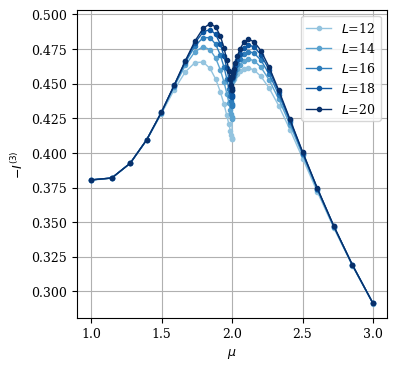

In [31]:
fig,ax=plt.subplots(figsize=(4,4))
color_list=iter(plt.cm.Blues(np.linspace(0.4,1,len(L_list))))
for L in L_list:
    ax.plot(mu_list,-torch.tensor(TMI_dict[L]),'.-',label=f'$L$={L}',color=next(color_list),lw=1)
ax.legend()
ax.set_xlabel(r'$\mu$')
ax.set_ylabel('$-I^{(3)}$')
ax.grid()

In [32]:
torch.save([mu_list,TMI_dict], 'TMI_dict.pickle')

In [20]:
def Chern(mu,L):
    gtn2=GTN2_torch(Lx=L,Ly=L,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=1,complex128=True,gpu=True)
    C_m=gtn2.covariance_matrix(mu=mu)
    gtn2.C_m=C_m
    return gtn2.chern_number_quick()


In [ ]:
Chern_dict={}
L_list=[12,14,16,18,20]
mu_list =np.linspace(-1,1,40)**3 + 2
for L in tqdm(L_list):
    Chern_dict[L]=[Chern(x,L) for x in mu_list]

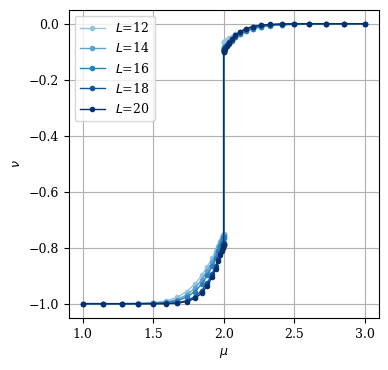

In [25]:
fig,ax=plt.subplots(figsize=(4,4))
color_list=iter(plt.cm.Blues(np.linspace(0.4,1,len(L_list))))
for L in L_list:
    ax.plot(mu_list,torch.tensor(Chern_dict[L]),'.-',label=f'$L$={L}',color=next(color_list),lw=1)
ax.legend()
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\nu$')
ax.grid()

In [33]:
torch.save([mu_list,Chern_dict], 'Chern_dict.pickle')

In [26]:
with open('Chern_dict.pickle', 'wb') as f:
    pickle.dump([mu_list,Chern_dict], f)

In [81]:
gtn2.get_C_m(C_f) 

tensor([[ 0., -1.,  0.,  0.],
        [ 1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.],
        [ 0.,  0., -1.,  0.]], dtype=torch.float64)

In [70]:
C_f

tensor([[1.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j]], dtype=torch.complex128)

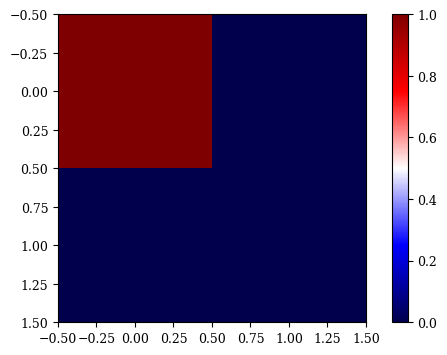

In [72]:
plt.imshow(torch.abs(C_f),cmap='seismic')
plt.colorbar()

In [49]:
IG =torch.eye(C_f.shape[0])-2*C_f

In [55]:
torch.abs(C_f @ C_f - C_f ).max()

tensor(6.6613e-16, dtype=torch.float64)

In [42]:
(val<0).float()

AttributeError: 'Tensor' object has no attribute 'float_'

In [43]:
torch.einsum("ij,j,jk",vec ,(val<0).float(),vec.T.conj())

tensor([[ 2.5439e-01+0.0000e+00j,  3.0528e-17+2.3376e-17j,
          1.1674e-01+4.0288e-18j,  ...,
         -8.3248e-03+5.3501e-03j,  5.8406e-02-1.7341e-17j,
         -2.9053e-02-2.9053e-02j],
        [ 3.0528e-17-2.3376e-17j,  7.4561e-01+0.0000e+00j,
          4.7705e-17+1.6648e-01j,  ...,
         -5.3972e-03+7.6328e-17j,  2.9053e-02-2.9053e-02j,
         -5.8406e-02+8.6736e-18j],
        [ 1.1674e-01-4.0288e-18j,  4.7705e-17-1.6648e-01j,
          2.5439e-01+0.0000e+00j,  ...,
         -2.8383e-03+2.5896e-03j,  5.3972e-03-8.1098e-17j,
         -8.3248e-03+5.3501e-03j],
        ...,
        [-8.3248e-03-5.3501e-03j, -5.3972e-03-7.6328e-17j,
         -2.8383e-03-2.5896e-03j,  ...,
          7.4561e-01+0.0000e+00j, -2.1684e-17+1.6648e-01j,
         -1.1674e-01-1.4095e-17j],
        [ 5.8406e-02+1.7341e-17j,  2.9053e-02+2.9053e-02j,
          5.3972e-03+8.1098e-17j,  ...,
         -2.1684e-17-1.6648e-01j,  2.5439e-01+0.0000e+00j,
         -1.9082e-17+1.3878e-17j],
        [-2.9053e-02+2

In [31]:
vec.shape

torch.Size([200, 200])

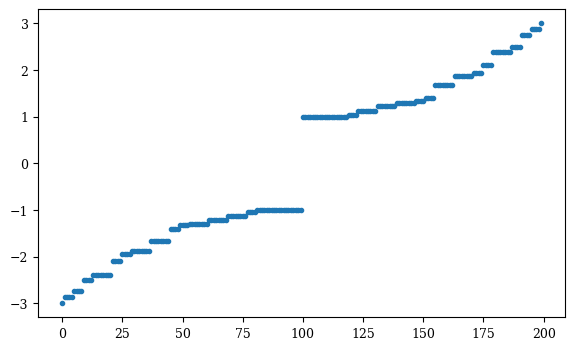

In [36]:
plt.plot(val,'.')

In [15]:
gtn2.dtype_complex

torch.complex128

In [18]:
torch.ones(10,dtype=gtn2.dtype_complex)

tensor([1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j],
       dtype=torch.complex128)

# Dense

In [9]:
gtn2=GTN2(Lx=20,Ly=20,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=2,sparse=False)

# op=kraus([0,1/np.sqrt(2),1/np.sqrt(2)])
# ix = np.arange(0,2).tolist()
# ix_bar = np.arange(2,gtn2.C_m.shape[0]).tolist()
op=(op_single_mode(((1,)*50,1)))
ix = np.arange(0,100).tolist()
ix_bar = np.arange(100,gtn2.C_m.shape[0]).tolist()

In [149]:
Gamma=gtn2.C_m.copy()

In [153]:
P_contraction_2(gtn2.C_m,op,ix,ix_bar,)

In [104]:
%timeit P_contraction_2(gtn2.C_m,op,ix,ix_bar,)

543 ms ± 847 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Reproduce using Pytorch

## C=0 -> C=1

In [215]:
gtn2=GTN2_torch(Lx=15,Ly=15,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=2,complex128=True,gpu=True)
mu_list=[1.,2,3]
gtn2.a_i={}
gtn2.b_i={}
gtn2.A_i={}
gtn2.B_i={}
for mu in mu_list:
    gtn2.a_i[mu],gtn2.b_i[mu] = amplitude(gtn2.nshell,tau=[0,1],geometry='square',lower=True,mu=mu,nkx=1000,nky=1000)
    gtn2.A_i[mu],gtn2.B_i[mu] = amplitude(gtn2.nshell,tau=[1,0],geometry='square',lower=False,mu=mu,nkx=1000,nky=1000)

Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


In [286]:
gtn2_fft=GTN2_torch(Lx=15,Ly=15,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=2,complex128=True,gpu=False)
mu_list=[1.,2,3]
tau_list = [(1,0),(0,1)]
gtn2_fft.a_i={}
gtn2_fft.b_i={}
gtn2_fft.A_i={}
gtn2_fft.B_i={}
for mu in mu_list:
    for tau in tau_list:
        gtn2_fft.a_i[mu,tau],gtn2_fft.b_i[mu,tau] = amplitude_fft_nshell(gtn2_fft.nshell,tau=tau,geometry='square',lower=True,mu=mu,nkx=500,nky=500)
        gtn2_fft.A_i[mu,tau],gtn2_fft.B_i[mu,tau] = amplitude_fft_nshell(gtn2_fft.nshell,tau=tau,geometry='square',lower=False,mu=mu,nkx=500,nky=500)

Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


In [8]:
gtn2_fft_gpu=GTN2_torch(Lx=15,Ly=15,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=2,complex128=True,gpu=True)
mu_list=[1.,2,3]
tau_list = [(1,0),(0,1)]

gtn2_fft_gpu.a_i={}
gtn2_fft_gpu.b_i={}
gtn2_fft_gpu.A_i={}
gtn2_fft_gpu.B_i={}
for mu in mu_list:
    for tau in tau_list:
        gtn2_fft_gpu.a_i[mu,tau],gtn2_fft_gpu.b_i[mu,tau] = amplitude_fft_nshell_gpu(gtn2_fft_gpu.nshell,gtn2_fft_gpu.device,tau=[0,1.],geometry='square',lower=True,mu=mu,nkx=5000,nky=5000)
        gtn2_fft_gpu.A_i[mu,tau],gtn2_fft_gpu.B_i[mu,tau] = amplitude_fft_nshell_gpu(gtn2_fft_gpu.nshell,gtn2_fft_gpu.device,tau=[1.,0],geometry='square',lower=False,mu=mu,nkx=5000,nky=5000)

Using cuda
GPU Model: NVIDIA GeForce RTX 3090


In [10]:
{key:np.round(val,6) for key,val in gtn2_fft_gpu.a_i[2,(1,0)].items()}

{(-2, -2): (0.006254+0.006254j),
 (-2, -1): (0.009356+0.012193j),
 (-2, 0): (-0+0.029734j),
 (-2, 1): (-0.009356+0.012193j),
 (-2, 2): (-0.006254+0.006254j),
 (-1, -2): (0.012193+0.009356j),
 (-1, -1): (0.027256+0.027256j),
 (-1, 0): (-0+0.123208j),
 (-1, 1): (-0.027256+0.027256j),
 (-1, 2): (-0.012193+0.009356j),
 (0, -2): (0.029734-0j),
 (0, -1): (0.123208-0j),
 (0, 0): (-0-0j),
 (0, 1): (-0.123208-0j),
 (0, 2): (-0.029734-0j),
 (1, -2): (0.012193-0.009356j),
 (1, -1): (0.027256-0.027256j),
 (1, 0): (-0-0.123208j),
 (1, 1): (-0.027256-0.027256j),
 (1, 2): (-0.012193-0.009356j),
 (2, -2): (0.006254-0.006254j),
 (2, -1): (0.009356-0.012193j),
 (2, 0): (-0-0.029734j),
 (2, 1): (-0.009356-0.012193j),
 (2, 2): (-0.006254-0.006254j)}

In [233]:
{key:np.round(val,6) for key,val in gtn2_fft.a_i[2].items()}

{(-2, -2): (0.006254+0.006254j),
 (-2, -1): (0.009356+0.012193j),
 (-2, 0): (-0+0.029734j),
 (-2, 1): (-0.009356+0.012193j),
 (-2, 2): (-0.006254+0.006254j),
 (-1, -2): (0.012193+0.009356j),
 (-1, -1): (0.027256+0.027256j),
 (-1, 0): (-0+0.123208j),
 (-1, 1): (-0.027256+0.027256j),
 (-1, 2): (-0.012193+0.009356j),
 (0, -2): (0.029734-0j),
 (0, -1): (0.123208-0j),
 (0, 0): (-0+0j),
 (0, 1): (-0.123208-0j),
 (0, 2): (-0.029734-0j),
 (1, -2): (0.012193-0.009356j),
 (1, -1): (0.027256-0.027256j),
 (1, 0): (-0-0.123208j),
 (1, 1): (-0.027256-0.027256j),
 (1, 2): (-0.012193-0.009356j),
 (2, -2): (0.006254-0.006254j),
 (2, -1): (0.009356-0.012193j),
 (2, 0): (-0-0.029734j),
 (2, 1): (-0.009356-0.012193j),
 (2, 2): (-0.006254-0.006254j)}

In [230]:
{key:np.round(val,6) for key,val in gtn2.a_i[2].items()}

{(-2, -2): (0.006254+0.006254j),
 (-2, -1): (0.009356+0.012193j),
 (-2, 0): 0.029734j,
 (-2, 1): (-0.009356+0.012193j),
 (-2, 2): (-0.006254+0.006254j),
 (-1, -2): (0.012193+0.009356j),
 (-1, -1): (0.027256+0.027256j),
 (-1, 0): 0.123208j,
 (-1, 1): (-0.027256+0.027256j),
 (-1, 2): (-0.012193+0.009356j),
 (0, -2): (0.029734+0j),
 (0, -1): (0.123208+0j),
 (0, 0): 0j,
 (0, 1): (-0.123208+0j),
 (0, 2): (-0.029734+0j),
 (1, -2): (0.012193-0.009356j),
 (1, -1): (0.027256-0.027256j),
 (1, 0): (-0-0.123208j),
 (1, 1): (-0.027256-0.027256j),
 (1, 2): (-0.012193-0.009356j),
 (2, -2): (0.006254-0.006254j),
 (2, -1): (0.009356-0.012193j),
 (2, 0): -0.029734j,
 (2, 1): (-0.009356-0.012193j),
 (2, 2): (-0.006254-0.006254j)}

In [119]:
z=np.linspace(-5,5,101)

In [122]:
kx=np.linspace(-np.pi,np.pi,101)
n=2
np.trapz(z* np.exp(-1j* kx*n),kx)/(2*np.pi)

(4.417437057588218e-17+0.7947272421932651j)

In [117]:
z=np.linspace(0,10,1001)
np.fft.fft(z)/z.shape[0]

array([ 5.e+00+0.j        , -5.e-03+1.59313575j, -5.e-03+0.79656003j, ...,
       -5.e-03-0.5310313j , -5.e-03-0.79656003j, -5.e-03-1.59313575j])

In [ ]:
?np.linspace

In [ ]:
?np.fft.fft2

In [280]:
def check_equal(a_i,b_i):
    for key in a_i:
        err = a_i[key]-b_i[key]
        if np.abs(err)>1e-8:
            print(key,f'{a_i[key]:e}',f'{b_i[key]:e}',f'{np.abs(err):e}')

In [258]:
check_equal(gtn2.a_i[2],gtn2_fft.a_i[2])
check_equal(gtn2.b_i[2],gtn2_fft.b_i[2])
check_equal(gtn2.A_i[2],gtn2_fft.A_i[2])
check_equal(gtn2.B_i[2],gtn2_fft.B_i[2])

In [289]:
check_equal(gtn2_fft.a_i[2],gtn2_fft_gpu.a_i[2])
check_equal(gtn2_fft.b_i[2],gtn2_fft_gpu.b_i[2])
check_equal(gtn2_fft.A_i[2],gtn2_fft_gpu.A_i[2])
check_equal(gtn2_fft.B_i[2],gtn2_fft_gpu.B_i[2])

(-1, 0) 1.848872e-17+1.232078e-01j -1.126794e-08+1.232078e-01j 1.857175e-08
(0, -1) 1.232078e-01+1.422571e-17j 1.232078e-01-1.051029e-08j 1.812207e-08
(0, 1) -1.232078e-01+1.822959e-17j -1.232078e-01-1.121589e-08j 1.854021e-08
(1, -1) 2.725627e-02-2.725627e-02j 2.725627e-02-2.725628e-02j 1.189690e-08
(1, 0) 1.535882e-17-1.232078e-01j -1.170748e-08-1.232078e-01j 1.884167e-08
(0, 0) 9.067590e-01-0.000000e+00j 9.067590e-01+0.000000e+00j 1.078078e-08
(1, 0) -4.116169e-02-4.753026e-18j -4.116170e-02+3.845232e-09j 1.038600e-08
(0, 0) 9.067590e-01-0.000000e+00j 9.067590e-01+0.000000e+00j 1.078078e-08
(1, 0) -4.116169e-02-4.753026e-18j -4.116170e-02+3.845232e-09j 1.038600e-08
(-1, 0) -1.848830e-17-1.232078e-01j 1.126477e-08-1.232078e-01j 1.856983e-08
(0, -1) 1.232078e-01+1.440180e-17j 1.232078e-01-1.051024e-08j 1.812204e-08
(0, 1) -1.232078e-01+1.822666e-17j -1.232078e-01-1.121578e-08j 1.854015e-08
(1, -1) 2.725627e-02+2.725627e-02j 2.725628e-02+2.725627e-02j 1.189690e-08
(1, 0) -1.757317e-17+

In [177]:
for key in gtn2_fft.a_i[mu]:
    # print(key,f'{gtn2_fft.a_i[mu][key]:e}',f'{gtn2.a_i[mu][-key[0],-key[1]]:e}')
    # print(key,f'{gtn2_fft.a_i[mu][key]-gtn2.a_i[mu][-key[0],-key[1]]:e}')
    err = gtn2_fft.a_i[mu][key]-gtn2.a_i[mu][key]
    if np.abs(err)>1e-10:
        print(key,f'{gtn2_fft.a_i[mu][key]:e}',f'{gtn2.a_i[mu][key]:e}',f'{err:e}')
    # print(key,f'{gtn2_fft.a_i[mu][key]-gtn2.a_i[mu][key]:e}')

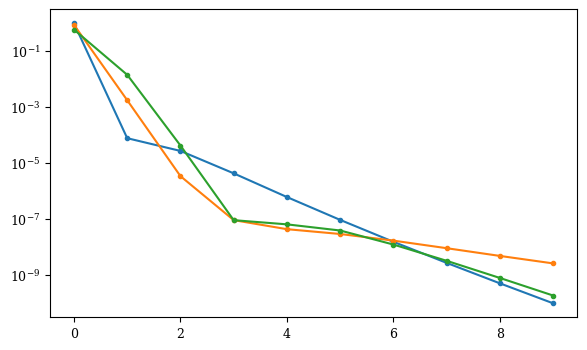

In [202]:
plt.plot([np.abs(gtn2.b_i[3][0,i])**2 for i in range(10)],'.-')
plt.plot([np.abs(gtn2.b_i[2][0,i])**2 for i in range(10)],'.-')
plt.plot([np.abs(gtn2.b_i[1][0,i])**2 for i in range(10)],'.-')
plt.yscale('log')
# plt.xscale('log')


In [ ]:
gtn2.b_i[3][0,1]

(-0.0037472996387057115-7.674469663492742e-05j)

In [181]:
gtn2.b_i[1][0,1]

(-0.11674753712560951+3.5339496460705695e-18j)

In [182]:
b_i[1][0,1]

(0.11674753712560951+6.2844565296051505e-18j)

In [ ]:
plt.plot()

In [14]:
overlap_lower_list =[]
overlap_upper_list =[]
mu_list = np.arange(1,3,0.1)
for mu in tqdm(mu_list):
    a_i,b_i=amplitude_fft(tau=[1,0],lower=True,mu=mu,nkx=501,nky=501,)
    A_i,B_i=amplitude_fft(tau=[0,1],lower=False,mu=mu,nkx=501,nky=501,)
    a_i_shift = np.roll(a_i,1,axis=0)
    b_i_shift = np.roll(b_i,1,axis=0)
    A_i_shift = np.roll(A_i,1,axis=0)
    B_i_shift = np.roll(B_i,1,axis=0)

    overlap_lower = (a_i_shift.T.conj() * a_i).sum() + (b_i_shift.T.conj() * b_i).sum()
    overlap_upper = (A_i_shift.T.conj() * A_i).sum() + (B_i_shift.T.conj() * B_i).sum()
    overlap_lower_list.append(overlap_lower)
    overlap_upper_list.append(overlap_upper)


  0%|                                                                              | 0/20 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.41it/s]


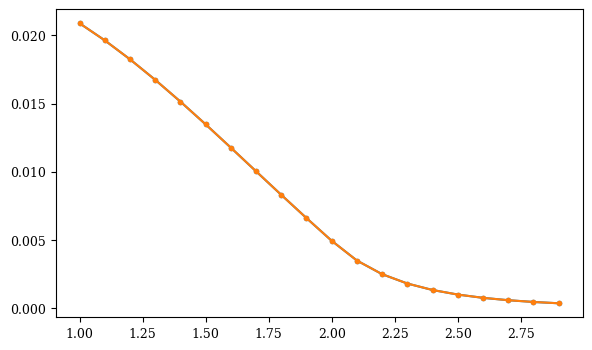

In [13]:
plt.plot(mu_list, np.abs(overlap_lower_list)**2,'.-')
plt.plot(mu_list, np.abs(overlap_upper_list)**2,'.-')

# plt.xlabel('$\mu$')
# plt.ylabel(r'$ |\langle R_{i+1,j} | R_{i,j} \rangle|^2 $')

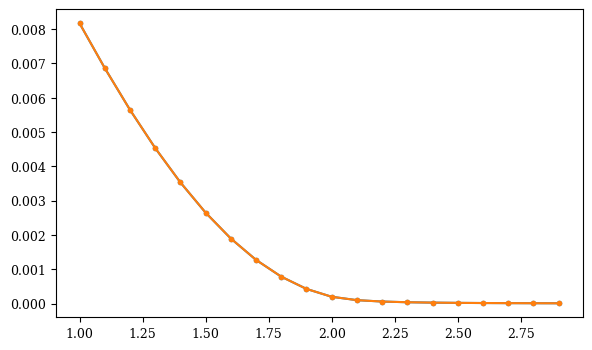

In [15]:
plt.plot(mu_list, np.abs(overlap_lower_list)**2,'.-')
plt.plot(mu_list, np.abs(overlap_upper_list)**2,'.-')

# plt.xlabel('$\mu$')
# plt.ylabel(r'$ |\langle R_{i+1,j} | R_{i,j} \rangle|^2 $')

Text(0, 0.5, '$j$')

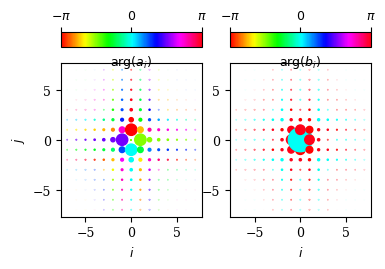

In [ ]:
fig,ax=plt.subplots(1,2,figsize=(4,2))
mu=1.
i_list,j_list,a_list=convert_to_list(gtn2.a_i[mu])
im=ax[0].scatter(i_list,j_list,s=400*np.abs(a_list),c=np.angle(a_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

i_list,j_list,b_list=convert_to_list(gtn2.b_i[mu])
im=ax[1].scatter(i_list,j_list,s=400*np.abs(b_list),c=np.angle(b_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

place_color_bar_top(im,ax[0],r'$\arg(a_i)$')
place_color_bar_top(im,ax[1],r'$\arg(b_i)$')

[ax.set_xlabel('$i$') for ax in ax]
ax[0].set_ylabel('$j$')

# fig.savefig('mu1_nshell4.pdf',bbox_inches='tight')



In [131]:
a_i={}
b_i={}
A_i={}
B_i={}
# -1,1,2,2.2,
for mu in [1,2,3,4,5,10]:
    a_i[mu],b_i[mu]=amplitude_fft(tau=[1,1],lower=True,mu=mu,nkx=2001,nky=2001,)
    A_i[mu],B_i[mu]=amplitude_fft(tau=[1,-1],lower=True,mu=mu,nkx=2001,nky=2001,)

(1e-15, 2)

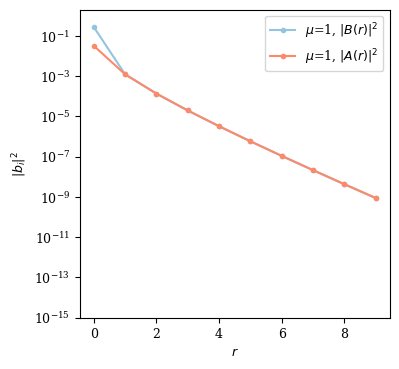

In [134]:
fig,ax=plt.subplots(figsize=(4,4))
color_b=iter(plt.cm.Blues(np.linspace(0.4,1,5)))
color_r=iter(plt.cm.Reds(np.linspace(0.4,1,5)))
for mu in [1,]:
    ax.plot(np.arange(0,10),np.abs(b_i[mu][0,0:10])**2,'.-',label=fr'$\mu$={mu}, $|B(r)|^2$',color=next(color_b))
for mu in [1,]:
    ax.plot(np.arange(0,10),np.abs(a_i[mu][0,:10])**2,'.-',label=fr'$\mu$={mu}, $|A(r)|^2$',color=next(color_r))


# ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
# ax.plot([np.abs(gtn2.b_i[1][0,i])**2 for i in range(10)],'.-')
ax.set_xlabel('$r$')
ax.set_ylabel(r'$|b_i|^2$')
ax.set_ylim(1e-15,2)


(1e-15, 2)

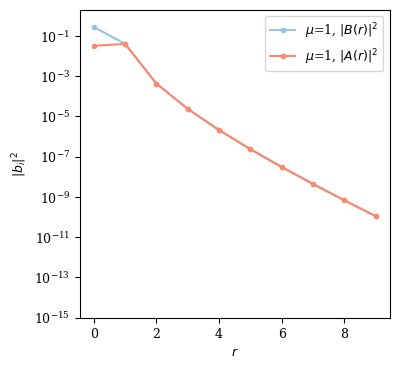

In [135]:
fig,ax=plt.subplots(figsize=(4,4))
color_b=iter(plt.cm.Blues(np.linspace(0.4,1,5)))
color_r=iter(plt.cm.Reds(np.linspace(0.4,1,5)))
for mu in [1,]:
    ax.plot(np.arange(0,10),np.abs(B_i[mu][0,:10])**2,'.-',label=fr'$\mu$={mu}, $|B(r)|^2$',color=next(color_b))
for mu in [1,]:
    ax.plot(np.arange(0,10),np.abs(A_i[mu][0,:10])**2,'.-',label=fr'$\mu$={mu}, $|A(r)|^2$',color=next(color_r))


# ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
# ax.plot([np.abs(gtn2.b_i[1][0,i])**2 for i in range(10)],'.-')
ax.set_xlabel('$r$')
ax.set_ylabel(r'$|b_i|^2$')
ax.set_ylim(1e-15,2)



In [133]:
np.linspace(-np.pi,np.pi,10,endpoint=False)

array([-3.14159265, -2.51327412, -1.88495559, -1.25663706, -0.62831853,
        0.        ,  0.62831853,  1.25663706,  1.88495559,  2.51327412])

In [117]:
why does it show a kink? why not smoothly exponential?

Object `exponential` not found.


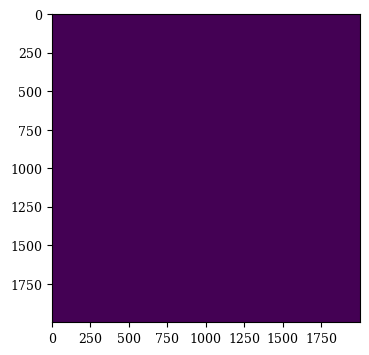

In [75]:
plt.imshow(np.abs(b_i)**2)

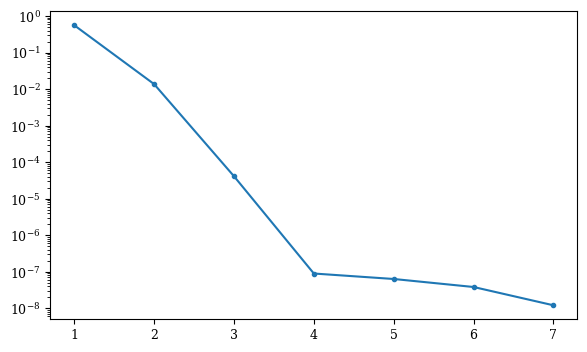

In [63]:
plt.plot(np.arange(7)+1,[np.abs(gtn2.A_i[1][0,x])**2 for x in range(7)],'.-')
# plt.xscale('log')
plt.yscale('log')

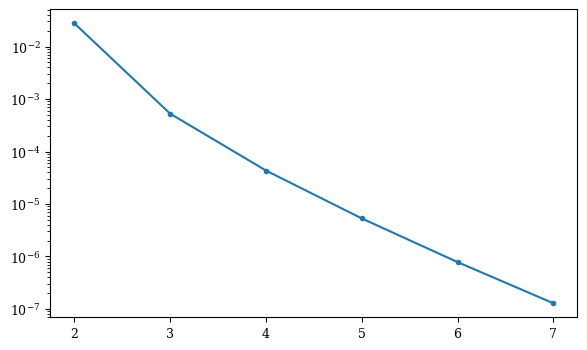

In [65]:
plt.plot(np.arange(1,7)+1,[np.abs(gtn2.B_i[1][0,x])**2 for x in range(1,7)],'.-')
# plt.xscale('log')
plt.yscale('log')

Text(0, 0.5, '$j$')

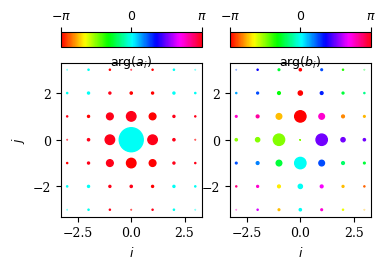

In [78]:
fig,ax=plt.subplots(1,2,figsize=(4,2))
mu=1
i_list,j_list,a_list=convert_to_list(gtn2.A_i[mu])
im=ax[0].scatter(i_list,j_list,s=400*np.abs(a_list),c=np.angle(a_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

i_list,j_list,b_list=convert_to_list(gtn2.B_i[mu])
im=ax[1].scatter(i_list,j_list,s=400*np.abs(b_list),c=np.angle(b_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

place_color_bar_top(im,ax[0],r'$\arg(a_i)$')
place_color_bar_top(im,ax[1],r'$\arg(b_i)$')

[ax.set_xlabel('$i$') for ax in ax]
ax[0].set_ylabel('$j$')

# fig.savefig('mu1_nshell4.pdf',bbox_inches='tight')



In [86]:
nu_list =[]
TMI_list=[]
A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()


In [87]:
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2.device,dtype=gtn2.dtype_float))
TMI_list.append(gtn2.tripartite_mutual_information())
for i in tqdm(range(gtn2.Lx)):
    measure_feedback_layer(gtn2)
    randomize(gtn2,measure=True)
    nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2.device,dtype=gtn2.dtype_float))
    TMI_list.append(gtn2.tripartite_mutual_information())
nu_list=torch.tensor(nu_list)
TMI_list=torch.tensor(TMI_list)

Chern number done in 0.0032


  7%|████████▏                                                                                                                  | 1/15 [00:04<01:02,  4.44s/it]

Chern number done in 0.0024


 13%|████████████████▍                                                                                                          | 2/15 [00:08<00:55,  4.23s/it]

Chern number done in 0.0025


 20%|████████████████████████▌                                                                                                  | 3/15 [00:12<00:49,  4.10s/it]

Chern number done in 0.0023


 27%|████████████████████████████████▊                                                                                          | 4/15 [00:16<00:44,  4.01s/it]

Chern number done in 0.0024


 33%|█████████████████████████████████████████                                                                                  | 5/15 [00:20<00:39,  3.97s/it]

Chern number done in 0.0024


 40%|█████████████████████████████████████████████████▏                                                                         | 6/15 [00:24<00:35,  3.94s/it]

Chern number done in 0.0025


 47%|█████████████████████████████████████████████████████████▍                                                                 | 7/15 [00:28<00:31,  3.94s/it]

Chern number done in 0.0024


 53%|█████████████████████████████████████████████████████████████████▌                                                         | 8/15 [00:32<00:27,  3.94s/it]

Chern number done in 0.0024


 60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 9/15 [00:35<00:23,  3.90s/it]

Chern number done in 0.0023


 67%|█████████████████████████████████████████████████████████████████████████████████▎                                        | 10/15 [00:39<00:19,  3.88s/it]

Chern number done in 0.0025


 73%|█████████████████████████████████████████████████████████████████████████████████████████▍                                | 11/15 [00:43<00:15,  3.87s/it]

Chern number done in 0.0024


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 12/15 [00:47<00:11,  3.86s/it]

Chern number done in 0.0023


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 13/15 [00:51<00:07,  3.87s/it]

Chern number done in 0.0023


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 14/15 [00:55<00:03,  3.89s/it]

Chern number done in 0.0024


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:59<00:00,  3.94s/it]

Chern number done in 0.0035


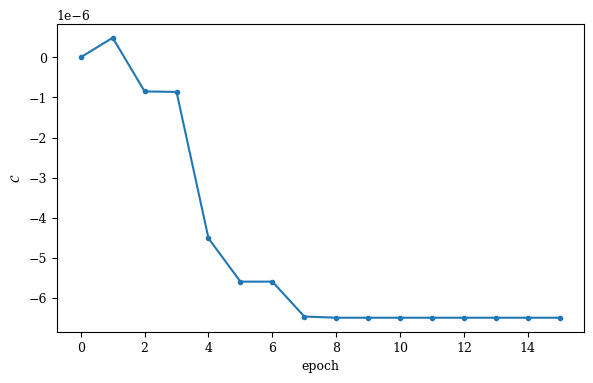

In [88]:
plot_chern(nu_list)

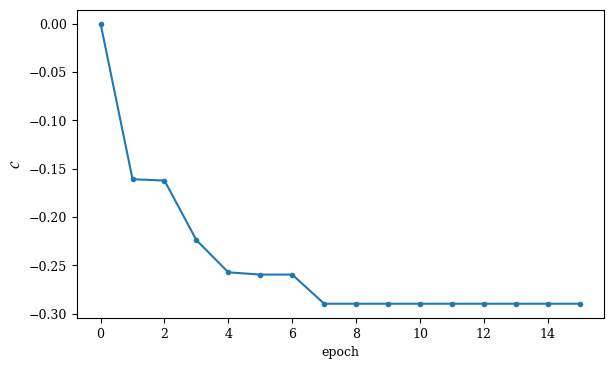

In [89]:
plot_chern(TMI_list)

In [90]:
gtn2.tripartite_mutual_information()

tensor(-0.2898, device='cuda:0', dtype=torch.float64)

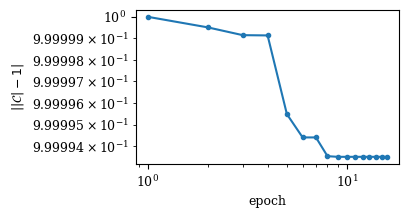

In [93]:
fig,ax=plt.subplots(figsize=(3.4,2))
plot_chern(nu_list,log=True,C=1,ax=ax)

## C=1 -> 0

In [34]:
gtn2=GTN2_torch(Lx=15,Ly=15,history=False,random_init=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=2)

mu_list=[2.1]
gtn2.a_i={}
gtn2.b_i={}
gtn2.A_i={}
gtn2.B_i={}
for mu in mu_list:
    gtn2.a_i[mu],gtn2.b_i[mu] = amplitude(gtn2.nshell,tau=[0,1],geometry='square',lower=True,mu=mu)
    gtn2.A_i[mu],gtn2.B_i[mu] = amplitude(gtn2.nshell,tau=[1,0],geometry='square',lower=False,mu=mu)

Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


In [ ]:
with open('C_m_L15.pickle','rb') as f:
    C_m=pickle.load(f)
gtn2.C_m[:2*gtn2.L,:2*gtn2.L]=C_m
gtn2.C_m_history[0]=gtn2.C_m.copy()

## C=0 -> C=2

In [35]:
gtn2=GTN2_torch(Lx=15,Ly=15,history=False,random_init=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=2)
mu_list=[1]
gtn2.a_i={}
gtn2.b_i={}
gtn2.A_i={}
gtn2.B_i={}
for mu in mu_list:
    gtn2.a_i[mu],gtn2.b_i[mu] = amplitude(gtn2.nshell,tau=[0,1],geometry='square',lower=True,mu=mu,C=2)
    gtn2.A_i[mu],gtn2.B_i[mu] = amplitude(gtn2.nshell,tau=[1,0],geometry='square',lower=False,mu=mu,C=2)

Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


Text(0, 0.5, '$j$')

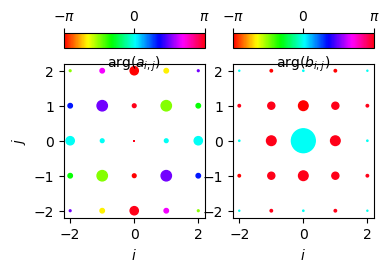

In [36]:
fig,ax=plt.subplots(1,2,figsize=(4,2))
mu=1
i_list,j_list,a_list=convert_to_list(gtn2.a_i[mu])
im=ax[0].scatter(i_list,j_list,s=400*np.abs(a_list),c=np.angle(a_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

i_list,j_list,b_list=convert_to_list(gtn2.b_i[mu])
im=ax[1].scatter(i_list,j_list,s=400*np.abs(b_list),c=np.angle(b_list),vmin=-np.pi,vmax=np.pi,cmap='hsv')

place_color_bar_top(im,ax[0],r'$\arg(a_{i,j})$')
place_color_bar_top(im,ax[1],r'$\arg(b_{i,j})$')

[ax.set_xlabel('$i$') for ax in ax]
ax[0].set_ylabel('$j$')

# fig.savefig('mu1_nshell4_C2.pdf',bbox_inches='tight')



In [37]:
nu_list =[]
A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

In [39]:
nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2.device,dtype=gtn2.dtype_float))
for i in tqdm(range(gtn2.Lx)):
    measure_feedback_layer(gtn2)
    randomize(gtn2,measure=True)
    nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2.device,dtype=gtn2.dtype_float))
nu_list=torch.tensor(nu_list)

Chern number done in 0.0080


  0%|                                                                                                                                                    | 0/15 [00:00<?, ?it/s]

  7%|█████████▎                                                                                                                                  | 1/15 [00:03<00:45,  3.24s/it]

Chern number done in 0.0009


 13%|██████████████████▋                                                                                                                         | 2/15 [00:06<00:39,  3.05s/it]

Chern number done in 0.0009


 20%|████████████████████████████                                                                                                                | 3/15 [00:09<00:35,  2.97s/it]

Chern number done in 0.0009


 27%|█████████████████████████████████████▎                                                                                                      | 4/15 [00:11<00:32,  2.92s/it]

Chern number done in 0.0009


 33%|██████████████████████████████████████████████▋                                                                                             | 5/15 [00:14<00:28,  2.86s/it]

Chern number done in 0.0009


 40%|████████████████████████████████████████████████████████                                                                                    | 6/15 [00:17<00:25,  2.82s/it]

Chern number done in 0.0011


 47%|█████████████████████████████████████████████████████████████████▎                                                                          | 7/15 [00:20<00:22,  2.79s/it]

Chern number done in 0.0009


 53%|██████████████████████████████████████████████████████████████████████████▋                                                                 | 8/15 [00:22<00:19,  2.80s/it]

Chern number done in 0.0009


 60%|████████████████████████████████████████████████████████████████████████████████████                                                        | 9/15 [00:25<00:16,  2.79s/it]

Chern number done in 0.0009


 67%|████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 10/15 [00:28<00:13,  2.80s/it]

Chern number done in 0.0009


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 11/15 [00:31<00:11,  2.79s/it]

Chern number done in 0.0009


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 12/15 [00:34<00:08,  2.78s/it]

Chern number done in 0.0009


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 13/15 [00:36<00:05,  2.77s/it]

Chern number done in 0.0009


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 14/15 [00:39<00:02,  2.78s/it]

Chern number done in 0.0009


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:42<00:00,  2.82s/it]

Chern number done in 0.0009


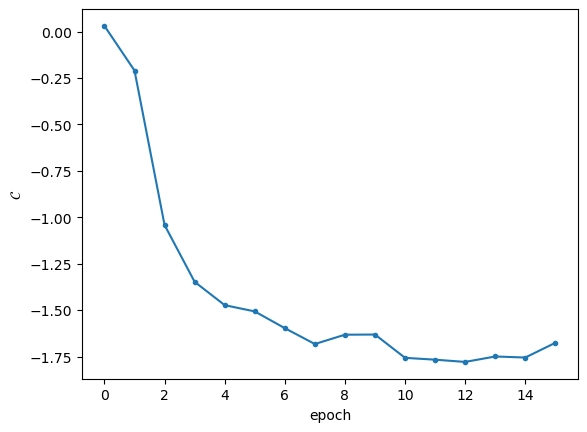

In [40]:
plot_chern(nu_list)

In [48]:
# def visualize(gtn2,A_idx_0,B_idx_0,C_idx_0):
#     A_de_idx=gtn2.delinearize_idx(A_idx_0.cpu())
#     B_de_idx=gtn2.delinearize_idx(B_idx_0.cpu())
#     C_de_idx=gtn2.delinearize_idx(C_idx_0.cpu())
#     fig,ax=plt.subplots(figsize=(3.4,3.4))
#     ax.scatter(A_de_idx[2]+0.1*A_de_idx[4],A_de_idx[3]+0.1*A_de_idx[4],color='b')
#     ax.scatter(B_de_idx[2]+0.1*B_de_idx[4],B_de_idx[3]+0.1*B_de_idx[4],color='r')
#     ax.scatter(C_de_idx[2]+0.1*C_de_idx[4],C_de_idx[3]+0.1*C_de_idx[4],color='pink')
#     ax.set_xlim(0,gtn2.Lx)
#     ax.set_ylim(0,gtn2.Ly)
#     ax.set_ylabel('$i$')
#     ax.set_xlabel('$j$')
#     return fig,ax

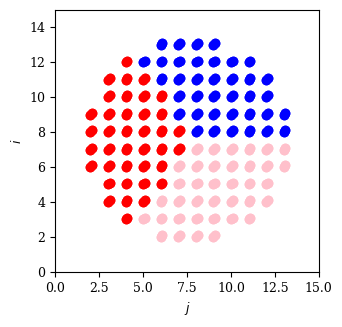

In [49]:
# fig,ax=visualize(gtn2_torch,*gtn2_torch.generate_tripartite_circle())
# fig.savefig('../Rp_SPTD/Fig/nu.pdf',bbox_inches='tight')

# Torch

In [13]:
gtn2_torch=GTN2_torch(Lx=15,Ly=15,history=False,random_init=False,random_U1=True,bcx=1,bcy=1,seed=2,orbit=2,nshell=4,layer=2,replica=1,complex128=True,err=1e-8,)

mu_list=]
gtn2_torch.a_i={}
gtn2_torch.b_i={}
gtn2_torch.A_i={}
gtn2_torch.B_i={}
for mu in mu_list:
    gtn2_torch.a_i[mu],gtn2_torch.b_i[mu] = amplitude(gtn2_torch.nshell,tau=[0,1],geometry='square',lower=True,mu=mu,C=1)
    gtn2_torch.A_i[mu],gtn2_torch.B_i[mu] = amplitude(gtn2_torch.nshell,tau=[1,0],geometry='square',lower=False,mu=mu,C=1)

Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


In [12]:
gtn2_torch.C_m.element_size() * gtn2_torch.C_m.numel() / 1024**3

0.024139881134033203

In [253]:
nu_list =[]
nu_list.append(gtn2_torch.chern_number_quick(selfaverage=True))
TMI_list = []
TMI_list.append(gtn2_torch.tripartite_mutual_information(selfaverage=True))

# C_m_list=[]

In [254]:
for i in tqdm(range(2*gtn2_torch.Lx)):
    # print(i)
    measure_feedback_layer(gtn2_torch)
    randomize(gtn2_torch,measure=True)
    randomize_inter(gtn2_torch, scale=1)
    
    # C_m_list.append(gtn2_torch.C_m.clone())
    nu_list.append( gtn2_torch.chern_number_quick(selfaverage=True))
    TMI_list.append(gtn2_torch.tripartite_mutual_information(selfaverage=True))




100%|██████████████████████████████████████████████████████| 22/22 [04:17<00:00, 11.73s/it]


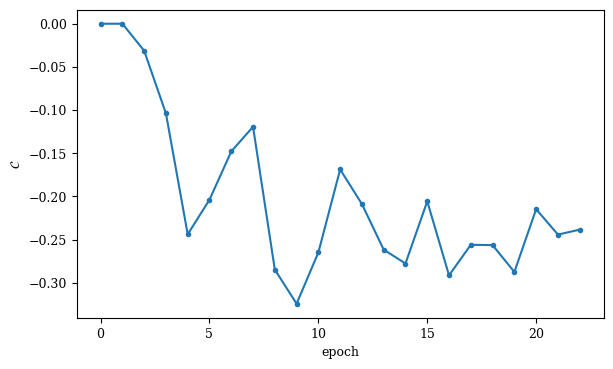

In [255]:
plot_chern(nu_list,)

In [19]:
nu =( gtn2_torch.chern_number_quick(selfaverage=True))
TMI = (gtn2_torch.tripartite_mutual_information(selfaverage=True))

In [79]:
nu

tensor(-0.8161, dtype=torch.float64)

In [80]:
TMI

tensor(-0.2880, dtype=torch.float64)

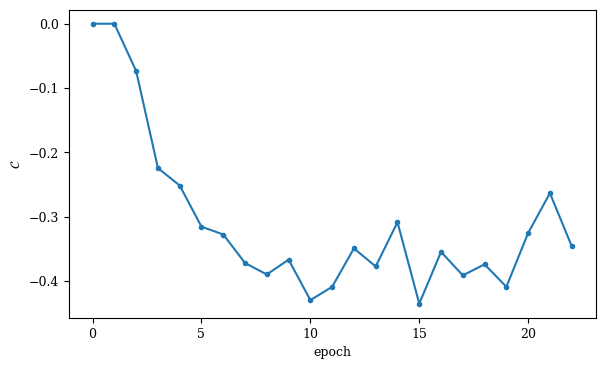

In [256]:
plot_chern(TMI_list)

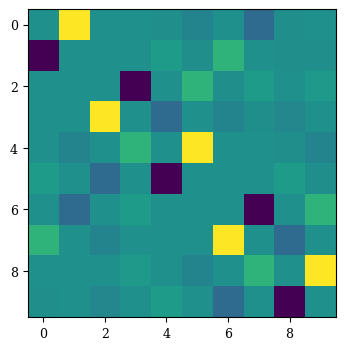

In [232]:
plt.imshow(gtn2_torch.C_m.cpu().numpy()[gtn2_torch.L*0:gtn2_torch.L*0+10,gtn2_torch.L*0:gtn2_torch.L*0+10])

In [213]:
# [torch.abs(C_m_list[i]-C_m_list[i-1])[:gtn2_torch.L*2,:gtn2_torch.L*2].sum() for i in range(1,len(C_m_list))]
[torch.abs(C_m_list[i]-C_m_list[i-1])[:10,:10].sum() for i in range(1,len(C_m_list))]

[]

In [127]:
%lprun -f gtn2_torch.von_Neumann_entropy_m gtn2_torch.von_Neumann_entropy_m(torch.arange(gtn2_torch.L),fermion_idx=False)

Timer unit: 1e-09 s

Total time: 0.025361 s
File: /scratch/hp636/GTN/GTN2_torch.py
Function: von_Neumann_entropy_m at line 365

Line #      Hits         Time  Per Hit   % Time  Line Contents
   365                                               def von_Neumann_entropy_m(self,subregion,Gamma=None,fermion_idx=True,verbose=False):
   366         1       3230.0   3230.0      0.0          st=time.time()
   367         1    2013328.0    2e+06      7.9          c_A=self.c_subregion_m(subregion,Gamma,fermion_idx=fermion_idx)
   368         1   22929631.0    2e+07     90.4          val=torch.linalg.eigvalsh(1j*c_A)
   369                                                   # val=torch.linalg.svdvals(c_A)
   370         1      75314.0  75314.0      0.3          val=(1-val)/2  
   371         1     160085.0 160085.0      0.6          val = val[(val>0) & (val<1)]
   372         1        737.0    737.0      0.0          if verbose:
   373                                                       print('en

In [126]:
%lprun -f gtn2_torch.von_Neumann_entropy_m gtn2_torch.von_Neumann_entropy_m(torch.arange(gtn2_torch.L),fermion_idx=False)

Timer unit: 1e-09 s

Total time: 1.11707 s
File: /scratch/hp636/GTN/GTN2_torch.py
Function: von_Neumann_entropy_m at line 365

Line #      Hits         Time  Per Hit   % Time  Line Contents
   365                                               def von_Neumann_entropy_m(self,subregion,Gamma=None,fermion_idx=True,verbose=False):
   366         1       3655.0   3655.0      0.0          st=time.time()
   367         1    5559293.0    6e+06      0.5          c_A=self.c_subregion_m(subregion,Gamma,fermion_idx=fermion_idx)
   368                                                   # val=torch.linalg.eigvalsh(1j*c_A)
   369         1 1111076041.0    1e+09     99.5          val=torch.linalg.svdvals(c_A)
   370         1      93054.0  93054.0      0.0          val=(1-val)/2  
   371         1     168987.0 168987.0      0.0          val = val[(val>0) & (val<1)]
   372         1       1112.0   1112.0      0.0          if verbose:
   373                                                       print('ent

In [91]:
%timeit gtn2_torch.tripartite_mutual_information(shift=(1,1))

228 ms ± 38.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit gtn2_torch.tripartite_mutual_information(shift=(1,1))

In [82]:
%timeit gtn2_torch.tripartite_mutual_information()

301 ms ± 44.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
gtn2_torch.tripartite_mutual_information(shift=(7,7))

tensor(-0.3855, device='cuda:0', dtype=torch.float64)

In [102]:
gtn2_torch.tripartite_mutual_information(shift=(0,1))

tensor(-0.4474, device='cuda:0', dtype=torch.float64)

In [128]:
zz=gtn2_torch.tripartite_mutual_information(selfaverage=True)

In [129]:
zz

tensor(-0.4006, dtype=torch.float64)

In [105]:
torch.tensor(zz).mean()

tensor(-0.4006, dtype=torch.float64)

In [112]:
zz=gtn2_torch.von_Neumann_entropy_m(torch.arange(10),fermion_idx=False)

In [113]:
zz

tensor([[-2.1789e-17,  5.1996e-01, -5.6515e-03, -2.2423e-03, -4.1820e-04,
         -2.0113e-01, -2.4309e-03, -3.3372e-01, -4.9286e-03,  2.2865e-02],
        [-5.1996e-01, -4.2182e-17,  2.2423e-03, -5.6515e-03,  2.0113e-01,
         -4.1820e-04,  3.3372e-01, -2.4309e-03, -2.2865e-02, -4.9286e-03],
        [ 5.6515e-03, -2.2423e-03, -9.0235e-17, -4.3569e-01,  9.8644e-03,
          2.9585e-01,  5.0177e-16,  2.7115e-01,  1.3762e-02, -3.7798e-03],
        [ 2.2423e-03,  5.6515e-03,  4.3569e-01, -3.2353e-17, -2.9585e-01,
          9.8644e-03, -2.7115e-01,  5.6389e-16,  3.7798e-03,  1.3762e-02],
        [ 4.1820e-04, -2.0113e-01, -9.8644e-03,  2.9585e-01,  6.0139e-17,
          5.5523e-01, -4.9575e-03, -2.8437e-02, -9.7444e-03, -1.5430e-01],
        [ 2.0113e-01,  4.1820e-04, -2.9585e-01, -9.8644e-03, -5.5523e-01,
         -4.2379e-17,  2.8437e-02, -4.9575e-03,  1.5430e-01, -9.7444e-03],
        [ 2.4309e-03, -3.3372e-01, -4.9375e-16,  2.7115e-01,  4.9575e-03,
         -2.8437e-02, -5.1526e-1

In [115]:
v1=torch.linalg.eigvalsh(1j*zz)

In [116]:
v1

tensor([-0.8593, -0.8401, -0.7194, -0.3596, -0.3178,  0.3178,  0.3596,  0.7194,
         0.8401,  0.8593], device='cuda:0', dtype=torch.float64)

In [120]:
v2=torch.linalg.svdvals(zz)

In [121]:
v2

tensor([0.8593, 0.8593, 0.8401, 0.8401, 0.7194, 0.7194, 0.3596, 0.3596, 0.3178,
        0.3178], device='cuda:0', dtype=torch.float64)

In [194]:
ilist=np.arange(0,gtn2_torch.Lx)
jlist=np.arange(0,gtn2_torch.Ly)
subregion_m = torch.hstack((
    torch.from_numpy(gtn2_torch.linearize_idx_span(ilist = ilist,jlist=jlist,layer=0)).cuda(),
    torch.from_numpy(gtn2_torch.linearize_idx_span(ilist = ilist,jlist=jlist,layer=1)).cuda())
)

EC=gtn2_torch.entanglement_contour(subregion_m,fermion_idx=False,Gamma=gtn2_torch.C_m)
EC_grid=EC.reshape((2,ilist.shape[0],jlist.shape[0],2,2)).sum(axis=(-1,-2)).cpu().numpy()

(<matplotlib.image.AxesImage at 0x7fd83a9035e0>,
 <matplotlib.collections.PathCollection at 0x7fd83a9d93c0>)

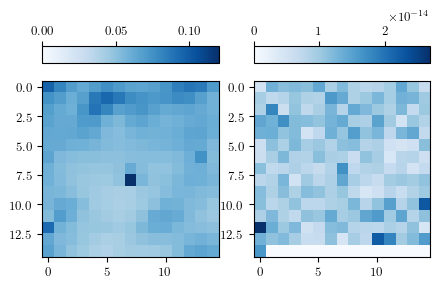

In [208]:
fig,ax=plt.subplots(1,2,figsize=(5,2.5))
plot_EC(EC_grid,ax=ax,vmax=None)

In [196]:
C_r=gtn2_torch.local_Chern_marker(gtn2_torch.C_m,)

(<matplotlib.image.AxesImage at 0x7fd8421a5a80>,
 <matplotlib.collections.PathCollection at 0x7fd83efc1ab0>)

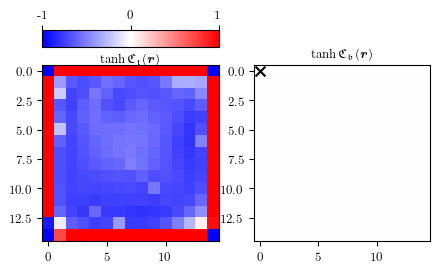

In [197]:
fig,ax=plt.subplots(1,2,figsize=(5,2.5))
plot_C_r(C_r.cpu()[0],ax=ax,bottomcb=False,label_pos=[None,(0,0)])

# DW

In [105]:
def measure_feedback_layer_dw_line(gtn2,overlap,geometry,truncate=False):
    ilist = range(gtn2.Lx)
    jlist = range(gtn2.Ly)
    ij_list = [(i,j) for i in (ilist) for j in (jlist)]
    margin=0 if overlap else gtn2.nshell
    inner_list = range(gtn2.Lx//5+margin,gtn2.Lx//5*4-margin)
    outer_list = range(gtn2.Lx//5-margin,gtn2.Lx//5*4+margin)
    if geometry == 'square':
        inner_region=set([(i,j) for i in inner_list for j in inner_list])
        outer_region=set([(i,j) for i in ilist for j in jlist if i not in outer_list or j not in outer_list])
    elif geometry == 'strip':
        inner_region=set([(i,j) for i in inner_list for j in jlist])
        outer_region=set([(i,j) for i in ilist for j in jlist if i not in outer_list])
    region_inner=inner_region if truncate else None
    region_outer=outer_region if truncate else None
    # for i,j in tqdm(ij_list,desc='measure with feedback'):
    for i,j in ij_list:
        if (i,j) in inner_region:
            gtn2.measure_feedback(ij = [i,j],mu=1,region=region_inner,tau=(1,1))
            gtn2.measure_feedback(ij = [i,j],mu=1,region=region_inner,tau=(1,-1))
        elif (i,j) in outer_region:
            gtn2.measure_feedback(ij = [i,j],mu=3,region=region_outer,tau=(1,1))
            gtn2.measure_feedback(ij = [i,j],mu=3,region=region_outer,tau=(1,-1))


In [124]:
gtn2=GTN2_torch(Lx=15,Ly=15,history=False,random_init=False,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=2,replica=2,)


mu_list=[1,3]
tau_list = [(1,1),(1,-1)]
gtn2.a_i={}
gtn2.b_i={}
gtn2.A_i={}
gtn2.B_i={}
for mu in mu_list:
    for tau in tau_list:
        gtn2.a_i[mu,tau],gtn2.b_i[mu,tau] = amplitude_fft_nshell_gpu(gtn2.nshell,gtn2.device,tau=tau,geometry='square',lower=True,mu=mu,nkx=5000,nky=5000)
        gtn2.A_i[mu,tau],gtn2.B_i[mu,tau] = amplitude_fft_nshell_gpu(gtn2.nshell,gtn2.device,tau=tau,geometry='square',lower=False,mu=mu,nkx=5000,nky=5000)


Using cuda
GPU Model: NVIDIA L40S


In [125]:
# nu_list =[]
# A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

ilist=np.arange(0,gtn2.Lx)
jlist=np.arange(0,gtn2.Ly)
subregion_m = torch.hstack((
    torch.from_numpy(gtn2.linearize_idx_span(ilist = ilist,jlist=jlist,layer=0)).cuda(),
    torch.from_numpy(gtn2.linearize_idx_span(ilist = ilist,jlist=jlist,layer=1)).cuda())
)
EC_list=[]
C_r_list=[]

In [126]:
# nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2.device,dtype=gtn2.dtype_float))
EC_list.append( gtn2.entanglement_contour(subregion_m,fermion_idx=False,Gamma=gtn2.C_m).reshape((2,ilist.shape[0],jlist.shape[0],2,2)).sum(axis=(-1,-2))) 
C_r_list.append( gtn2.local_Chern_marker(gtn2.C_m,))

for i in tqdm(range(2*gtn2.Lx)):
    measure_feedback_layer_dw_line(gtn2,overlap=True,geometry='strip',truncate=True)
    randomize(gtn2,measure=True)
    
    # nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2.device,dtype=gtn2.dtype_float))
    EC_list.append( gtn2.entanglement_contour(subregion_m,fermion_idx=False,Gamma=gtn2.C_m).reshape((2,ilist.shape[0],jlist.shape[0],2,2)).sum(axis=(-1,-2))) 
    C_r_list.append( gtn2.local_Chern_marker(gtn2.C_m,))




100%|██████████████████████████████████████████████████████████████████████████████| 30/30 [05:05<00:00, 10.19s/it]


In [127]:
with open('L15_truncate_nshell2_30.pickle','wb') as f:
    pickle.dump({'C_r': [x.cpu() for x in C_r_list], 'EC': [x.cpu() for x in EC_list]},f)

/tmp/ipykernel_8626/759781062.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(2,1)


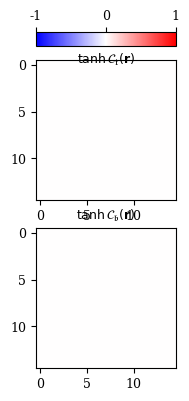

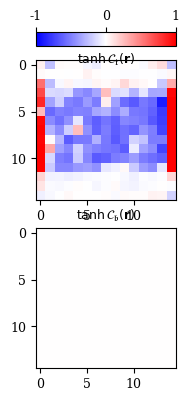

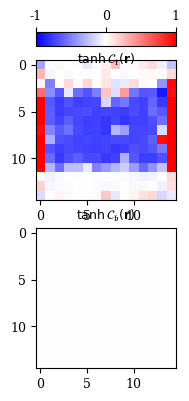

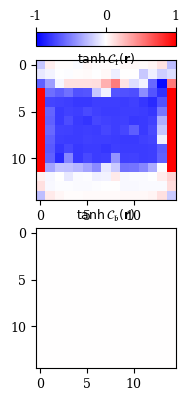

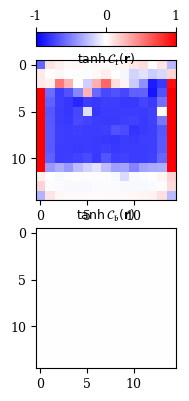

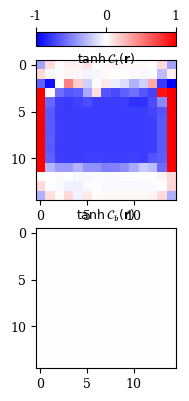

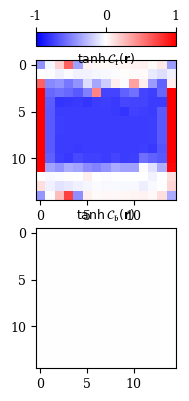

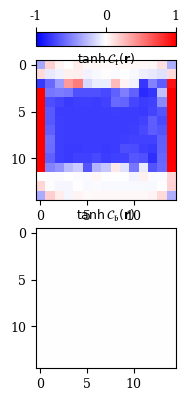

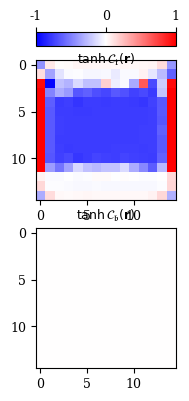

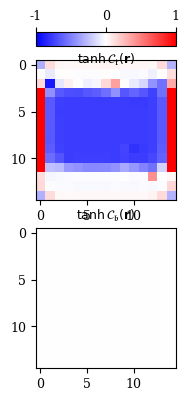

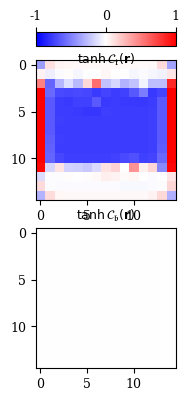

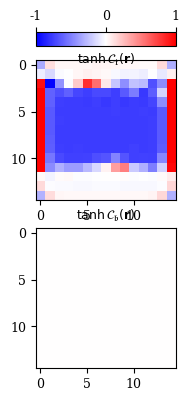

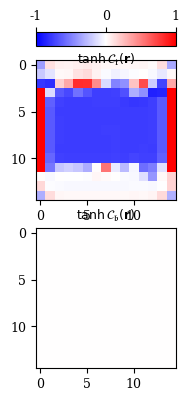

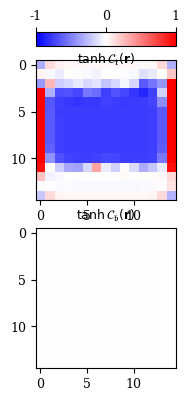

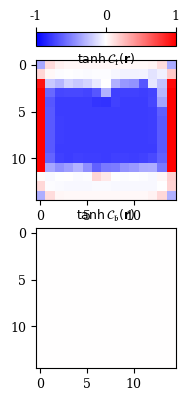

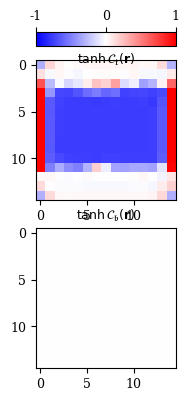

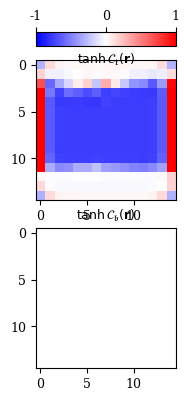

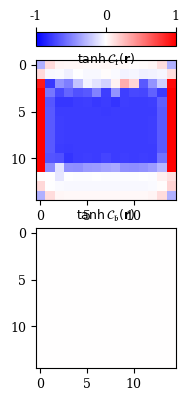

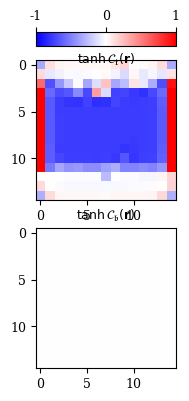

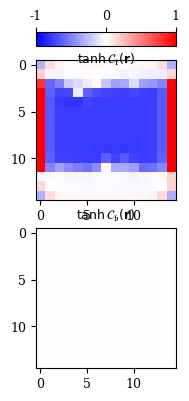

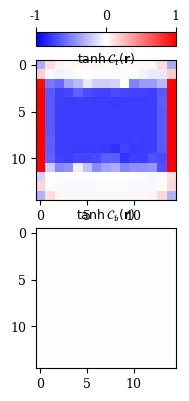

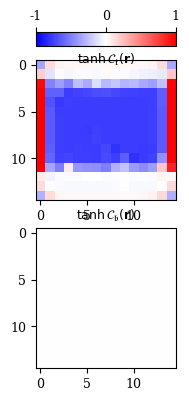

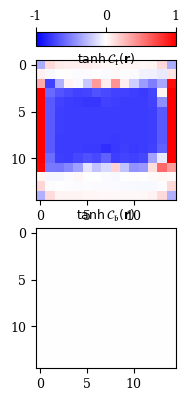

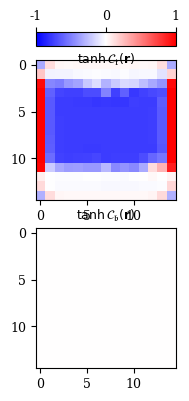

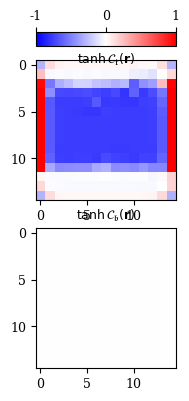

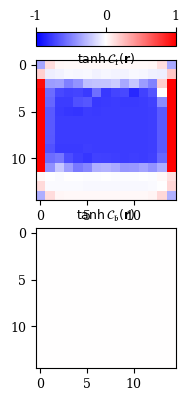

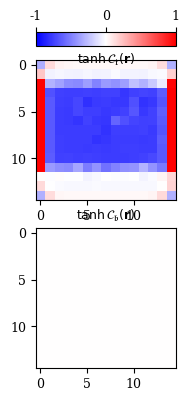

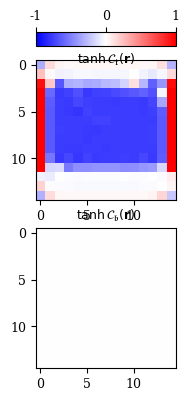

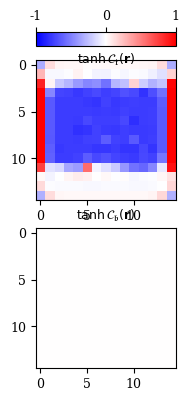

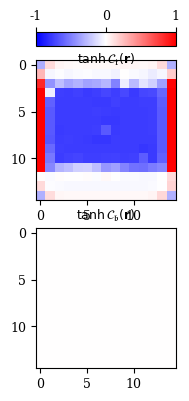

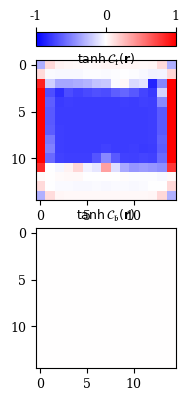

In [113]:
for idx in range(len(C_r_list)):
    fig,ax=plt.subplots(2,1)
    plot_C_r(C_r_list[idx][0].cpu(),ax,bottomcb=False)

/tmp/ipykernel_8626/2275308842.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(1,2,figsize=(5,2.5))


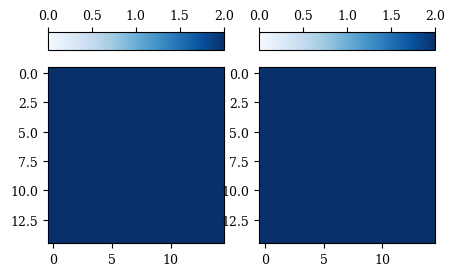

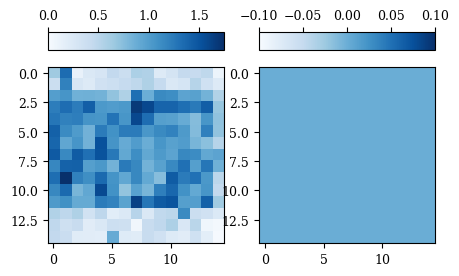

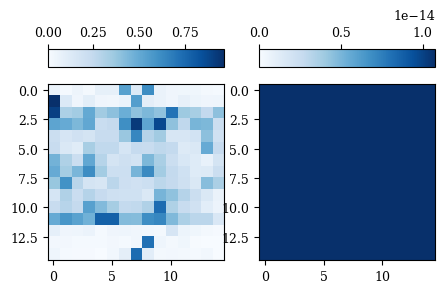

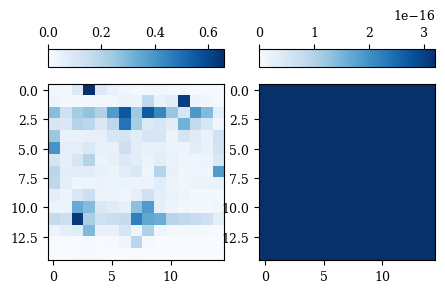

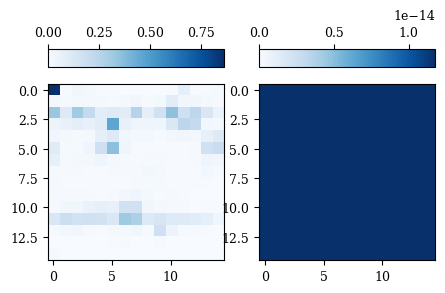

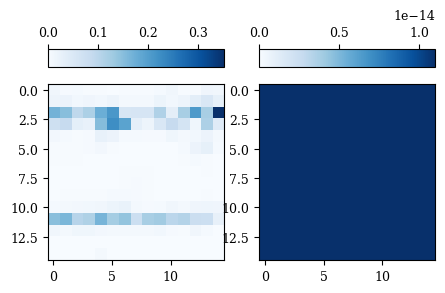

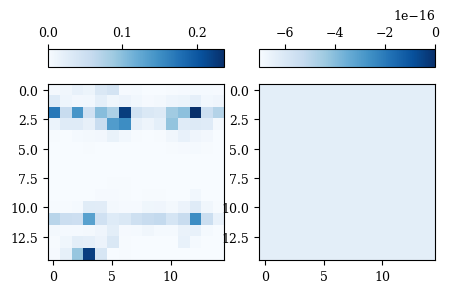

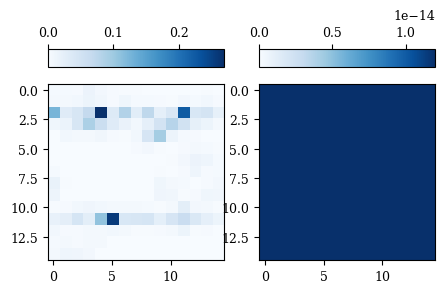

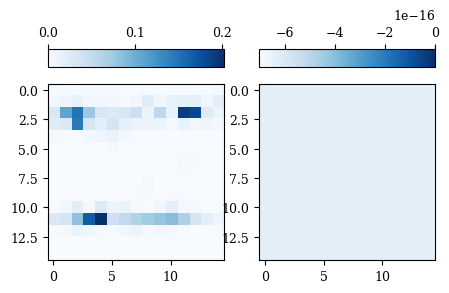

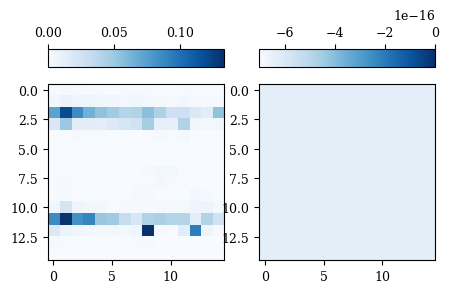

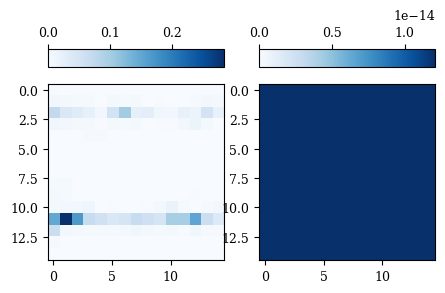

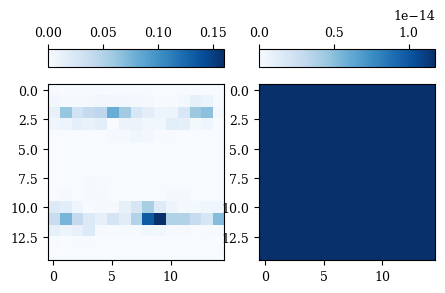

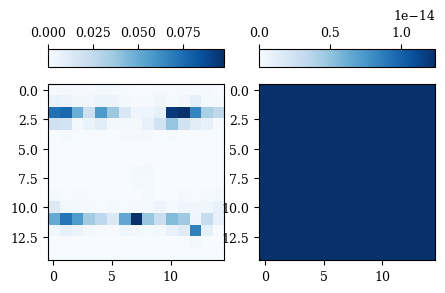

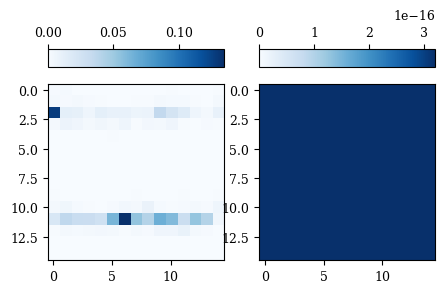

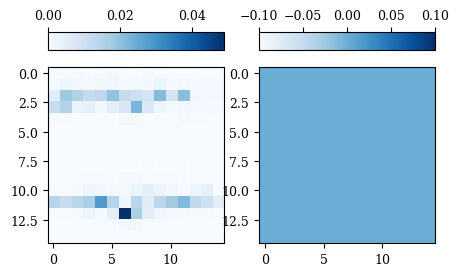

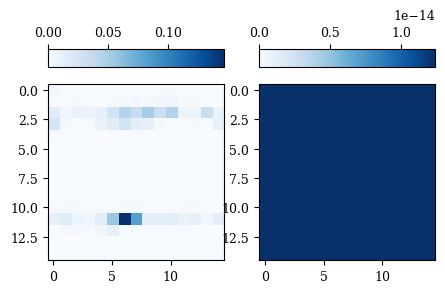

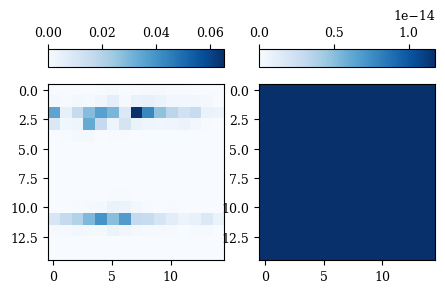

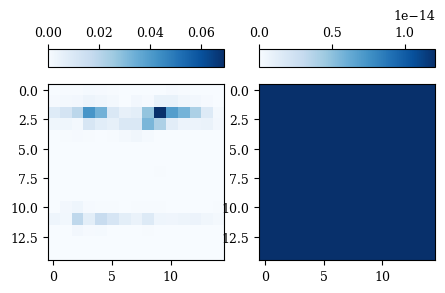

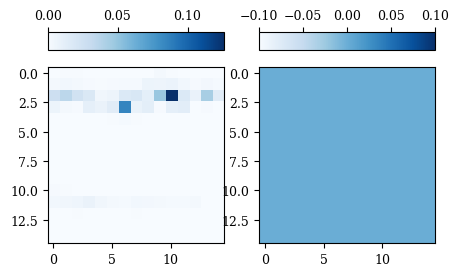

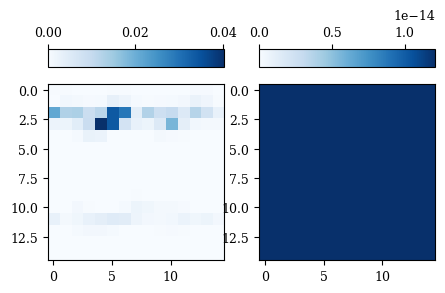

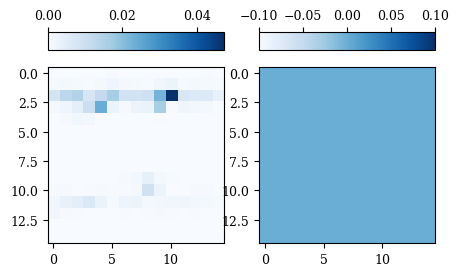

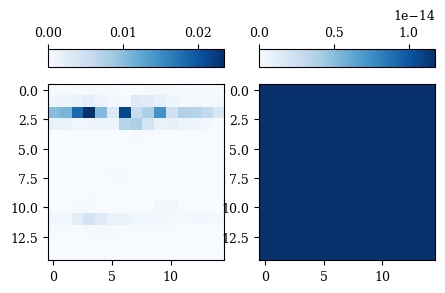

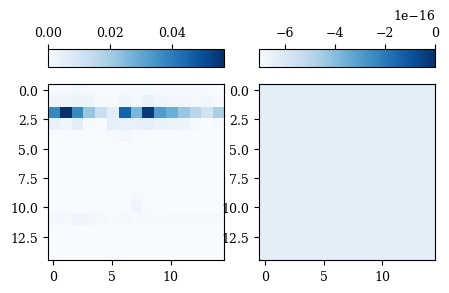

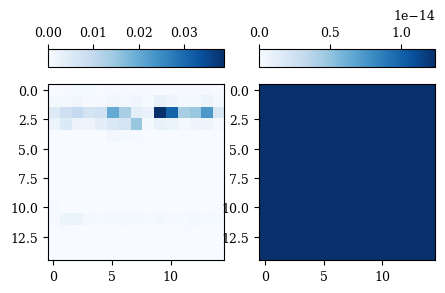

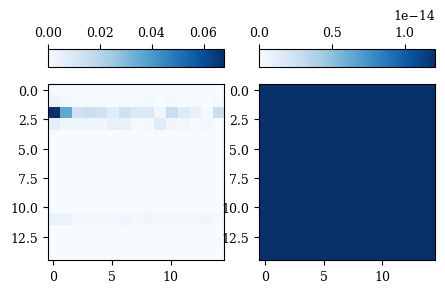

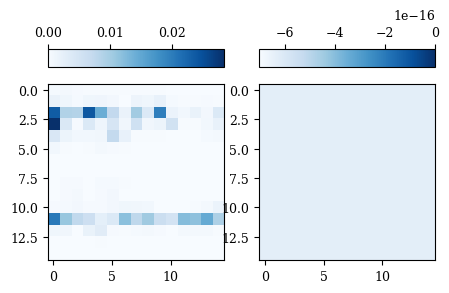

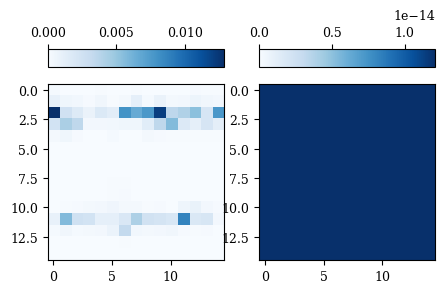

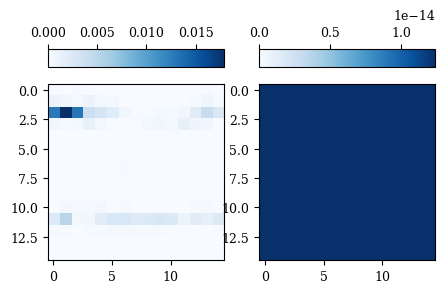

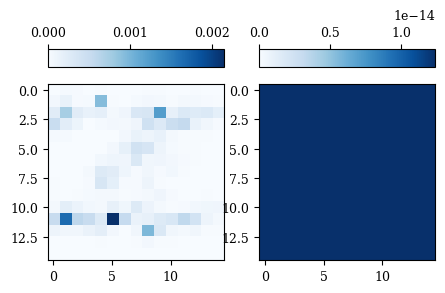

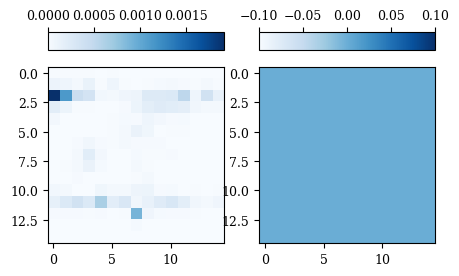

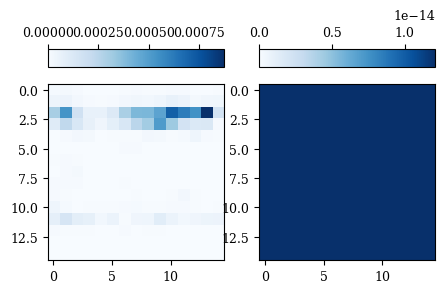

In [114]:
for idx in range(len(EC_list)):
    fig,ax=plt.subplots(1,2,figsize=(5,2.5))
    plot_EC(EC_list[idx].cpu(),ax=ax,vmax=None)


In [ ]:
fig,ax=plt.subplots(figsize=(4,4),)
im=ax.imshow((EC_list[-1][0])/np.log(2),cmap='Blues',vmin=0,)
axins=ax.inset_axes([0.,1.15,1,0.1])
plt.colorbar(im,cax=axins,label='EC',orientation='horizontal')
ax.set_xlabel('$j$')
ax.set_ylabel('$i$')

In [ ]:
for i in tqdm(range(5)):
    randomize(gtn2_torch,measure=True)
    measure_feedback_layer(gtn2_torch)
    nu_list.append( chern_number_quick(gtn2_torch.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2_torch.device,dtype=gtn2_torch.dtype_float))


## Single copy

In [56]:
gtn2=GTN2_torch(Lx=20,Ly=20,history=False,random_init=False,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=2,replica=1,)


mu_list=[1,3]
gtn2.a_i={}
gtn2.b_i={}
gtn2.A_i={}
gtn2.B_i={}
for mu in mu_list:
    gtn2.a_i[mu],gtn2.b_i[mu] = amplitude(gtn2.nshell,tau=[0,1],geometry='square',lower=True,mu=mu)
    gtn2.A_i[mu],gtn2.B_i[mu] = amplitude(gtn2.nshell,tau=[1,0],geometry='square',lower=False,mu=mu)


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


In [57]:
# nu_list =[]
# A_idx_0,B_idx_0,C_idx_0 = gtn2.generate_tripartite_circle()

ilist=np.arange(0,gtn2.Lx//2)
jlist=np.arange(0,gtn2.Ly)
subregion_m = torch.hstack((
    torch.from_numpy(gtn2.linearize_idx_span(ilist = ilist,jlist=jlist,layer=0)).cuda(),
    torch.from_numpy(gtn2.linearize_idx_span(ilist = ilist,jlist=jlist,layer=1)).cuda())
)
EC_list=[]
C_r_list=[]

In [61]:
# nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2.device,dtype=gtn2.dtype_float))
EC_list.append( gtn2.entanglement_contour(subregion_m,fermion_idx=False,Gamma=gtn2.C_m).reshape((2,ilist.shape[0],jlist.shape[0],2,2)).sum(axis=(-1,-2))) 
C_r_list.append( gtn2.local_Chern_marker(gtn2.C_m,))

for i in (range(10)):
    measure_feedback_layer_dw_line(gtn2,overlap=True,geometry='strip',truncate=True)
    randomize(gtn2,measure=True)
    
    # nu_list.append( chern_number_quick(gtn2.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2.device,dtype=gtn2.dtype_float))
    EC_list.append( gtn2.entanglement_contour(subregion_m,fermion_idx=False,Gamma=gtn2.C_m).reshape((2,ilist.shape[0],jlist.shape[0],2,2)).sum(axis=(-1,-2))) 
    C_r_list.append( gtn2.local_Chern_marker(gtn2.C_m,))




measure with feedback:   0%|                                                                                                           | 0/400 [00:00<?, ?it/s]

measure: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:01<00:00, 434.46it/s]


/tmp/ipykernel_224940/759781062.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(2,1)


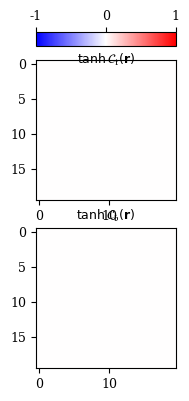

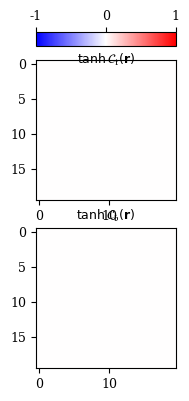

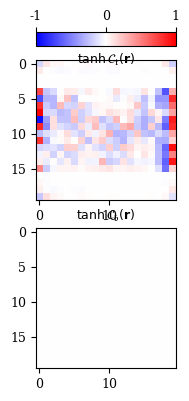

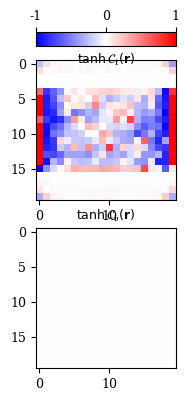

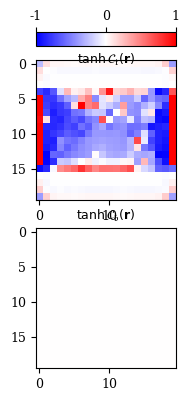

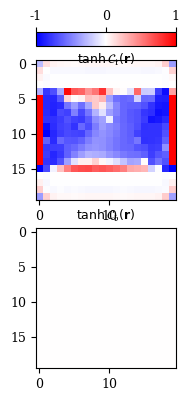

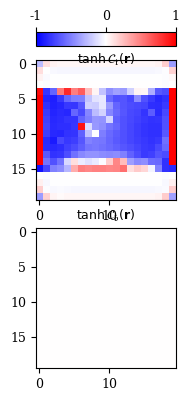

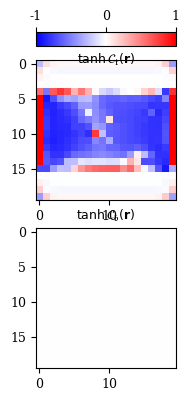

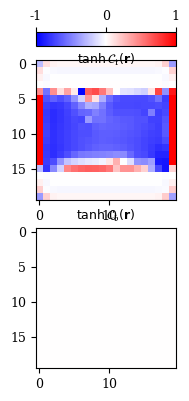

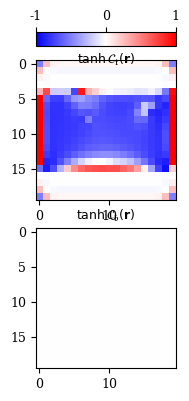

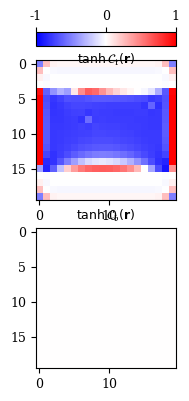

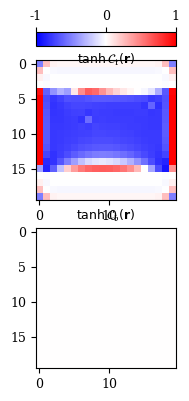

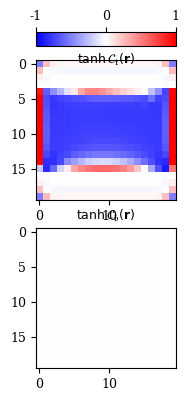

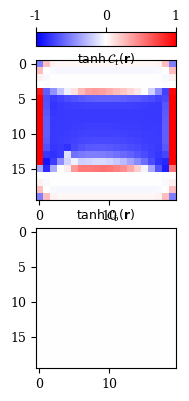

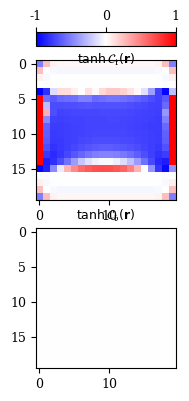

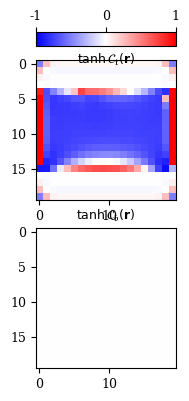

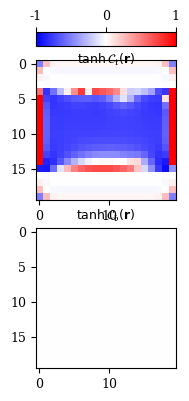

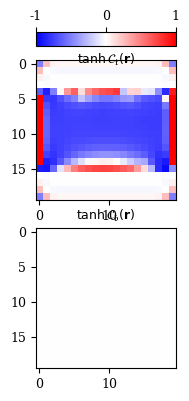

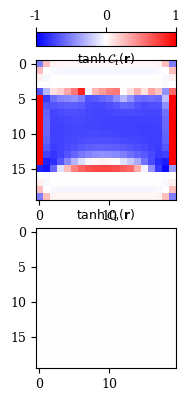

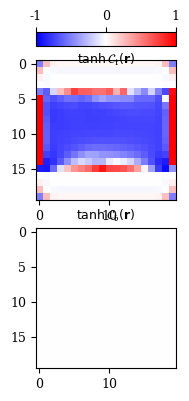

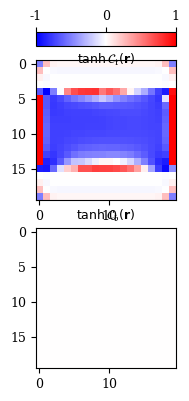

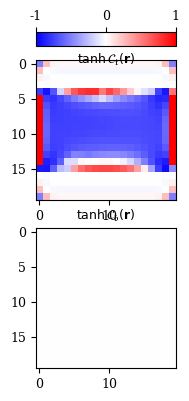

In [62]:
for idx in range(len(C_r_list)):
    fig,ax=plt.subplots(2,1)
    plot_C_r(C_r_list[idx][0].cpu(),ax,bottomcb=False)

/tmp/ipykernel_224940/2931819228.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(1,2,figsize=(5,2.5))


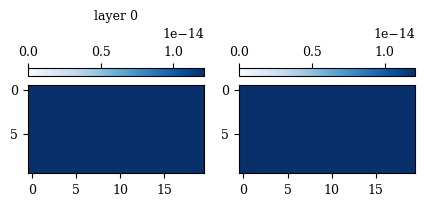

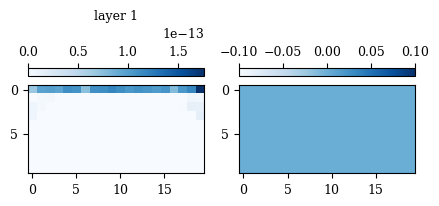

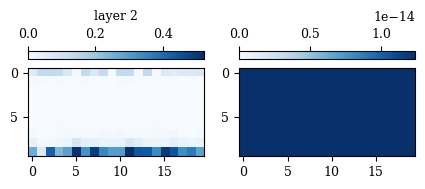

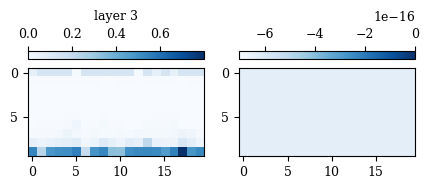

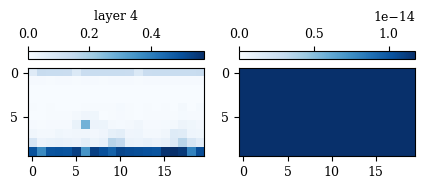

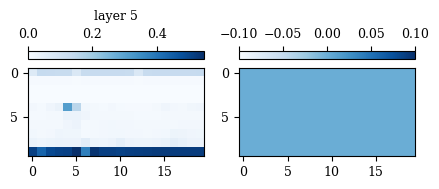

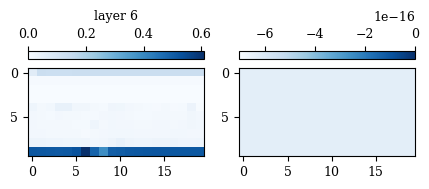

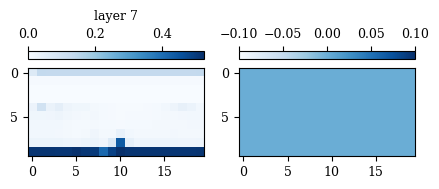

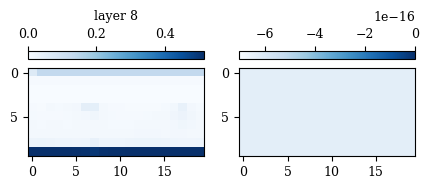

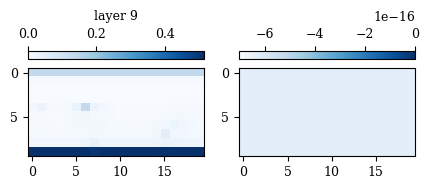

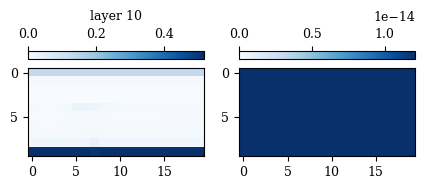

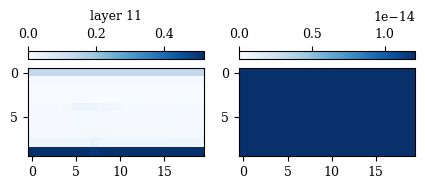

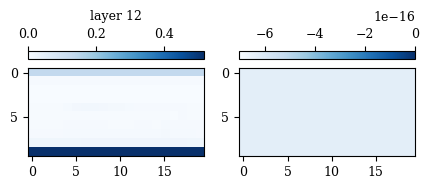

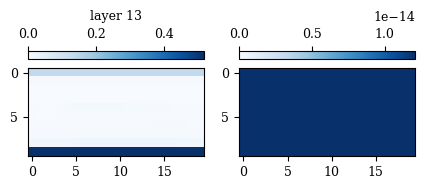

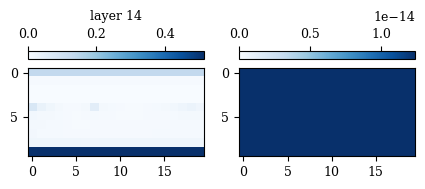

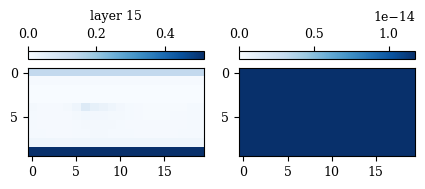

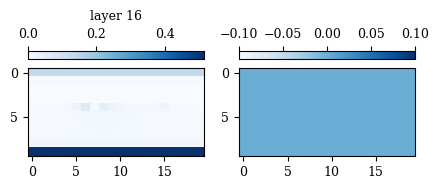

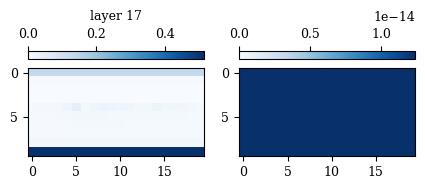

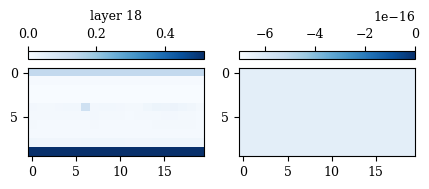

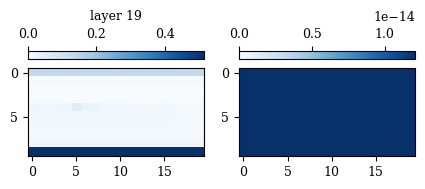

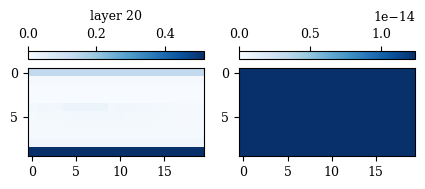

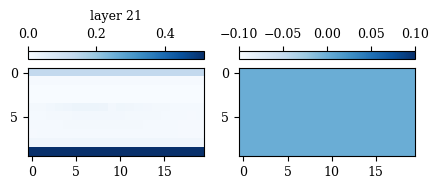

In [64]:
for idx in range(len(EC_list)):
    fig,ax=plt.subplots(1,2,figsize=(5,2.5))
    plot_EC(EC_list[idx].cpu(),ax=ax,vmax=None)
    ax[0].set_title(f'Epoch {idx}')

# Run

In [98]:
def run(L,seed,sigma):
    mu=1
    # nshell = (L-1)//2
    nshell = 2
    gtn2_torch=GTN2_torch(Lx=L,Ly=L,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=seed,orbit=2,nshell=nshell,layer=2,complex128=True)
    # gtn2_torch=GTN2_torch(Lx=L,Ly=L,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=seed,orbit=2,nshell=nshell,layer=2,replica=1,complex128=True)

    # gtn2_torch.C_m=C_m
    mu_list=[mu]
    tau_list = [(1,1),(1,-1)]
    gtn2_torch.a_i={}
    gtn2_torch.b_i={}
    gtn2_torch.A_i={}
    gtn2_torch.B_i={}
    for mu in mu_list:
        for tau in tau_list:
            gtn2_torch.a_i[mu,tau],gtn2_torch.b_i[mu,tau] = amplitude_fft_nshell_gpu(gtn2_torch.nshell,gtn2_torch.device,tau=tau,geometry='square',lower=True,mu=mu,nkx=5000,nky=5000)
            gtn2_torch.A_i[mu,tau],gtn2_torch.B_i[mu,tau] = amplitude_fft_nshell_gpu(gtn2_torch.nshell,gtn2_torch.device,tau=tau,geometry='square',lower=False,mu=mu,nkx=5000,nky=5000)
    nd_list = []
    # n_lower_list = []
    # n_upper_list = []
    
    nu_list =[]
    # TMI_list =[]
    nd_list.append(gtn2_torch.order_parameter(mu=mu,tau_list=tau_list))
    nu_list.append(gtn2_torch.chern_number_quick(selfaverage=True))
    # TMI_list.append(gtn2_torch.tripartite_mutual_information())

    for i in tqdm(range(gtn2_torch.Lx)):
        measure_feedback_layer(gtn2_torch,mu=mu)
        randomize(gtn2_torch,measure=True)
        if sigma>0:
            randomize_inter(gtn2_torch,scale=sigma)
        nu_list.append(gtn2_torch.chern_number_quick(selfaverage=True))
        nd_list.append(gtn2_torch.order_parameter(mu=mu,tau_list=tau_list))
        # n_lower_list.append(n_lower)
        # n_upper_list.append(n_upper)

        # nu_list.append( chern_number_quick(gtn2_torch.C_m,A_idx_0,B_idx_0,C_idx_0,device=gtn2_torch.device,dtype=gtn2_torch.dtype_float))
        # TMI_list.append(gtn2_torch.tripartite_mutual_information())
    # nu =( gtn2_torch.chern_number_quick(selfaverage=True))
    # nd=gtn2_torch.order_parameter(mu=mu,tau_list=tau_list)
    # EE = gtn2_torch.half_cut_entanglement_entropy(selfaverage=True)
    # TMI = (gtn2_torch.tripartite_mutual_information(selfaverage=True))
    # return gtn2_torch
    return nu_list,nd_list


In [ ]:
sigma_list = [0,0.1,0.2,0.3,0.4,.5,.6,.7,.8,.9,1]
rs_7=[[run(7,s,sigma=sigma) for s in range(1)] for sigma in sigma_list]

In [114]:
sigma_list = [0,0.1,0.2]
rs_9=[[run(9,s,sigma=sigma) for s in range(5)] for sigma in sigma_list]

Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:36<00:00,  4.02s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.33s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:35<00:00,  3.95s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.28s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:35<00:00,  3.95s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.76s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:39<00:00, 11.06s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.97s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.78s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.84s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.90s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.85s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.84s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:57<00:00,  6.38s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:26<00:00,  9.60s/it]


In [ ]:
rs_11=[[run(11,s,sigma=sigma) for s in range(5)] for sigma in sigma_list]

In [ ]:
rs_13=[[run(13,s,sigma=sigma) for s in range(5)] for sigma in sigma_list]

In [41]:
rs_7=torch.tensor(rs_7)

In [115]:
rs_9=torch.tensor(rs_9)

In [35]:
rs_11=torch.tensor(rs_11)

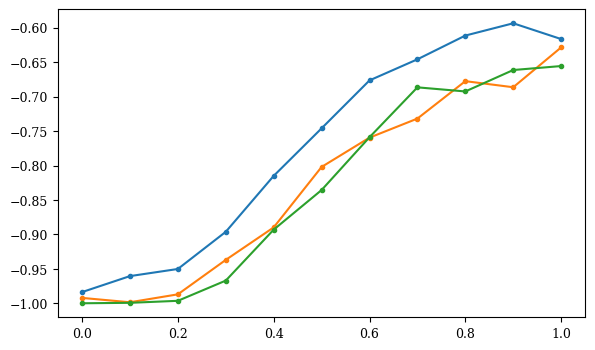

In [42]:
fig,ax=plt.subplots()
# ax.plot(sigma_list,rs_9[:,0],'.-')
# ax.plot(sigma_list,rs_11[:,0],'.-')
ax.plot(sigma_list,rs_7.mean(dim=1)[:,0],'.-')
ax.plot(sigma_list,rs_9.mean(dim=1)[:,0],'.-')
ax.plot(sigma_list,rs_11.mean(dim=1)[:,0],'.-')

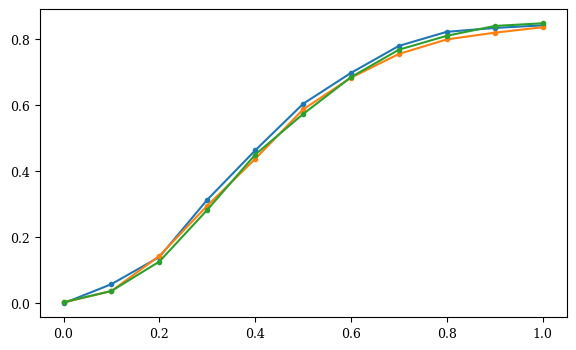

In [43]:
fig,ax=plt.subplots()
# ax.plot(sigma_list,rs_9[:,1],'.-')
# ax.plot(sigma_list,rs_11[:,1],'.-')
ax.plot(sigma_list,rs_7.mean(dim=1)[:,1],'.-')
ax.plot(sigma_list,rs_9.mean(dim=1)[:,1],'.-')
ax.plot(sigma_list,rs_11.mean(dim=1)[:,1],'.-')

In [152]:
C_m=gtn2_torch.C_m

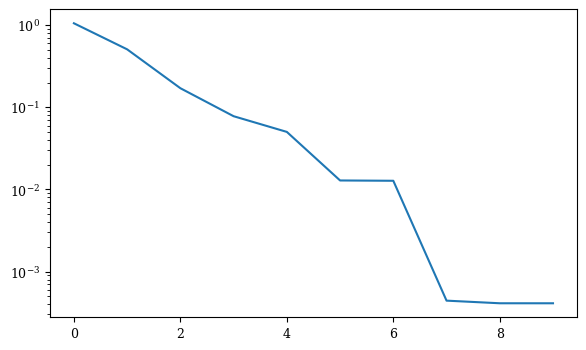

In [13]:
# plt.plot((torch.tensor(nu_list)+1),'.-')
plt.plot((torch.tensor(nd_list)))
plt.yscale('log')

In [46]:
from run_classA_2D_all import correlation_length

In [92]:
gtn2_torch = run(15,0,sigma=0.9)

Using cuda
GPU Model: NVIDIA L40S


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:09<00:00,  4.67s/it]


In [93]:
Cr_i,Cr_j, cr_i,cr_j=correlation_length(gtn2_torch.C_m,replica=1,layer=2,Lx=gtn2_torch.Lx,Ly=gtn2_torch.Ly)

In [94]:
SA = torch.tensor([gtn2_torch.entanglement_y_entropy(ly=ly,selfaverage=True) for ly in range(1,gtn2_torch.Ly//2+1)])

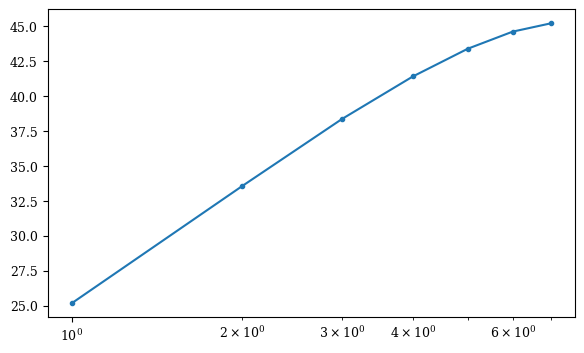

In [95]:
x=np.arange(1,gtn2_torch.Ly//2+1)
plt.plot(x,SA,'.-')
plt.xscale('log')

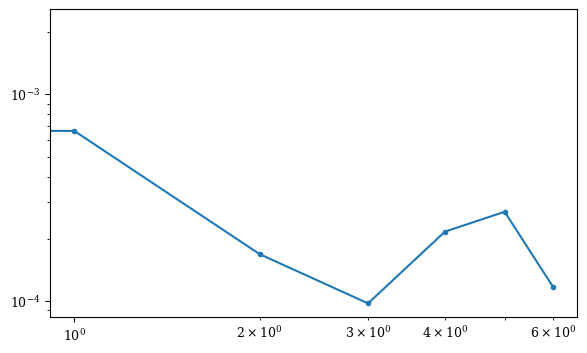

In [97]:
plt.plot(np.abs(Cr_i.cpu())[:],'.-')
plt.yscale('log')
plt.xscale('log')

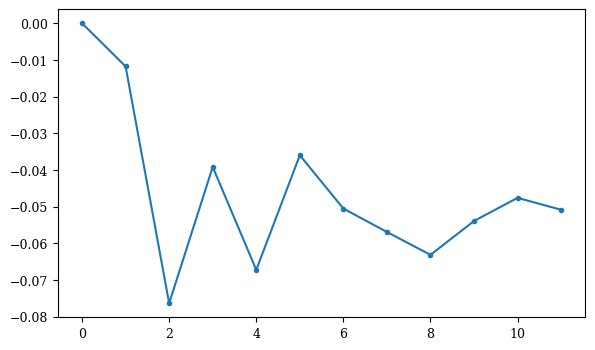

In [40]:
plt.plot((torch.tensor(nu_list)),'.-')
# plt.plot((torch.tensor(nd_list)))
# plt.yscale('log')

In [35]:
nd_list = [[run(L,0,sigma=sigma) for L in [11,13]] for sigma in np.round(np.arange(0,0.5,0.1),2)]

Using cuda
GPU Model: NVIDIA GeForce RTX 3090


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:14<00:00, 12.23s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 3090


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [07:10<00:00, 33.12s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 3090


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:20<00:00, 12.75s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 3090


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [07:18<00:00, 33.75s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 3090


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:22<00:00, 12.93s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 3090


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [07:23<00:00, 34.08s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 3090


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:24<00:00, 13.17s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 3090


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [07:32<00:00, 34.81s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 3090


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:26<00:00, 13.35s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 3090


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [07:41<00:00, 35.50s/it]


In [43]:
nd_L11_list=torch.tensor([nd_list[i][0] for i in range(5)])
nd_L13_list=torch.tensor([nd_list[i][1] for i in range(5)])

torch.Size([11, 10])

/tmp/ipykernel_26305/3269874.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rs_9=torch.tensor(rs_9)


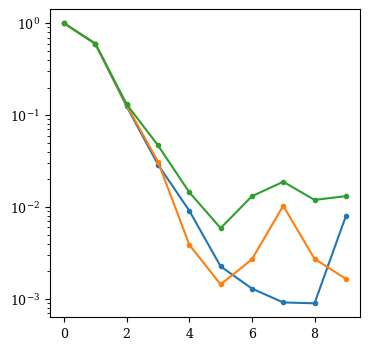

In [118]:
fig,ax=plt.subplots(figsize=(4,4))
rs_9=torch.tensor(rs_9)
for idx,sigma in enumerate(sigma_list):
    ax.plot(1+(rs_9.mean(dim=1)[idx,0,:]),'.-')


# plt.plot(rs_9.T,'.-')
plt.yscale('log')
# plt.ylim(1e-3,None)

/tmp/ipykernel_26305/3214819027.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rs_9=torch.tensor(rs_9)


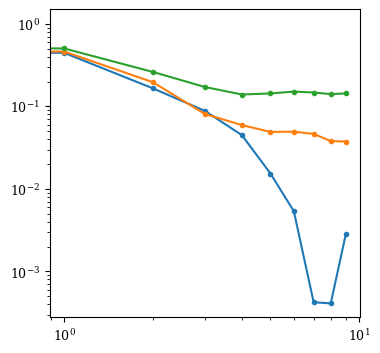

In [119]:
fig,ax=plt.subplots(figsize=(4,4))
rs_9=torch.tensor(rs_9)
for idx,sigma in enumerate(sigma_list):
    ax.plot((rs_9.mean(dim=1)[idx,1,:]),'.-')
ax.set_xscale('log')
ax.set_yscale('log')

(0.001, 1.9913590903814846)

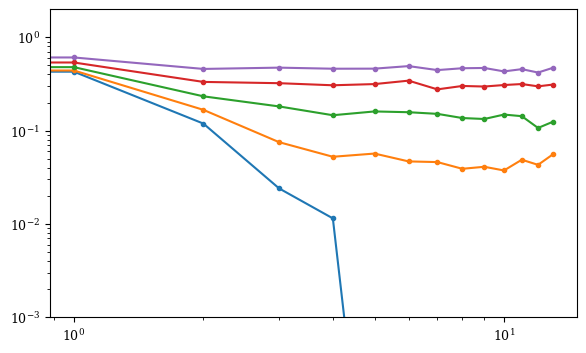

In [53]:
plt.plot(nd_L13_list.T,'.-')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-3,None)

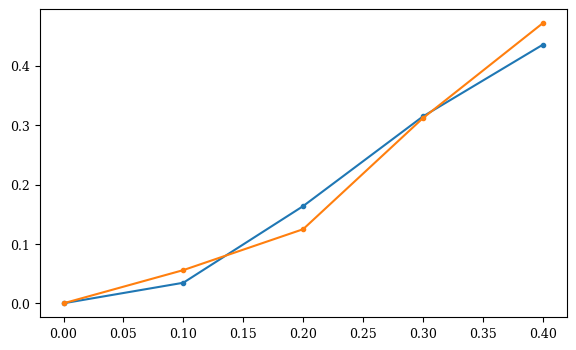

In [59]:
plt.plot(np.arange(0,0.5,0.1),nd_L11_list[:,-1],'.-')
plt.plot(np.arange(0,0.5,0.1),nd_L13_list[:,-1],'.-')

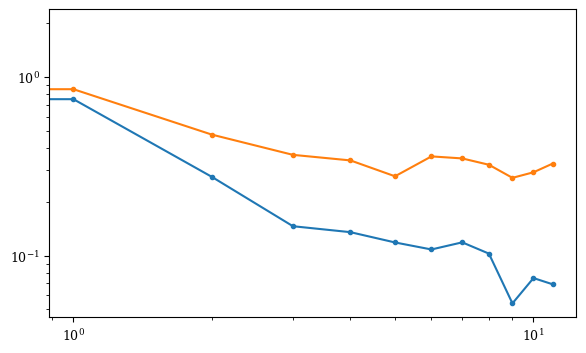

In [32]:
# plt.plot(torch.stack(nd_list).cpu(),'.-')
plt.plot(torch.stack(nd_0p1_list).cpu(),'.-')
plt.plot(torch.stack(nd_0p2_list).cpu(),'.-')
plt.yscale('log')
plt.xscale('log')

In [ ]:
nd_0p1_list = run(11,0,sigma=0.1)

In [30]:
nd_0p2_list = run(11,0,sigma=0.2)

Using cuda
GPU Model: NVIDIA GeForce RTX 3090


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:21<00:00, 12.85s/it]


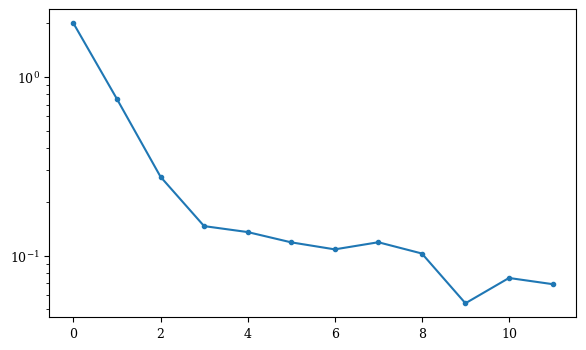

In [27]:
plt.plot(torch.stack(nd_0p1_list).cpu(),'.-')
plt.yscale('log')

In [ ]:
nu_list=[run(11,s,sigma=0.00) for s in range(2)]

In [71]:
torch.tensor(nu_list).mean(axis=0)

tensor([ 0.0000, -0.4557, -0.9125, -0.9825, -0.9942, -0.9982, -0.9967, -0.9978,
        -0.9991, -0.9978, -0.9970, -0.9987], dtype=torch.float64)

In [65]:
import pickle

In [66]:
with open('nu_list.pickle','wb') as f:
    pickle.dump(nu_list,f)

In [76]:
yerr

tensor([0.0000, 0.0161, 0.0060, 0.0033, 0.0021, 0.0012, 0.0014, 0.0010, 0.0006,
        0.0013, 0.0013, 0.0010], dtype=torch.float64)

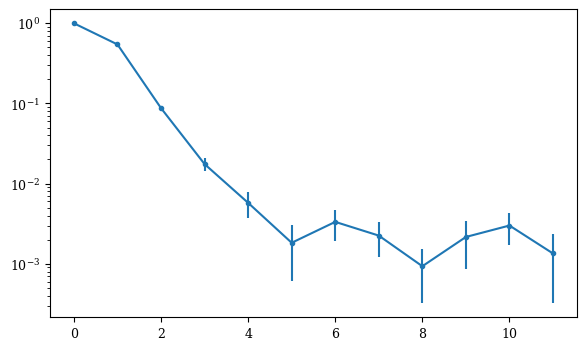

In [78]:
# plt.plot(torch.tensor(nu_list)+1,'.-')
data = torch.tensor(nu_list)
x=np.arange(data.shape[1])
y=data.mean(axis=0)
yerr=data.std(axis=0)/np.sqrt(data.shape[0])
plt.errorbar(x,y+1,yerr,fmt='.-')
plt.yscale('log')

In [92]:
gtn2_torch=run(9,0,sigma=0.00)

Using cuda
GPU Model: NVIDIA L40S


100%|███████████████████████████████████████████████████████████████████████| 9/9 [01:32<00:00, 10.26s/it]


tensor(0., device='cuda:0', dtype=torch.float64)

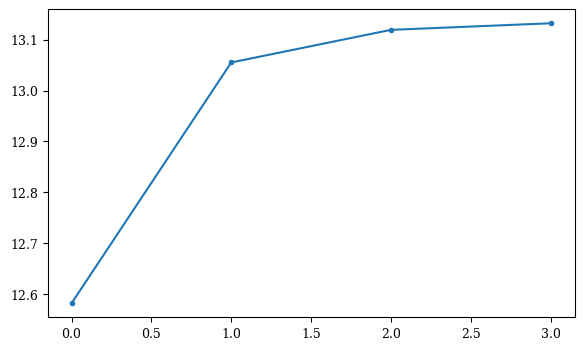

In [93]:
plt.plot(torch.tensor([gtn2_torch.entanglement_y_entropy(ly=ly,selfaverage=True) for ly in range(1,gtn2_torch.Ly//2+1)]),'.-')

In [ ]:
data = torch.tensor(nu_list)
x=np.arange(data.shape[1])
y=data.mean(axis=0)
yerr=data.std(axis=0)/np.sqrt(data.shape[0])
plt.errorbar(x,y+1,yerr,fmt='.-')
plt.yscale('log')

In [30]:
S=[gtn2_torch.entanglement_y_entropy(ly=ly,selfaverage=True) for ly in range(1,gtn2_torch.Ly//2+1)]

In [35]:
S_=[gtn2_torch.entanglement_y_entropy(ly=ly,selfaverage=True) for ly in range(1,gtn2_torch.Ly//2+1)]

In [83]:
S_1=[gtn2_torch.entanglement_y_entropy(ly=ly,selfaverage=True) for ly in range(1,gtn2_torch.Ly//2+1)]

In [60]:
# S_3=[gtn2_torch.entanglement_y_entropy(ly=ly,selfaverage=True) for ly in range(1,gtn2_torch.Ly//2+1)]
S_3_=[gtn2_torch.entanglement_y_entropy(ly=ly,selfaverage=True) for ly in range(1,gtn2_torch.Ly//2+1)]

Text(0.5, 0, '$\\frac{L_y}{\\pi}\\sin \\frac{\\pi l_y}{L_y}$')

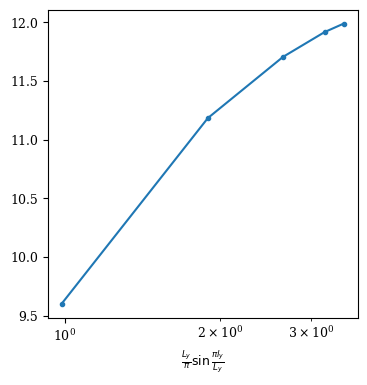

In [84]:
fig,ax=plt.subplots(figsize=(4,4))
x=np.arange(1,gtn2_torch.Ly//2+1)
ax.plot((gtn2_torch.Ly/np.pi*np.sin(x/gtn2_torch.Ly*np.pi)),torch.tensor(S_1),'.-')
ax.set_xscale('log')
ax.set_xlabel(r'$\frac{L_y}{\pi}\sin \frac{\pi l_y}{L_y}$')

Text(0.5, 0, '$\\frac{L_y}{\\pi}\\sin \\frac{\\pi l_y}{L_y}$')

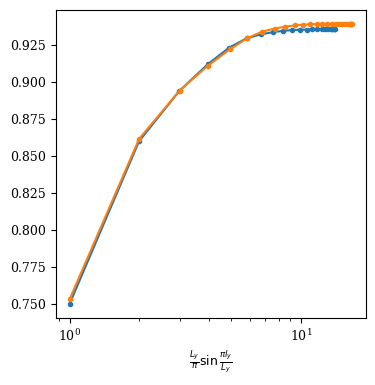

In [43]:
fig,ax=plt.subplots(figsize=(4,4))
x=np.arange(1,44//2+1)
ax.plot((44/np.pi*np.sin(x/44*np.pi)),torch.tensor(S)/11,'.-')
x=np.arange(1,52//2+1)
ax.plot((52/np.pi*np.sin(x/52*np.pi)),torch.tensor(S_)/13,'.-')
ax.set_xscale('log')
ax.set_xlabel(r'$\frac{L_y}{\pi}\sin \frac{\pi l_y}{L_y}$')

In [ ]:
fig,ax=plt.subplots(figsize=(4,4))
x=np.arange(1,44//2+1)
ax.plot((44/np.pi*np.sin(x/44*np.pi)),torch.tensor(S_1),'.-')
ax.set_xscale('log')
ax.set_xlabel(r'$\frac{L_y}{\pi}\sin \frac{\pi l_y}{L_y}$')

Text(0.5, 0, '$\\frac{L_y}{\\pi}\\sin \\frac{\\pi l_y}{L_y}$')

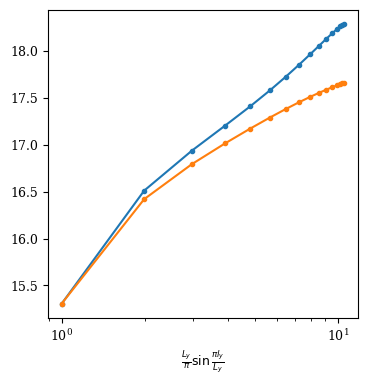

In [21]:
fig,ax=plt.subplots(figsize=(4,4))
x=np.arange(1,33//2+1)
ax.plot((33/np.pi*np.sin(x/33*np.pi)),(zz['SA'][0]),'.-')
ax.plot((33/np.pi*np.sin(x/33*np.pi)),(zz['SA'][1]),'.-')
ax.set_xscale('log')
ax.set_xlabel(r'$\frac{L_y}{\pi}\sin \frac{\pi l_y}{L_y}$')

Text(0.5, 0, '$\\frac{L_y}{\\pi}\\sin \\frac{\\pi l_y}{L_y}$')

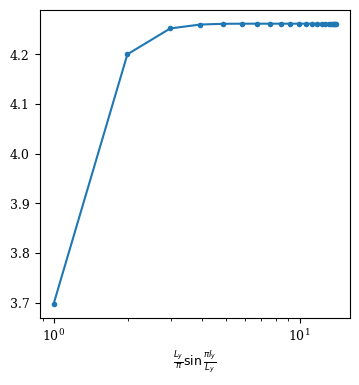

In [61]:
fig,ax=plt.subplots(figsize=(4,4))
x=np.arange(1,44//2+1)
ax.plot((44/np.pi*np.sin(x/44*np.pi)),torch.tensor(S_3_),'.-')
ax.set_xscale('log')
ax.set_xlabel(r'$\frac{L_y}{\pi}\sin \frac{\pi l_y}{L_y}$')

In [64]:
gtn2_torch.c2g(ilist=[0,1],jlist=[0,1])


tensor([   0,    1,    2,    3,    4,    5,    6,    7,  176,  177,  178,  179,
         180,  181,  182,  183, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
        2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119], device='cuda:0')

In [145]:
gtn2_torch.half_cut_entanglement_y_entropy(selfaverage=True)

tensor(6.3490, device='cuda:0', dtype=torch.float64)

In [ ]:
nd_list7, n_lower_list7, n_upper_list7 =  run(7,1,sigma=0.00)

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:33<00:00,  1.20s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


  0%|                                                                                                                                     | 0/14 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [113]:
nd_list11, n_lower_list11, n_upper_list11 =  run(11,1,sigma=0.001)

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [02:22<00:00,  3.23s/it]


In [117]:
nd_list21, n_lower_list21, n_upper_list21 =  run(21,1,sigma=0.001)

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [21:34<00:00, 30.82s/it]


In [96]:
nd_list, n_lower_list, n_upper_list =  run(7,0,sigma=0.001)

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:33<00:00,  1.20s/it]


[autoreload of GTN2_torch failed: Traceback (most recent call last):
  File "/home/hp636/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/hp636/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/hp636/.pyenv/versions/anaconda3-2024.06-1/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/scratch/hp636/GTN/GTN2_to

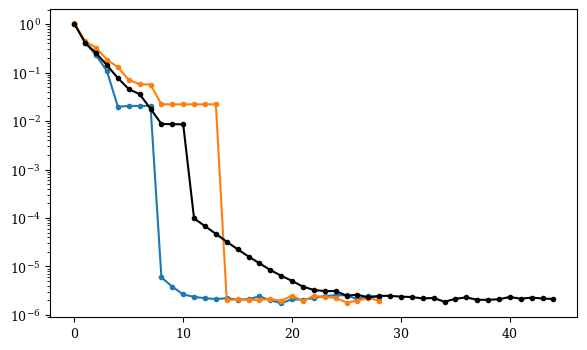

In [118]:
plt.plot(torch.tensor(nd_list),'.-')
plt.plot(torch.tensor(nd_list7),'.-')
plt.plot(torch.tensor(nd_list11),'.-',color='k')
plt.yscale('log')

In [ ]:
what happened at this jump??? why?

In [60]:
nd_list_11, n_lower_list_11, n_upper_list_11 =  run(11,0,sigma=0.1)

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [01:08<00:00,  3.11s/it]


In [ ]:
nd_list_21, n_lower_list_21, n_upper_list_21 =  run(21,0,sigma=0.1)

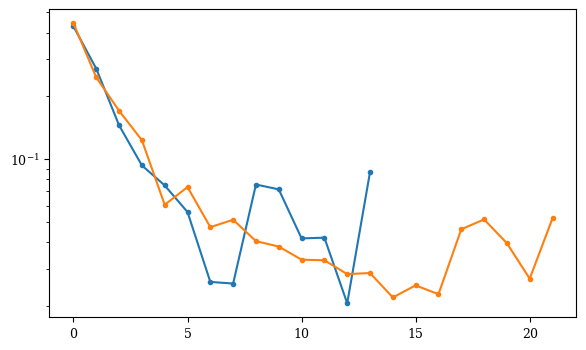

In [ ]:
plt.plot(torch.tensor(nd_list),'.-')
plt.plot(torch.tensor(nd_list_11),'.-')
plt.plot(torch.tensor(nd_list_21),'.-')

plt.yscale('log')

In [ ]:
why does it only saturate at ??
why cannot it keep going down?


In [102]:
1-n_lower_list[-1].mean()+n_upper_list[-1].mean()

2.309732467171559e-06

In [105]:
gtn2_torch=GTN2_torch(Lx=7,Ly=7,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=3,layer=2,complex128=True)

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


In [107]:
gtn2_torch.C_m.shape

torch.Size([392, 392])

In [110]:
gtn2_torch.L*2

196

In [103]:
nd_list


[tensor(1.0276, device='cuda:0', dtype=torch.float64),
 tensor(0.4155, device='cuda:0', dtype=torch.float64),
 tensor(0.2286, device='cuda:0', dtype=torch.float64),
 tensor(0.1070, device='cuda:0', dtype=torch.float64),
 tensor(0.0196, device='cuda:0', dtype=torch.float64),
 tensor(0.0206, device='cuda:0', dtype=torch.float64),
 tensor(0.0205, device='cuda:0', dtype=torch.float64),
 tensor(0.0205, device='cuda:0', dtype=torch.float64),
 tensor(5.9354e-06, device='cuda:0', dtype=torch.float64),
 tensor(3.8167e-06, device='cuda:0', dtype=torch.float64),
 tensor(2.6445e-06, device='cuda:0', dtype=torch.float64),
 tensor(2.3488e-06, device='cuda:0', dtype=torch.float64),
 tensor(2.2119e-06, device='cuda:0', dtype=torch.float64),
 tensor(2.1185e-06, device='cuda:0', dtype=torch.float64),
 tensor(2.2080e-06, device='cuda:0', dtype=torch.float64),
 tensor(2.0716e-06, device='cuda:0', dtype=torch.float64),
 tensor(2.1147e-06, device='cuda:0', dtype=torch.float64),
 tensor(2.4039e-06, device='c

In [99]:
n_lower_list[-1]

array([[0.99999946, 0.9999994 , 0.99999947, 0.99999916, 0.99999965,
        0.99999875, 0.99999791],
       [0.99999918, 0.99999898, 0.99999858, 0.99999961, 0.99999859,
        0.99999966, 0.99999939],
       [0.99999786, 0.99999922, 0.99999954, 0.99999935, 0.99999762,
        0.99999861, 0.99999851],
       [0.99999686, 0.99999869, 0.9999986 , 0.99999941, 0.99999881,
        0.99999956, 0.99999957],
       [0.99999765, 0.99999843, 0.99999958, 0.99999939, 0.99999951,
        0.99999884, 0.99999787],
       [0.9999993 , 0.99999946, 0.99999923, 0.99999893, 0.99999898,
        0.99999741, 0.9999998 ],
       [0.99999733, 0.99999795, 0.99999871, 0.99999962, 0.99999904,
        0.99999838, 0.99999942]])

In [94]:
1-n_lower_list[14].mean()

0.02212895379270763

In [95]:
n_upper_list[14].mean()

3.244975493855972e-08

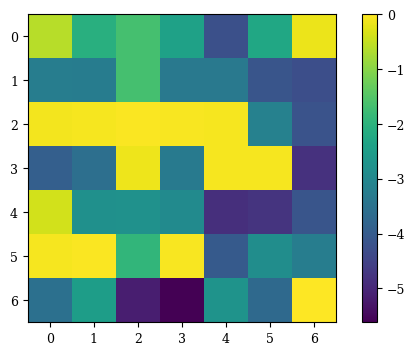

In [80]:
plt.imshow(np.log(1-n_lower_list[0]))
plt.colorbar()

/tmp/ipykernel_182544/1524160898.py:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(n_upper_list[0]))


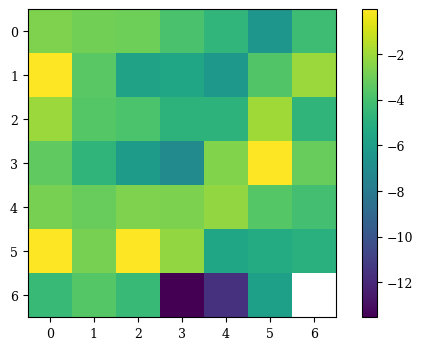

In [81]:
plt.imshow(np.log(n_upper_list[0]))
plt.colorbar()


In [28]:
nd, n_lower, n_upper =gtn2.order_parameter()

In [30]:
n_lower

array([[0.99086177, 0.98640828, 0.98075043, 0.99263069, 0.99309178,
        0.99585846, 0.99144797, 0.96801351, 0.99049822, 0.99549342,
        0.98346798],
       [0.97873639, 0.99302452, 0.99411917, 0.99336508, 0.98799874,
        0.98786102, 0.98796017, 0.99434812, 0.98298477, 0.99329853,
        0.99560926],
       [0.98630685, 0.98835327, 0.99634622, 0.9825263 , 0.9925591 ,
        0.97696385, 0.99596925, 0.99729076, 0.99265714, 0.98973523,
        0.98446714],
       [0.99268151, 0.98297783, 0.97989999, 0.9962645 , 0.99598798,
        0.99513236, 0.99196346, 0.99374968, 0.99153594, 0.96712397,
        0.99580675],
       [0.99425526, 0.98892195, 0.98749358, 0.98783898, 0.99120804,
        0.98695513, 0.98344761, 0.99049287, 0.99258122, 0.99192453,
        0.96617985],
       [0.98910078, 0.98109737, 0.98764079, 0.97542945, 0.97668004,
        0.99039396, 0.98612987, 0.97662819, 0.97116512, 0.98199103,
        0.99324408],
       [0.99410275, 0.99042111, 0.99403473, 0.99285471, 0.

In [31]:
n_upper

array([[0.00688486, 0.00561621, 0.00579222, 0.00950026, 0.0082545 ,
        0.01670273, 0.01549217, 0.01972681, 0.01832194, 0.00566698,
        0.00425356],
       [0.01175638, 0.02697424, 0.05260973, 0.02298704, 0.01329351,
        0.01742382, 0.0059952 , 0.00677059, 0.00778141, 0.01119994,
        0.00934826],
       [0.02243004, 0.04137152, 0.95056376, 0.00497152, 0.00683246,
        0.01169075, 0.0180031 , 0.00253031, 0.0072873 , 0.01359655,
        0.00499493],
       [0.02533813, 0.00994131, 0.01970443, 0.01790515, 0.01477423,
        0.00624009, 0.00582302, 0.00377601, 0.02084332, 0.00382606,
        0.02577974],
       [0.00769201, 0.00651511, 0.01971353, 0.01701086, 0.00977242,
        0.00695288, 0.00803498, 0.00706618, 0.00292414, 0.02500453,
        0.00831817],
       [0.00708909, 0.02129332, 0.02149556, 0.0097825 , 0.01810617,
        0.03135955, 0.00777273, 0.02556597, 0.01065978, 0.00973575,
        0.02278593],
       [0.01312048, 0.00382106, 0.01965348, 0.02193845, 0.

In [61]:
op11=[run(11,seed,sigma=0.1) for seed in range(5)]

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.95s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.90s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.93s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.83s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.89s/it]


In [62]:
sum(op11)/5

tensor(0.0541, device='cuda:0', dtype=torch.float64)

In [63]:
op13=[run(13,seed,sigma=0.1) for seed in range(5)]

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:57<00:00,  4.46s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:58<00:00,  4.52s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:58<00:00,  4.47s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:59<00:00,  4.58s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:59<00:00,  4.55s/it]


In [64]:
sum(op13)/5

tensor(0.0487, device='cuda:0', dtype=torch.float64)

In [65]:
op15=[run(15,seed,sigma=0.1) for seed in range(5)]

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:46<00:00,  7.09s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:47<00:00,  7.17s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:46<00:00,  7.11s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:47<00:00,  7.16s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:47<00:00,  7.17s/it]


In [66]:
sum(op15)/5

tensor(0.0571, device='cuda:0', dtype=torch.float64)

In [67]:
op17=[run(17,seed,sigma=0.1) for seed in range(5)]

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [03:16<00:00, 11.55s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [03:16<00:00, 11.58s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [03:16<00:00, 11.58s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [03:16<00:00, 11.56s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [03:16<00:00, 11.57s/it]


In [68]:
sum(op17)/5

tensor(0.0420, device='cuda:0', dtype=torch.float64)

In [38]:
run(15,0,sigma=0.)

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [01:30<00:00,  6.02s/it]


tensor(2.7792e-05, device='cuda:0', dtype=torch.float64)

In [19]:
gtn2.order_parameter()

tensor(1.9059e-05, device='cuda:0', dtype=torch.float64)

In [23]:
gtn2.order_parameter()

tensor(-0.0064, device='cuda:0', dtype=torch.float64)

In [21]:
gtn2.order_parameter()

tensor(-0.0087, device='cuda:0', dtype=torch.float64)

In [25]:
gtn2.order_parameter()

tensor(-0.0900, device='cuda:0', dtype=torch.float64)

In [28]:
gtn2.order_parameter()

tensor(0.4937, device='cuda:0', dtype=torch.float64)

In [30]:
gtn2.order_parameter()

tensor(0.8026, device='cuda:0', dtype=torch.float64)

In [79]:
gtn2_torch_0p4_list = [run(11,seed,sigma=0.4) for seed in range(10)]

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.90s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.91s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.92s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.92s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.90s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:34<00:00,  3.11s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.91s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.93s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.90s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.92s/it]


In [16]:
gtn2_torch_0_list = [run(11,seed,sigma=0) for seed in range(2)]

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:30<00:00,  2.75s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:27<00:00,  2.46s/it]


In [95]:
gtn2_torch_0p1_list = [run(11,seed,sigma=0.1) for seed in range(2)]

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:30<00:00,  2.81s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:32<00:00,  2.98s/it]


In [100]:
gtn2_torch_0p2_list = [run(11,seed,sigma=0.2) for seed in range(2)]

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:30<00:00,  2.78s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.84s/it]


In [101]:
gtn2_torch_0p3_list = [run(11,seed,sigma=0.3) for seed in range(2)]

Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.83s/it]


Using cuda
GPU Model: NVIDIA GeForce RTX 2080 Ti


100%|████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.86s/it]


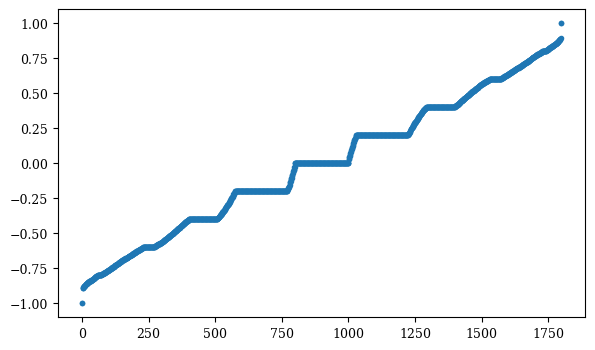

In [180]:
plt.plot(torch.linalg.eigvalsh(sum([gtn.C_m for gtn in gtn2_torch_0p4_list])/len(gtn2_torch_0p4_list)/1j).cpu(),'.')

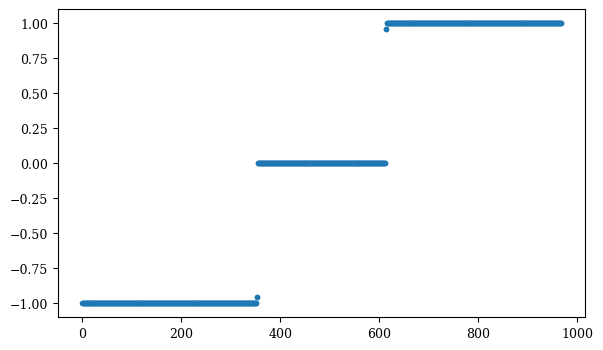

In [17]:
plt.plot(torch.linalg.eigvalsh(sum([gtn.C_m for gtn in gtn2_torch_0_list])/len(gtn2_torch_0_list)/1j).cpu(),'.')

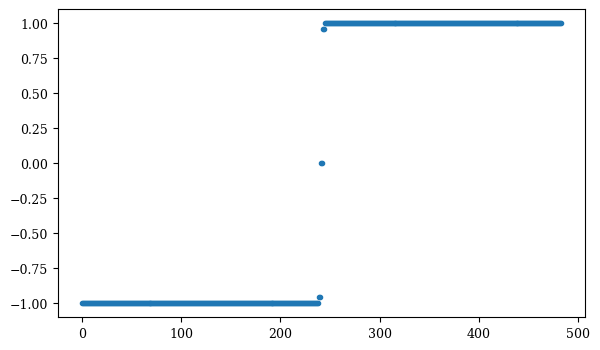

In [18]:
plt.plot(torch.linalg.eigvalsh(sum([gtn.C_m[:gtn.L*2,:gtn.L*2] for gtn in gtn2_torch_0_list])/len(gtn2_torch_0_list)/1j).cpu(),'.')

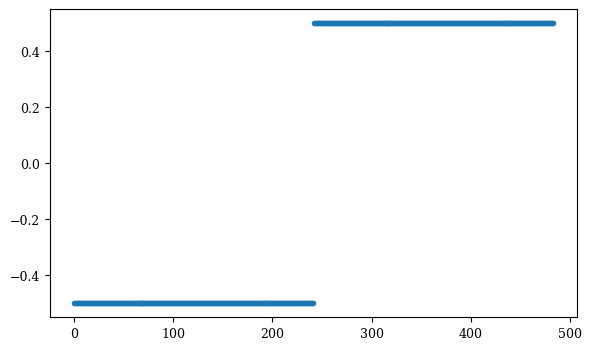

In [20]:
plt.plot(torch.linalg.eigvalsh(sum([gtn.C_m[:gtn.L*2,:gtn.L*2] for gtn in gtn2_torch_0_list[:1]])/len(gtn2_torch_0_list)/1j).cpu(),'.')

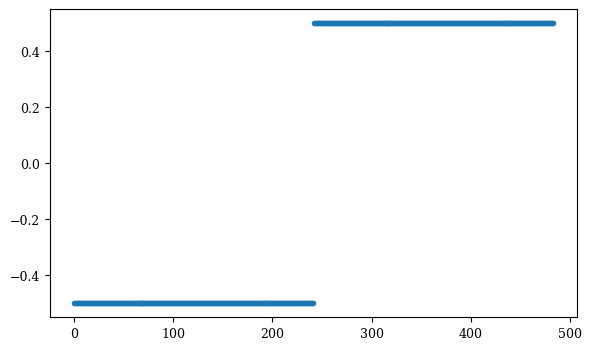

In [21]:
plt.plot(torch.linalg.eigvalsh(sum([gtn.C_m[:gtn.L*2,:gtn.L*2] for gtn in gtn2_torch_0_list[1:]])/len(gtn2_torch_0_list)/1j).cpu(),'.')

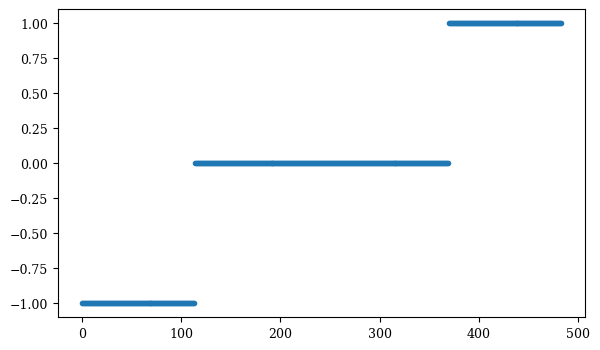

In [19]:
plt.plot(torch.linalg.eigvalsh(sum([gtn.C_m[gtn.L*2:,gtn.L*2:] for gtn in gtn2_torch_0_list])/len(gtn2_torch_0_list)/1j).cpu(),'.')

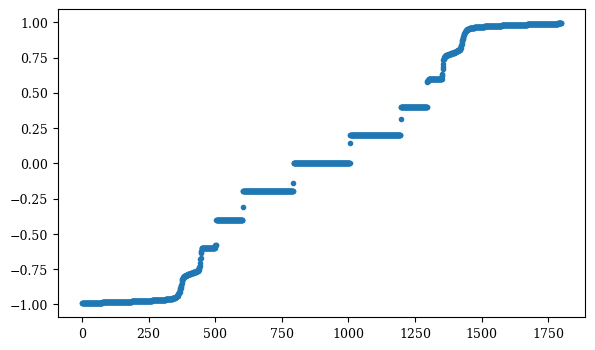

In [185]:
plt.plot(torch.linalg.eigvalsh(sum([gtn.C_m for gtn in gtn2_torch_0p1_list])/len(gtn2_torch_0p1_list)/1j).cpu(),'.')

In [20]:
gtn2=gtn2_torch_list[0]

In [21]:
gtn2.replica

1

In [22]:
(gtn2.replica, gtn2.layer, gtn2.Lx,gtn2.Ly,gtn2.orbit,2)*2

(1, 2, 15, 15, 2, 2, 1, 2, 15, 15, 2, 2)

In [28]:
C_m_reshape=gtn2.C_m.reshape( (gtn2.replica, gtn2.layer, gtn2.Lx,gtn2.Ly,gtn2.orbit,2) *2)

In [29]:
C_m_reshape.mean((2,3,8,9,))

torch.Size([1, 2, 2, 2, 1, 2, 2, 2])

In [ ]:
gtn2_torch_list[0].C_m.reshape(())

In [45]:
# z=torch.arange(8).reshape((2,-1))
z=torch.tensor([1,2,4,5,9,8,7,6]).reshape((2,-1))

In [46]:
z

tensor([[1, 2, 4, 5],
        [9, 8, 7, 6]])

In [32]:
kernel = torch.ones(4)/4

In [47]:
torch.fft.fft(z)

tensor([[12.+0.j, -3.+3.j, -2.+0.j, -3.-3.j],
        [30.+0.j,  2.-2.j,  2.+0.j,  2.+2.j]])

In [48]:
torch.fft.ifft(torch.fft.fft(z,dim=1)*torch.fft.fft(kernel),dim=1)

tensor([[3.0000+0.j, 3.0000+0.j, 3.0000+0.j, 3.0000+0.j],
        [7.5000+0.j, 7.5000+0.j, 7.5000+0.j, 7.5000+0.j]])

In [34]:
torch.fft.ifft(torch.fft.fft(z)*torch.fft.fft(kernel))

tensor([2.5000+0.j, 2.5000+0.j, 2.5000+0.j, 2.5000+0.j])

In [150]:
# (gtn2.replica, gtn2.layer, gtn2.Lx*gtn2.Ly,gtn2.orbit,2)*2
C_m_reshape=gtn2.C_m.view( (gtn2.replica, gtn2.layer, gtn2.Lx*gtn2.Ly,gtn2.orbit,2) *2)

In [135]:
d=(gtn2.replica, gtn2.layer, gtn2.Lx*gtn2.Ly,gtn2.orbit,2) *2

In [137]:
d_list =[1]*len(d)
d_list[2]=d_list[7]=gtn2.Lx*gtn2.Ly

In [141]:
kernel = torch.eye(gtn2.Lx*gtn2.Ly,device=gtn2.device).reshape(d_list)/(gtn2.Lx*gtn2.Ly)

In [142]:
kernel.shape


torch.Size([1, 1, 225, 1, 1, 1, 1, 225, 1, 1])

In [ ]:
gtn2.replica* gtn2.layer* gtn2.Lx*gtn2.Ly*gtn2.orbit*2

In [145]:
C_m_SE=(torch.fft.ifft2(torch.fft.fft2(C_m_reshape,dim=(2,7))*torch.fft.fft2(kernel,dim=(2,7)),dim=(2,7)).reshape((gtn2.replica* gtn2.layer* gtn2.Lx*gtn2.Ly*gtn2.orbit*2,gtn2.replica* gtn2.layer* gtn2.Lx*gtn2.Ly*gtn2.orbit*2)).real)

In [149]:
C_m_SE

tensor([[ 2.1223e-12,  4.9258e-01,  1.5594e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-4.9258e-01,  2.1223e-12,  1.4714e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.5594e-03, -1.4715e-03,  1.1211e-12,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  6.6667e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -6.6667e-02,  0.0000e+00]], device='cuda:0', dtype=torch.float64)

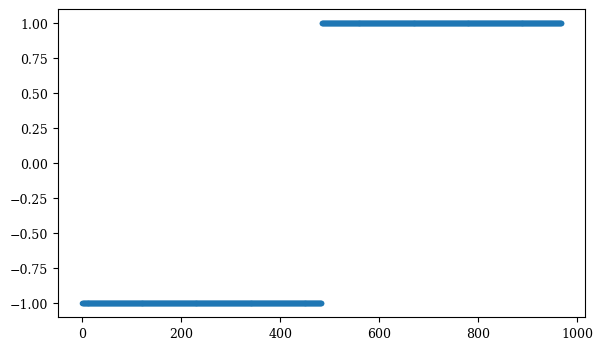

In [23]:
plt.plot(torch.linalg.eigvalsh(gtn2_torch_0_list[0].C_m/1j).cpu(),'.')

In [80]:
del plot_eigvals

In [75]:
def plot_eigvals(C_m_,ax=None):
    if ax is None:
        fig,ax=plt.subplots(figsize=(4,3))
    # C_m_=gtn2_torch_0_list[0].C_m_selfaverage()
    C_m_t=C_m_[:gtn2_torch_0_list[0].L*2,:gtn2_torch_0_list[0].L*2]
    C_m_b=C_m_[gtn2_torch_0_list[0].L*2:,gtn2_torch_0_list[0].L*2:]

    eigval_t=torch.linalg.eigvalsh(C_m_t/1j)
    eigval_b=torch.linalg.eigvalsh(C_m_b/1j)
    eigvals=torch.stack([eigval_t,eigval_b])
    eigvals=torch.concat([eigval_t,eigval_b])
    color_list = np.array(['b']*eigval_t.shape[0]+['r']*eigval_b.shape[0])
    order=eigvals.argsort()
    color_list=color_list[order.cpu()]
    eigvals_s=eigvals[order].cpu()
    ax.plot(torch.linalg.eigvalsh(C_m_/1j).cpu(),'.',color='gray')
    ax.scatter(np.arange((eigvals_s).shape[0]),eigvals_s.cpu(),color=color_list)
    ax.set_xlabel('index')
    ax.set_ylabel('Eigenvalues')

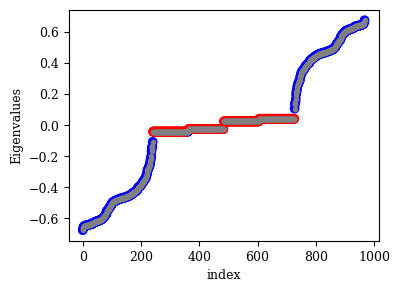

In [85]:
plot_eigvals(gtn2_torch_0p4_list[0].C_m_selfaverage())

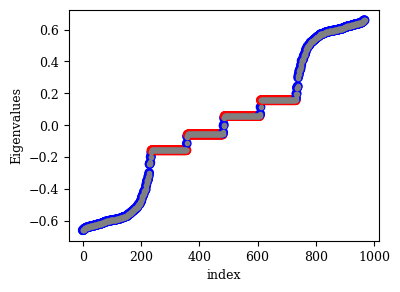

In [86]:
plot_eigvals(gtn2_torch_0p4_list[1].C_m_selfaverage())

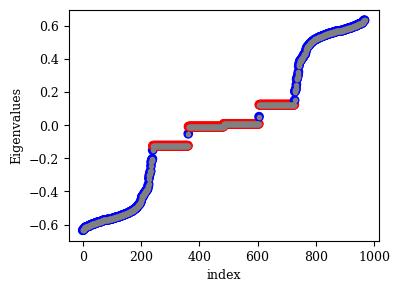

In [88]:
plot_eigvals(gtn2_torch_0p4_list[2].C_m_selfaverage())

In [87]:
C_m_0p4=sum([gtn.C_m_selfaverage() for gtn in gtn2_torch_0p4_list])/len(gtn2_torch_0p4_list)

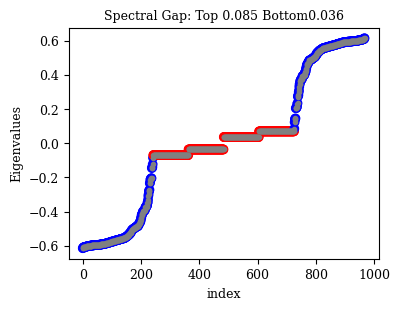

In [93]:
plot_eigvals(C_m_0p4)

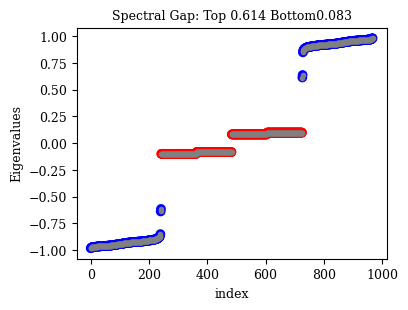

In [103]:
C_m_0p1=sum([gtn.C_m_selfaverage() for gtn in gtn2_torch_0p1_list])/len(gtn2_torch_0p1_list)
plot_eigvals(C_m_0p1)

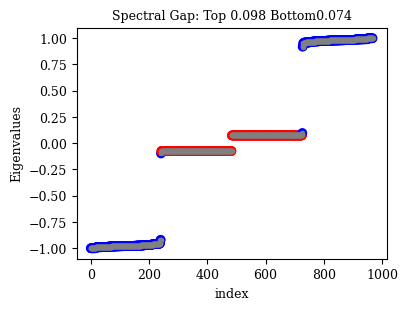

In [102]:
C_m_0=sum([gtn.C_m_selfaverage() for gtn in gtn2_torch_0_list])/len(gtn2_torch_0_list)
plot_eigvals(C_m_0)

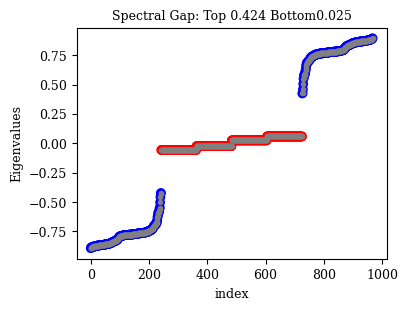

In [104]:
C_m_0p2=sum([gtn.C_m_selfaverage() for gtn in gtn2_torch_0p2_list])/len(gtn2_torch_0p2_list)
plot_eigvals(C_m_0p2)

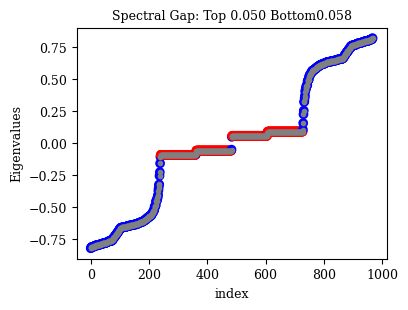

In [105]:
C_m_0p3=sum([gtn.C_m_selfaverage() for gtn in gtn2_torch_0p3_list])/len(gtn2_torch_0p3_list)
plot_eigvals(C_m_0p3)

In [138]:
gtn2=gtn2_torch_0p1_list[1]

In [139]:
C_m_=gtn2.C_m.reshape((gtn2.replica, gtn2.layer, gtn2.Lx*gtn2.Ly,gtn2.orbit,2) * 2).cpu().numpy()

In [140]:
C_m_sum_=np.zeros_like(C_m_)

for shift in range(L):
    # idx = (np.arange(L)+shift)%L
    C_m_sum_+=np.roll(C_m_,shift,axis = (2,7))
C_m_sum_/=L
C_m_sum_=C_m_sum_.reshape(gtn2.C_m.shape)

In [141]:
gtn2.C_m_selfaverage().cpu().numpy()

array([[-1.62341715e-10,  4.61585806e-01,  5.27386850e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.61585806e-01, -1.62341463e-10, -5.63850243e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.27386932e-03,  5.63848902e-04, -1.11682584e-10, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  9.09090850e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -9.09090850e-02,  0.00000000e+00]])

In [144]:
purify(gtn2.C_m_selfaverage().cpu())

tensor([[ 0.0000e+00,  5.2902e-01,  5.8071e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-5.2902e-01,  0.0000e+00, -2.8080e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-5.8071e-03,  2.8080e-03,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.6267e-17,  3.0911e-17],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.6267e-17,
          0.0000e+00,  1.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.0911e-17,
         -1.0000e+00,  0.0000e+00]], dtype=torch.float64)

In [142]:
C_m_sum_

array([[-1.09723500e-16,  4.61585818e-01,  5.27386906e-03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.61585818e-01,  1.41815884e-16, -5.63849575e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.27386906e-03,  5.63849575e-04,  1.10635215e-16, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  9.09090909e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -9.09090909e-02,  0.00000000e+00]])

In [148]:
np.abs(purify(gtn2.C_m_selfaverage().cpu())-purify(torch.from_numpy(C_m_sum_))).max()

tensor(1.5177e-08, dtype=torch.float64)

In [ ]:
np.abs(gtn2.C_m_selfaverage().cpu().numpy()-C_m_sum_).max()

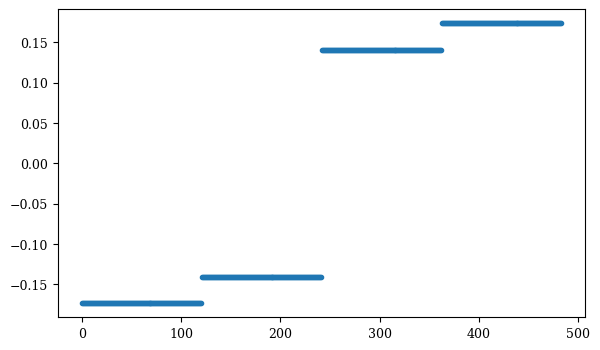

In [28]:
plt.plot(torch.linalg.eigvalsh(gtn2_torch_0_list[0].C_m_selfaverage()[gtn2_torch_0_list[0].L*2:,gtn2_torch_0_list[0].L*2:]/1j).cpu(),'.')

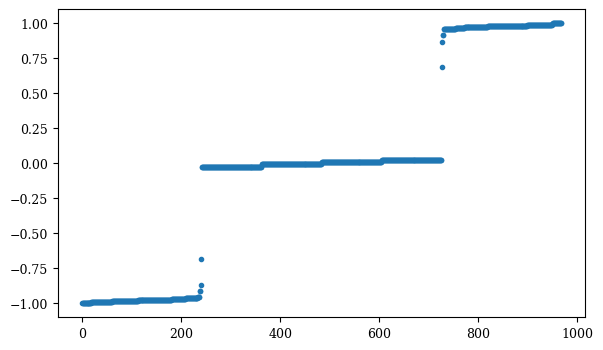

In [32]:
plt.plot(torch.linalg.eigvalsh(gtn2_torch_0_list[1].C_m_selfaverage()/1j).cpu(),'.')

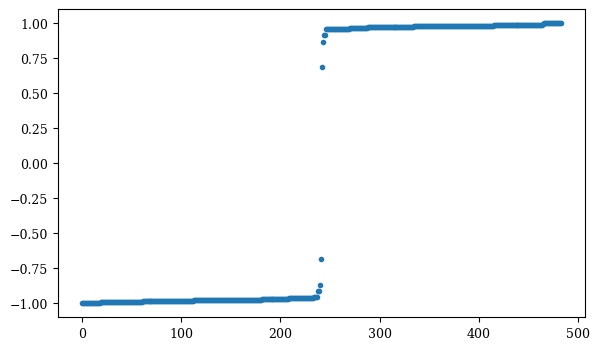

In [33]:
plt.plot(torch.linalg.eigvalsh(gtn2_torch_0_list[1].C_m_selfaverage()[:gtn2_torch_0_list[0].L*2,:gtn2_torch_0_list[0].L*2]/1j).cpu(),'.')

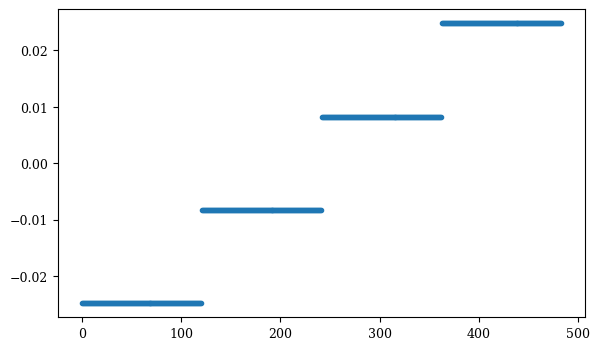

In [34]:
plt.plot(torch.linalg.eigvalsh(gtn2_torch_0_list[1].C_m_selfaverage()[gtn2_torch_0_list[0].L*2:,gtn2_torch_0_list[0].L*2:]/1j).cpu(),'.')

In [160]:
gtn2_torch_list[0].C_m[:4,:4]

tensor([[-1.1217e-16,  4.9264e-01,  2.3673e-03, -1.6354e-03],
        [-4.9264e-01, -9.9044e-17,  1.6354e-03,  2.3673e-03],
        [-2.3673e-03, -1.6354e-03, -1.9043e-16, -4.9418e-01],
        [ 1.6354e-03, -2.3673e-03,  4.9418e-01, -2.1854e-16]], device='cuda:0',
       dtype=torch.float64)

In [161]:
gtn2_torch_list[0].C_m_selfaverage()[:4,:4]

tensor([[ 2.1223e-12,  4.9258e-01,  1.5594e-03, -1.4714e-03],
        [-4.9258e-01,  2.1223e-12,  1.4714e-03,  1.5594e-03],
        [-1.5594e-03, -1.4715e-03,  1.1211e-12, -4.9258e-01],
        [ 1.4715e-03, -1.5594e-03,  4.9258e-01,  1.1211e-12]], device='cuda:0',
       dtype=torch.float64)

In [162]:
gtn2_torch_list[1].C_m[:4,:4]

tensor([[ 2.6524e-16,  4.9181e-01,  9.1238e-04,  1.2984e-04],
        [-4.9181e-01,  9.0905e-17, -1.2984e-04,  9.1238e-04],
        [-9.1238e-04,  1.2984e-04,  6.5246e-17, -5.0355e-01],
        [-1.2984e-04, -9.1238e-04,  5.0355e-01, -5.9988e-17]], device='cuda:0',
       dtype=torch.float64)

In [163]:
gtn2_torch_list[1].C_m_selfaverage()[:4,:4]

tensor([[ 2.2546e-12,  4.9186e-01, -3.7618e-04,  5.8536e-04],
        [-4.9186e-01,  2.2546e-12, -5.8536e-04, -3.7618e-04],
        [ 3.7618e-04,  5.8536e-04, -1.2704e-11, -5.0075e-01],
        [-5.8536e-04,  3.7618e-04,  5.0075e-01, -1.2704e-11]], device='cuda:0',
       dtype=torch.float64)

In [117]:
# z=torch.tensor([[1,2],[-2,4]])
# z=torch.tensor([[0,1],[-1,0]])
z=torch.zeros((6,6))
z[0,1]=z[2,3]=z[4,5]=1
z=z-z.T
# z=torch.diag(torch.tensor([1,2,3]))

In [118]:
zz=z.reshape((3,2,3,2))

In [124]:
# kernel = torch.ones((3,3))/9
kernel = torch.eye(3).reshape((3,1,3,1))/3

In [125]:
kernel.shape

torch.Size([3, 1, 3, 1])

In [126]:
torch.fft.fft2(kernel)

tensor([[[[ 0.3333+0.0000j],
          [ 0.3333+0.0000j],
          [ 0.3333+0.0000j]]],


        [[[ 0.3333+0.0000j],
          [-0.1667-0.2887j],
          [-0.1667+0.2887j]]],


        [[[ 0.3333+0.0000j],
          [-0.1667+0.2887j],
          [-0.1667-0.2887j]]]])

In [131]:
(torch.fft.ifft2(torch.fft.fft2(zz,dim=(0,2))*torch.fft.fft2(kernel,dim=(0,2)),dim=(0,2)).reshape((6,6)).real)

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [-1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
          2.9802e-08],
        [ 0.0000e+00,  0.0000e+00, -1.0000e+00,  0.0000e+00, -2.9802e-08,
          0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  2.9802e-08,  0.0000e+00,
          1.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -2.9802e-08,  0.0000e+00, -1.0000e+00,
          0.0000e+00]])

In [18]:
gtn2_torch_list[0].c2g(range(gtn2_torch_list[0].Lx),range(gtn2_torch_list[0].Ly))

tensor([   0,    1,    2,  ..., 1797, 1798, 1799], device='cuda:0')

In [15]:
nu_list = [gtn2.chern_number_quick(selfaverage=True) for gtn2 in gtn2_torch_list]

In [16]:
nu_list

[tensor(-0.9892, device='cuda:0', dtype=torch.float64),
 tensor(-0.9681, device='cuda:0', dtype=torch.float64)]

In [39]:
C_m_ave=torch.stack([gtn2.C_m for gtn2 in gtn2_torch_list]).mean(dim=0)

In [18]:
from copy import copy

In [19]:
gtn2_dummy=copy(gtn2_torch_list[0])

In [20]:
gtn2_dummy.C_m=C_m_ave
gtn2_dummy.chern_number_quick(selfaverage=True)

tensor(-0.9766, device='cuda:0', dtype=torch.float64)

In [21]:
torch.tensor(nu_list).mean()

tensor(-0.9786, dtype=torch.float64)

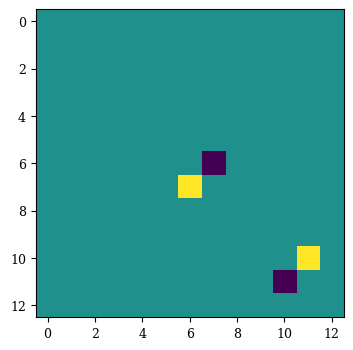

In [43]:
plt.imshow(C_m_ave.cpu()[gtn2_torch_list[0].L*2:gtn2_torch_list[0].L*2+13,gtn2_torch_list[0].L*2:gtn2_torch_list[0].L*2+13])

In [17]:
def ensemble_average(C_m_list,n=2):
    """ ensemble average of Gamma_ij^n"""
    C_m_ave=torch.stack(C_m_list)
    return (C_m_ave**2).mean(dim=0)


In [28]:
def correlation_length(C_m,replica,layer,Lx,Ly,):
    D=(replica,layer,Lx,Ly,2,2)
    C_ij=C_m.reshape(D+D)[0,0,:,:,:,:,0,0,:,:,:,:].mean(dim=(2,3,6,7))
    Cr_i=torch.stack([C_ij[i,j,(i+torch.arange(Lx//2)+1)%Lx,j].cpu() for i in range(Lx) for j in range(Ly)]).mean(dim=0)
    Cr_j=torch.stack([C_ij[i,j,i,(j+torch.arange(Ly//2)+1)%Ly].cpu() for i in range(Lx) for j in range(Ly)]).mean(dim=0)
    c_ij=C_m.reshape(D+D)[0,1,:,:,:,:,0,1,:,:,:,:].mean(dim=(2,3,6,7))
    cr_i=torch.stack([c_ij[i,j,(i+torch.arange(Lx//2)+1)%Lx,j].cpu() for i in range(Lx) for j in range(Ly)]).mean(dim=0)
    cr_j=torch.stack([c_ij[i,j,i,(j+torch.arange(Ly//2)+1)%Ly].cpu() for i in range(Lx) for j in range(Ly)]).mean(dim=0)
    return Cr_i,Cr_j,cr_i,cr_j

In [19]:
C_m_mod = ensemble_average([gtn2.C_m for gtn2 in gtn2_torch_list])

In [20]:
C_m_mod_cpu = C_m_mod.cpu()

In [21]:
C_m_mod_cpu

tensor([[4.1469e-32, 2.4229e-01, 3.2183e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.4229e-01, 9.0368e-33, 1.3457e-06,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.2183e-06, 1.3457e-06, 2.0261e-32,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         0.0000e+00]], dtype=torch.float64)

In [32]:
Cr_i,Cr_j,cr_i,cr_j  =correlation_length(C_m_mod,replica=1,layer=2,Lx=15,Ly=15)

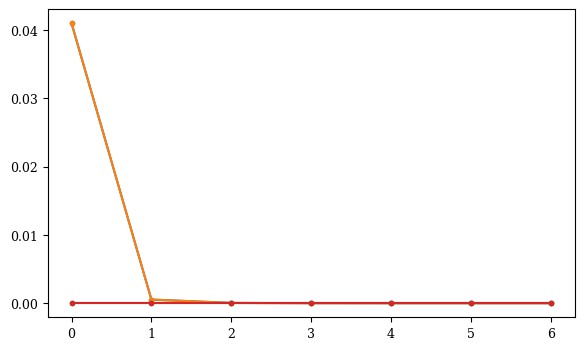

In [37]:
plt.plot(Cr_i.cpu(),'.-')
plt.plot(Cr_j.cpu(),'.-')
plt.plot(cr_i.cpu(),'.-')
plt.plot(cr_j.cpu(),'.-')
# plt.xscale('log')
# plt.yscale('log')

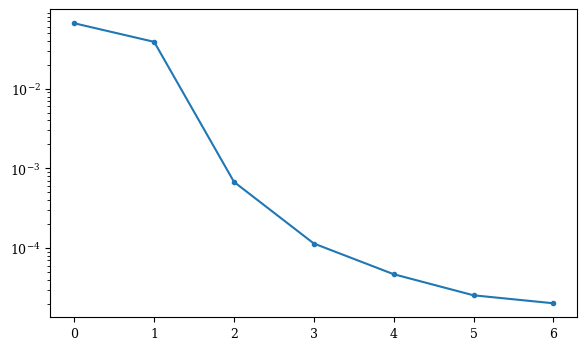

In [156]:
# plt.xscale('log')
plt.yscale('log')

In [92]:
C_m_mod=torch.stack([gtn2.C_m**2 for gtn2 in gtn2_torch_list]).mean(dim=0)

In [93]:
D=(gtn2_dummy.replica,gtn2_dummy.layer,gtn2_dummy.Lx,gtn2_dummy.Ly,gtn2_dummy.orbit,2)
C_m_mod_=C_m_mod.reshape(D+D)

In [94]:
C_m_mod_.shape

torch.Size([1, 2, 15, 15, 2, 2, 1, 2, 15, 15, 2, 2])

In [95]:
C_m_mod_slice=C_m_mod_[0,0,:,:,:,:,0,0,:,:,:,:]

In [103]:
C_ij = torch.mean(C_m_mod_slice,dim=(2,3,6,7))

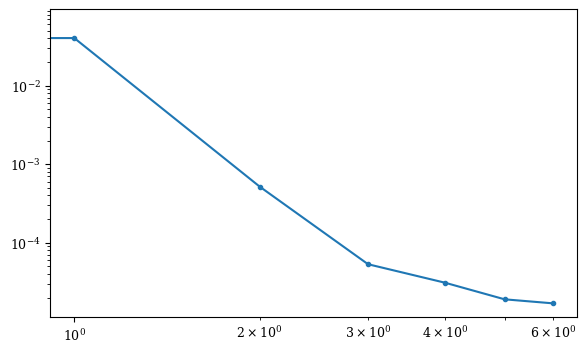

In [178]:
plt.plot(C_ij[0,0,0,:7].cpu(),'.-')
plt.xscale('log')
plt.yscale('log')

In [111]:
gtn2_dummy.Lx//2

7

In [122]:
Cr=torch.stack([C_ij[i,j,i,(j+torch.arange(gtn2_dummy.Lx//2))%gtn2_dummy.Lx].cpu() for i in range(gtn2_dummy.Lx) for j in range(gtn2_dummy.Ly)]).mean(dim=0)

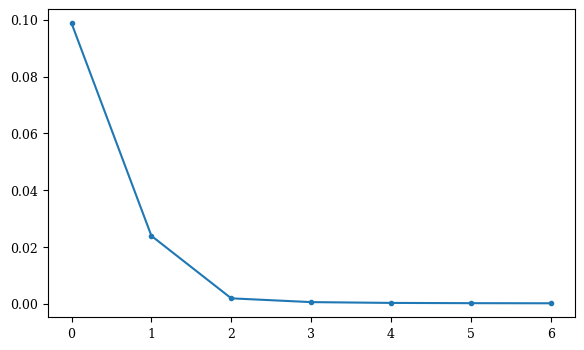

In [179]:
plt.plot(Cr,'.-')
# plt.xscale('log')
# plt.yscale('log')

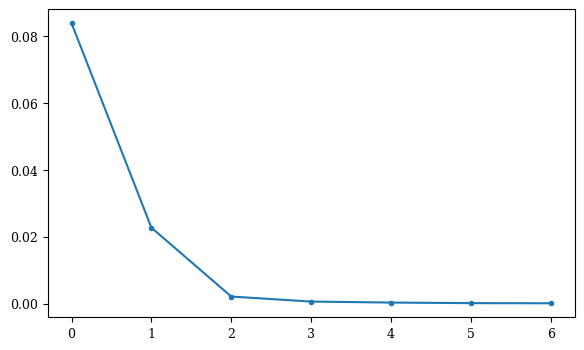

In [118]:
i,j=0,2
plt.plot(C_ij[i,j,i,(j+torch.arange(gtn2_dummy.Lx//2))%gtn2_dummy.Lx].cpu(),'.-')

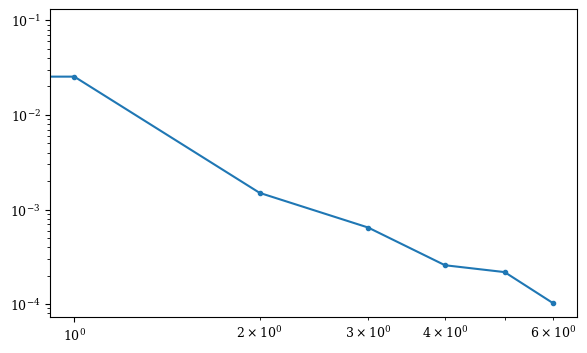

In [109]:
plt.plot(C_ij[1,0,1,:7].cpu(),'.-')
plt.xscale('log')
plt.yscale('log')

In [2]:
import torch

In [19]:
zz=torch.load('class_A_2D_Lx11_Ly33_nshell5_mu1.00_sigma0.000_es2_seed0_EE_SA.pt',map_location='cpu')

/tmp/ipykernel_55879/714340020.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  zz=torch.load('class_A_2D_Lx11_Ly33_nshell5_mu1.00_sigma0.000_es2_seed0_EE_SA.pt',map_loca

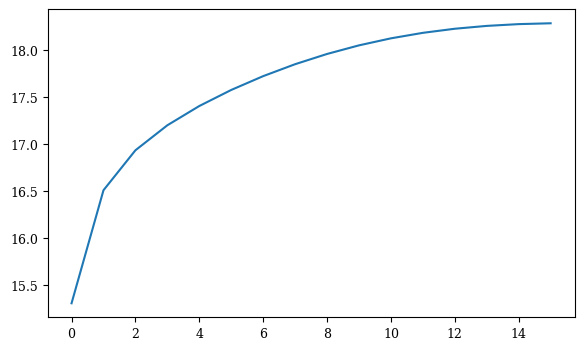

In [11]:
plt.plot(zz['SA'][0])

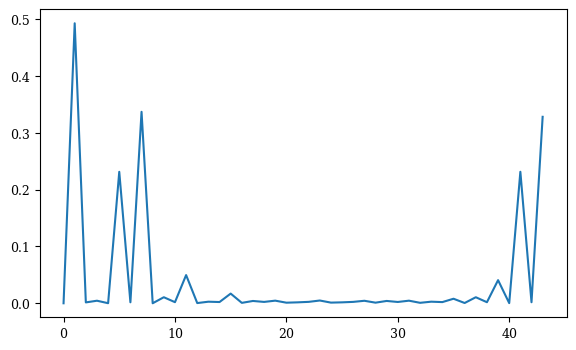

In [124]:
plt.plot(torch.abs(gtn2_torch.C_m[0,:4*gtn2_torch.Lx]).cpu().numpy())

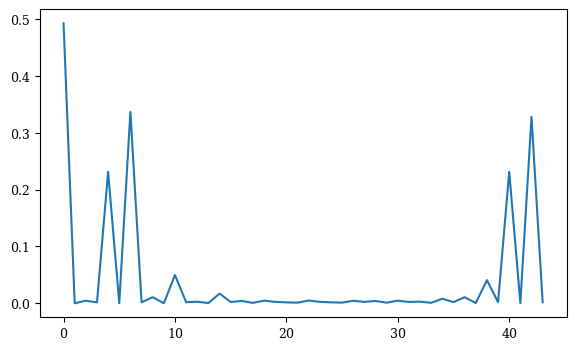

In [125]:
plt.plot(torch.abs(gtn2_torch.C_m[1,:4*gtn2_torch.Lx]).cpu().numpy())

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
        0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

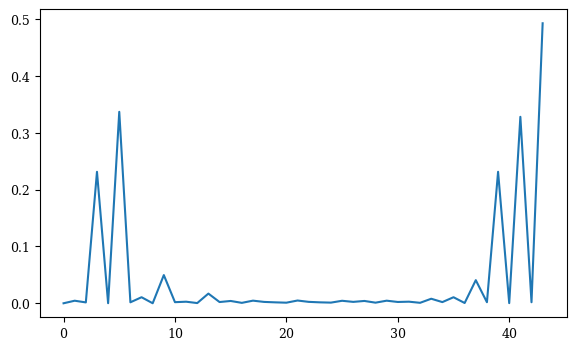

In [136]:
i0=1

[torch.abs(gtn2_torch.C_m[i0,np.arange(i0,i0+4*gtn2_torch.Lx)%(4*gtn2_torch.Lx)]).cpu().numpy() for i0 in range(0,4*gtn2_torch.Lx,4)]
plt.plot()

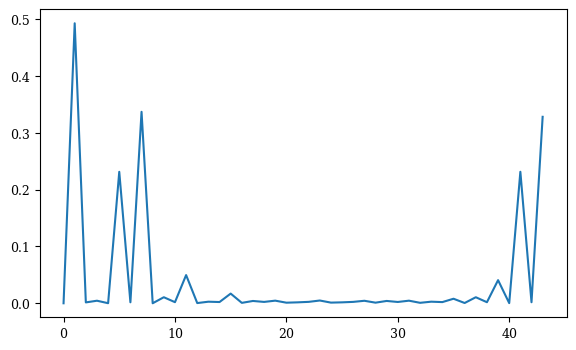

In [140]:
i0=0
plt.plot(torch.abs(gtn2_torch.C_m[i0,np.arange(i0,i0+4*gtn2_torch.Lx)%(4*gtn2_torch.Lx)]).cpu().numpy())

In [72]:
gtn2_torch.half_cut_entanglement_entropy(selfaverage=True)

tensor([9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948,
        9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948,
        9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948,
        9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948,
        9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948,
        9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948,
        9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948,
        9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948,
        9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948,
        9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948,
        9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948,
        9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948, 9.5948,
        9.5948, 9.5948, 9.5948, 9.5948, 

In [107]:
L_list = range(7,19,2)
nu_0_list=torch.zeros(len(L_list),1)
EE_0_list=torch.zeros(len(L_list),1)
for L_idx,L in enumerate(L_list):
    for seed in range(1):
        nu,EE=run(L,seed)
        nu_0_list[L_idx,seed]=nu
        EE_0_list[L_idx,seed]=EE

Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  1.85it/s]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|████████████████████████████████████████████████████████| 9/9 [00:07<00:00,  1.14it/s]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 11/11 [00:14<00:00,  1.28s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 13/13 [00:23<00:00,  1.79s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 15/15 [00:36<00:00,  2.46s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 17/17 [00:59<00:00,  3.52s/it]


/tmp/ipykernel_17193/1219967575.py:1: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  plt.errorbar(L_list,EE_0_list.mean(axis=1),yerr=EE_0_list.std(axis=1)/np.sqrt(EE_0_list.shape[0]),capsize=3,fmt='.-')


<ErrorbarContainer object of 3 artists>

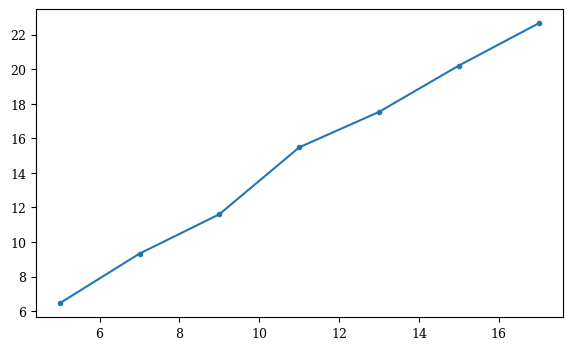

In [104]:
plt.errorbar(L_list,EE_0_list.mean(axis=1),yerr=EE_0_list.std(axis=1)/np.sqrt(EE_0_list.shape[0]),capsize=3,fmt='.-')
# /torch.tensor(L_list)

/tmp/ipykernel_17193/1219967575.py:1: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  plt.errorbar(L_list,EE_0_list.mean(axis=1),yerr=EE_0_list.std(axis=1)/np.sqrt(EE_0_list.shape[0]),capsize=3,fmt='.-')


<ErrorbarContainer object of 3 artists>

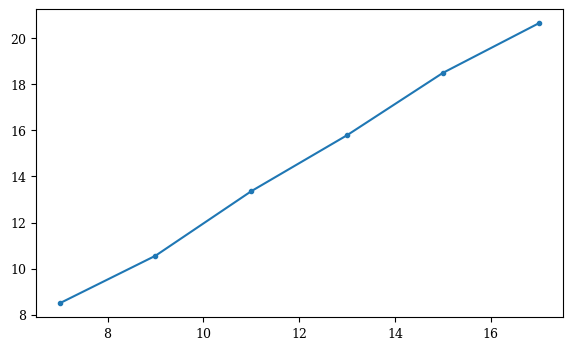

In [110]:
plt.errorbar(L_list,EE_0_list.mean(axis=1),yerr=EE_0_list.std(axis=1)/np.sqrt(EE_0_list.shape[0]),capsize=3,fmt='.-')
# /torch.tensor(L_list)

In [ ]:
plt.errorbar(L_list,EE_list.mean(axis=1),yerr=EE_list.std(axis=1),capsize=3)
# /torch.tensor(L_list)

In [42]:
L_list = range(11,19,2)
nu_list=torch.zeros(len(L_list),1)
EE_list=torch.zeros(len(L_list),1)
for L_idx,L in enumerate(L_list):
    for seed in range(1):
        nu,EE=run(L,seed)
        nu_list[L_idx,seed]=nu
        EE_list[L_idx,seed]=EE

Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.10s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.10s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.09s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.09s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 11/11 [00:11<00:00,  1.09s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 13/13 [00:19<00:00,  1.51s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 13/13 [00:19<00:00,  1.51s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 13/13 [00:19<00:00,  1.51s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 13/13 [00:19<00:00,  1.51s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 13/13 [00:19<00:00,  1.51s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.07s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.07s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 15/15 [00:30<00:00,  2.06s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.07s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 15/15 [00:31<00:00,  2.07s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 17/17 [00:51<00:00,  3.00s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 17/17 [00:51<00:00,  3.01s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 17/17 [00:51<00:00,  3.00s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 17/17 [00:50<00:00,  3.00s/it]


Using cuda
GPU Model: NVIDIA A100-PCIE-40GB


100%|██████████████████████████████████████████████████████| 17/17 [00:51<00:00,  3.01s/it]


In [43]:
nu_list

tensor([[-0.7377, -0.7377, -0.7776, -0.5145, -0.7372],
        [-0.7472, -0.6191, -0.5311, -0.5956, -0.5240],
        [-0.5204, -0.8932, -0.7887, -0.7440, -0.5749],
        [-0.7433, -0.5115, -0.7345, -0.5144, -0.5306]])

In [46]:
nu_list.mean(axis=1)

tensor([-0.7009, -0.6034, -0.7042, -0.6069])

In [44]:
EE_list.mean(axis=1)

tensor([[14.6599, 14.6617, 14.6746, 15.2232, 14.6700],
        [17.3178, 17.7213, 17.9127, 17.7733, 17.9282],
        [20.5745, 19.6486, 19.9529, 19.9873, 20.4947],
        [22.6379, 23.2556, 22.6677, 23.2484, 23.2249]])

<ErrorbarContainer object of 3 artists>

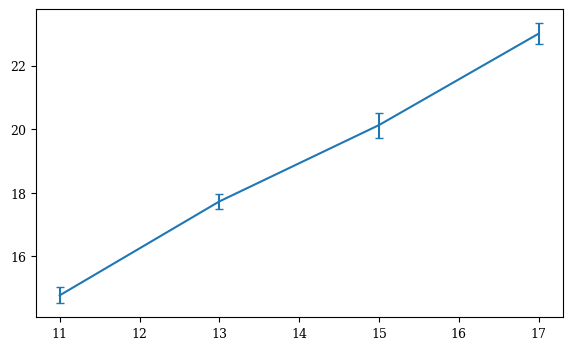

In [58]:
plt.errorbar(L_list,EE_list.mean(axis=1),yerr=EE_list.std(axis=1),capsize=3)
# /torch.tensor(L_list)

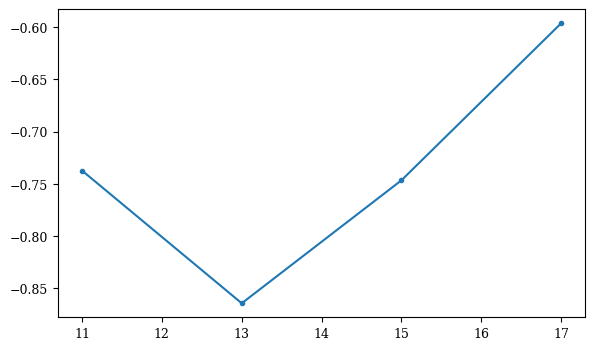

In [31]:
plt.plot(L_list,nu_list,'.-')

In [24]:
nu_list =[]
gtn2_list=[]
for seed in range(10):
    nu,TMI,C_m=run(seed)
    nu_list.append(nu)
    # C_m_list.append(C_m)
    gtn2_list.append(gtn2_torch)
    

Using cuda
GPU Model: NVIDIA L40S


100%|██████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.11s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|██████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.11s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|██████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.11s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|██████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.11s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|██████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.11s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|██████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.11s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|██████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.11s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|██████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.11s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|██████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.11s/it]


Using cuda
GPU Model: NVIDIA L40S


100%|██████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.11s/it]


In [26]:
(nu).mean()

tensor(-0.9186, dtype=torch.float64)

In [29]:
torch.stack(C_m_list).mean(axis=0)

tensor([[ 2.6627e-16,  4.9470e-01, -3.9564e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-4.9470e-01, -7.5125e-16,  3.4805e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.9564e-03, -3.4805e-04,  7.7484e-16,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -1.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.0000e+00,  0.0000e+00]], device='cuda:0', dtype=torch.float64)

In [30]:
gtn2_dummy=GTN2_torch(Lx=11,Ly=11,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=2,complex128=True)
gtn2_dummy.C_m=torch.stack(C_m_list).mean(axis=0)

Using cuda
GPU Model: NVIDIA L40S


In [34]:
gtn2_dummy.chern_number_quick(selfaverage=True)

tensor(-0.9186, dtype=torch.float64)

In [37]:
nu,gtn2=run(0)

Using cuda
GPU Model: NVIDIA L40S


 18%|██████████                                             | 2/11 [00:02<00:11,  1.31s/it]

100%|██████████████████████████████████████████████████████| 11/11 [00:12<00:00,  1.13s/it]


In [39]:
from copy import copy

In [42]:
gtn2.chern_number_quick()

tensor(-0.9210, device='cuda:0', dtype=torch.float64)

In [139]:
gtn2_1=copy(gtn2)

In [140]:
gtn2_1.chern_number_quick()

tensor(-0.9210, device='cuda:0', dtype=torch.float64)

In [141]:
nu_list=[]
C_m_list=[]
for i in tqdm(range(500)):
    # gtn2_1.randomize([0,1])
    randomize_inter(gtn2_1)
    nu_list.append(gtn2_1.chern_number_quick())
    C_m_list.append(gtn2_1.C_m.clone())


100%|████████████████████████████████████████████████████| 500/500 [03:03<00:00,  2.73it/s]


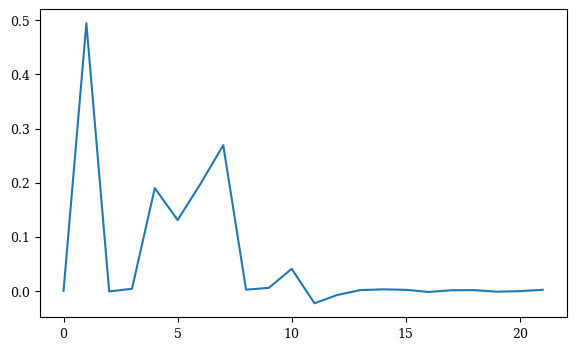

In [142]:
plt.plot(C_m_list[2][0,:2*gtn2.Lx].cpu().numpy())

In [143]:
C_m_mean = torch.stack(C_m_list).mean(axis=0)



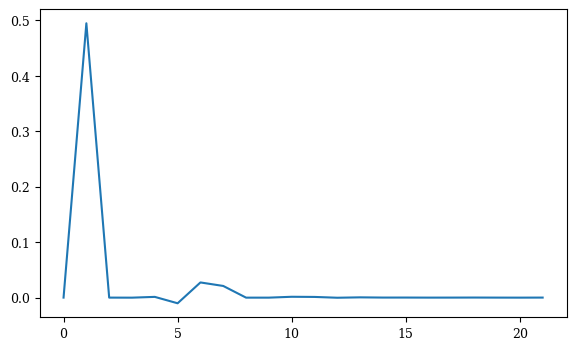

In [144]:
plt.plot(C_m_mean[0,:2*gtn2.Lx].cpu().numpy())

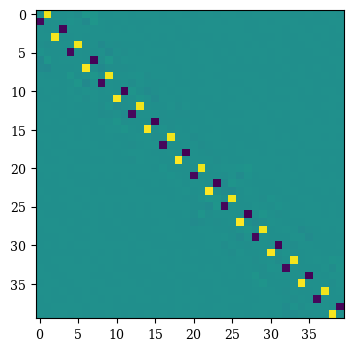

In [145]:
plt.imshow(C_m_mean[:40,:40].cpu().numpy())

In [146]:
C_m_mean@C_m_mean

tensor([[-2.4738e-01, -6.2665e-16, -3.0986e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 5.7464e-16, -2.4738e-01,  3.1913e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.0986e-04,  3.1913e-04, -2.5363e-01,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -1.0000e+00,  1.4517e-15],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -1.4517e-15, -1.0000e+00]], device='cuda:0', dtype=torch.float64)

In [ ]:
nu_list

In [147]:
gtn2_dummy=GTN2_torch(Lx=11,Ly=11,history=False,random_init=True,random_U1=True,bcx=1,bcy=1,seed=0,orbit=2,nshell=2,layer=2,complex128=True)
gtn2_dummy.C_m=C_m_mean

Using cuda
GPU Model: NVIDIA L40S


In [148]:
gtn2_dummy.chern_number_quick(selfaverage=True)

tensor(-4.4190e-06, dtype=torch.float64)

In [67]:
gtn2_1.randomize([0,1])

In [70]:
randomize_inter(gtn2_1)

In [72]:
gtn2_1.chern_number_quick()

tensor(-0.9210, device='cuda:0', dtype=torch.float64)

In [71]:
gtn2_1.C_m[:4,:4]

tensor([[ 6.2955e-16,  4.9470e-01,  2.6169e-03,  2.9877e-03],
        [-4.9470e-01, -1.1545e-15, -2.9877e-03,  2.6169e-03],
        [-2.6169e-03,  2.9877e-03,  7.7484e-16, -5.0214e-01],
        [-2.9877e-03, -2.6169e-03,  5.0214e-01, -1.6106e-15]], device='cuda:0',
       dtype=torch.float64)

In [66]:
gtn2.C_m[:4,:4]

tensor([[ 2.6627e-16,  4.9470e-01, -3.9564e-03, -3.4805e-04],
        [-4.9470e-01, -7.5125e-16,  3.4805e-04, -3.9564e-03],
        [ 3.9564e-03, -3.4805e-04,  7.7484e-16, -5.0214e-01],
        [ 3.4805e-04,  3.9564e-03,  5.0214e-01, -1.6106e-15]], device='cuda:0',
       dtype=torch.float64)

In [ ]:
rs_map=[run(mu) for mu in np.linspace(1,2.2,13)]

In [ ]:
rs1_map=torch.tensor([run(mu) for mu in np.linspace(1,2.2,13)])


In [106]:
rs1_map=torch.tensor(rs1_map)

In [97]:
nu_list=torch.tensor(rs_map)[:,0]
TMI_list=torch.tensor(rs_map)[:,1]

In [100]:
nu_list[:,-1]

tensor([-9.7014e-01, -8.8560e-01, -8.9858e-01, -8.3329e-01, -7.2463e-01,
        -3.2060e-01, -1.8287e-01, -9.0150e-02, -3.8046e-02, -1.3570e-02,
        -3.9575e-03, -1.2005e-03, -4.5702e-04], dtype=torch.float64)

In [110]:
rs1_map.shape

torch.Size([13, 2, 16])

tensor([-0.9244, -0.9800, -0.8625, -0.6621, -0.4767, -0.3512, -0.2332, -0.1409,
        -0.0748, -0.0338, -0.0123, -0.0042, -0.0017], dtype=torch.float64)

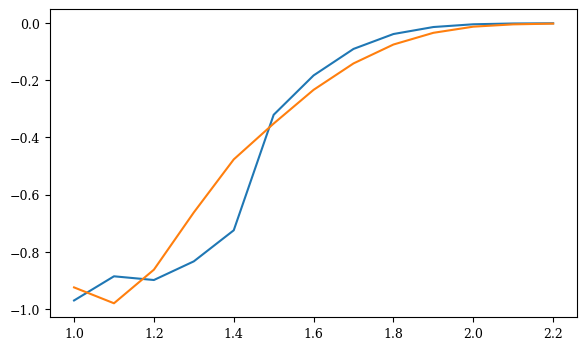

In [112]:
plt.plot(np.linspace(1,2.2,13),nu_list[:,-1])
plt.plot(np.linspace(1,2.2,13),rs1_map[:,0,-1])

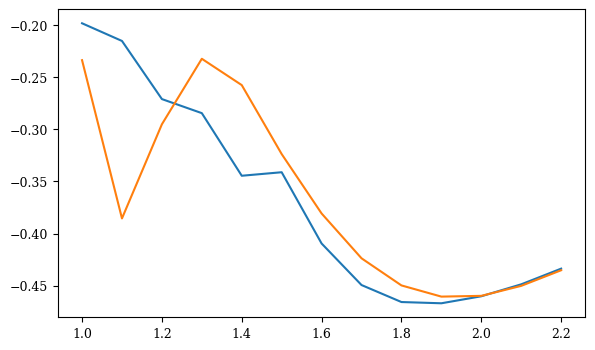

In [113]:
plt.plot(np.linspace(1,2.2,13),TMI_list[:,-1])
plt.plot(np.linspace(1,2.2,13),rs1_map[:,1,-1])

In [56]:
torch.tensor(nu_map).mean(axis=0)

tensor([ 0.0000, -0.0577, -0.3359, -0.5416, -0.6709, -0.7493, -0.8188, -0.8519,
        -0.9151, -0.9273, -0.9432, -0.9394, -0.9487, -0.9542, -0.9603, -0.9521],
       dtype=torch.float64)

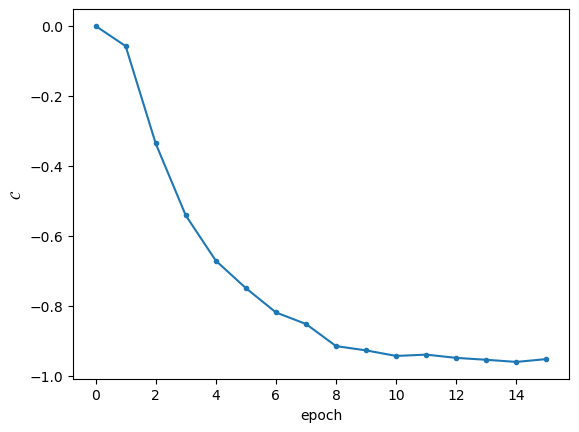

In [57]:
plot_chern(torch.tensor(nu_map).mean(axis=0))

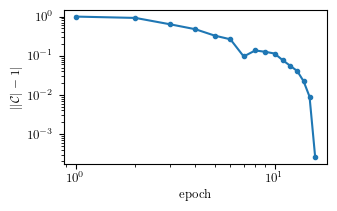

In [34]:
fig,ax=plt.subplots(figsize=(3.4,2))
plot_chern(nu_list,log=True,C=1,ax=ax)
# fig.savefig('C0C1_log.pdf',bbox_inches='tight')

In [24]:
z1=purify(z1)

In [25]:
torch.linalg.svdvals(z1)

tensor([1.0015, 1.0015, 1.0015,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0')

# Load

## Animation

In [8]:
# rs = torch.load('class_A_2D_L10_nshell2_tf10.pt', map_location='cpu')
# rs = torch.load('class_A_2D_L20_nshell2_tf30.pt', map_location='cpu')
# rs = torch.load('class_A_2D_L20_nshell2_tf100_truncate.pt', map_location='cpu')
# rs = torch.load('class_A_2D_L20_nshell3_tf100_truncate.pt', map_location='cpu')
rs = torch.load('class_A_2D_L30_nshell4_tf100_truncate.pt', map_location='cpu')
# rs = torch.load('class_A_2D_L20_nshell2_tf200_truncate.pt', map_location='cpu')
# rs = torch.load('class_A_2D_L20_nshell2_tf1000_truncate.pt', map_location='cpu')
# rs = torch.load('class_A_2D_L20_nshell2_tf50_truncate.pt', map_location='cpu')

# rs = torch.load('class_A_2D_L30_nshell2_tf40_truncate.pt', map_location='cpu')
# rs = torch.load('class_A_2D_L30_nshell2_tf30.pt', map_location='cpu')

# rs = torch.load('class_A_2D_L35_nshell2_tf50_truncate.pt', map_location='cpu')

In [ ]:
for idx in range(len(rs['C_r'])):
    fig,ax=plt.subplots(2,1)
    plot_C_r(rs['C_r'][idx][0],ax,bottomcb=False)

In [ ]:
for idx in range(len(rs['EC'])):
    fig,ax=plt.subplots(1,2,figsize=(5,2.5))
    plot_EC(rs['EC'][idx],ax=ax,vmax=None)

In [128]:
# rs= {'C_r': [x.cpu() for x in C_r_list], 'EC': [x.cpu() for x in EC_list]}

with open('L15_truncate_nshell2_30.pickle','rb') as f:
# with open('L15_overlap_nshell2_30.pickle','rb') as f:
    rs = pickle.load(f)

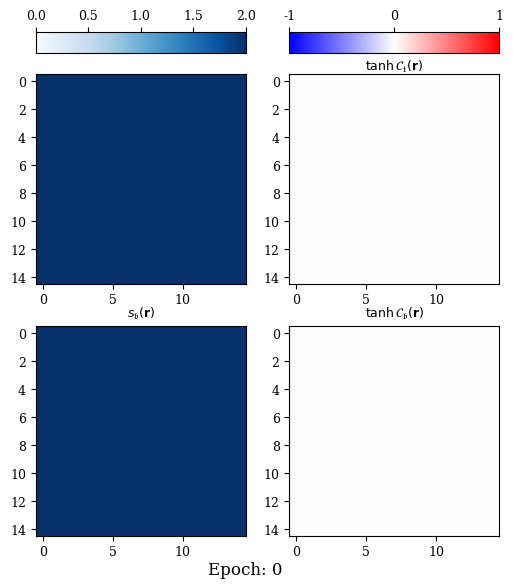

In [129]:
fig,ax=plt.subplots(2,2,figsize=(6,6),)
i=0

epoch=ax[1,0].text(1,-0.18,f'Epoch: {i}',transform=ax[1,0].transAxes,ha='center',fontsize=12)
ax_C=ax[:,1]
im0,im1,cross0,cross1=plot_C_r(rs['C_r'][i][0],ax=ax_C,bottomcb=False,)

ax_EC=ax[:,0]
EC_im0,EC_im1,EC_cross0,EC_cross1,EC_cb0,EC_cb1=plot_EC(rs['EC'][i],ax=ax_EC,bottomcb=False,vmax=None)




# fig.savefig('C_m_history.png')

In [130]:
vmax_dict={5:0.1,100:1e-2,140:1e-3,}

In [131]:
def update(frame):
    print(frame)
    im0.set_data(np.tanh(rs['C_r'][frame][0,0]))
    im1.set_data(np.tanh(rs['C_r'][frame][0,1]))
    EC_im0.set_data(rs['EC'][frame][0]/np.log(2))
    EC_im1.set_data(rs['EC'][frame][1]/np.log(2))
    epoch.set_text(f'Epoch: {frame}')
    for t,vmax in vmax_dict.items():
        if frame>t:
            EC_im0.set_clim(vmin=0,vmax=vmax)
            EC_im1.set_clim(vmin=0,vmax=vmax)
            EC_cb0.update_normal(EC_im0)
            EC_cb0.set_ticks([0,vmax])
            EC_cb0.ax.xaxis.set_ticks_position('top')
            continue
        
        


In [132]:
import matplotlib.animation as animation

In [133]:
ani = animation.FuncAnimation(
    fig, 
    update, 
    frames=range(len(rs['C_r'])),  # Generate frames from 0 to 40
    # frames=range(i,i+10),  # Generate frames from 0 to 40
    blit=False    # Blit optimizes the rendering
)

In [134]:
ani.save('L15_truncate_nshell2_30.mp4', writer='ffmpeg', fps=2,dpi=200)
# ani.save('L15_truncate_nshell2_15.gif', writer='ffmpeg', fps=3,dpi=200)
# ani.save('L20_overlap_200.mp4', writer='ffmpeg', fps=3,dpi=200)

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


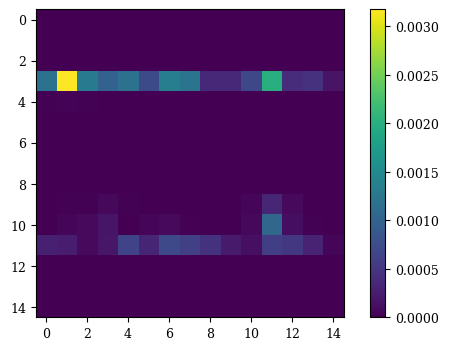

In [135]:
plt.imshow(rs['EC'][-1][0])
plt.colorbar()

Text(0, 0.5, 'sum EC over $j$')

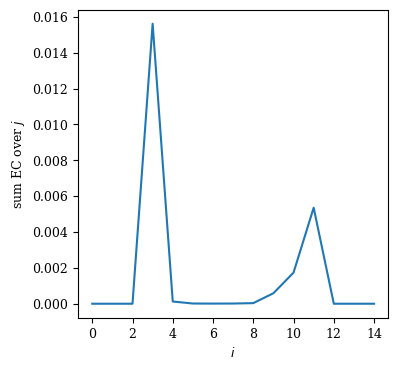

In [136]:
fig,ax=plt.subplots(figsize=(4,4))
ax.plot(rs['EC'][-1][0].sum(axis=1))
ax.set_xlabel('$i$')
ax.set_ylabel('sum EC over $j$')

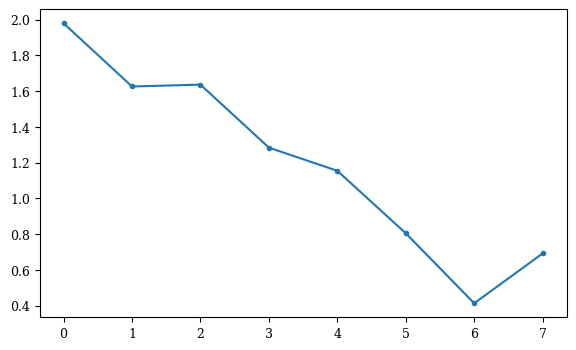

In [104]:
plt.plot([rs['EC'][x][0].sum() for x in range(len(rs['EC']))][8:],'.-')
# plt.xscale('log')
# plt.yscale('log')

In [92]:
(rs['EC'][x][0].sum(axis=1)[:].sum())

tensor(1.1540, dtype=torch.float64)

Text(0, 0.5, 'sum of EC')

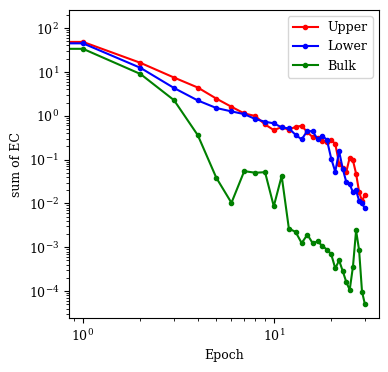

In [137]:
fig,ax=plt.subplots(figsize=(4,4))
ax.plot([rs['EC'][idx][0][:6].sum() for idx in range(len(rs['EC']))],'.-',color='r',label='Upper')
ax.plot([rs['EC'][idx][0][9:].sum() for idx in range(len(rs['EC']))],'.-',color='b',label='Lower')
ax.plot([rs['EC'][idx][0][6:9].sum() for idx in range(len(rs['EC']))],'.-',color='g',label='Bulk')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('sum of EC')
# ax[1].plot([rs['EC'][idx][0].sum(axis=1)[17:].sum() for idx in range(len(rs['EC']))])

Text(0, 0.5, 'sum of EC')

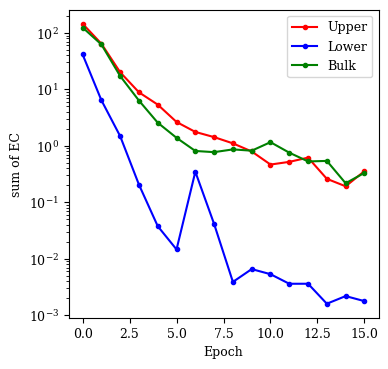

In [ ]:
fig,ax=plt.subplots(figsize=(4,4))
ax.plot([rs['EC'][idx][0][:7].sum() for idx in range(len(rs['EC']))],'.-',color='r',label='Upper')
ax.plot([rs['EC'][idx][0][13:].sum() for idx in range(len(rs['EC']))],'.-',color='b',label='Lower')
ax.plot([rs['EC'][idx][0][7:13].sum() for idx in range(len(rs['EC']))],'.-',color='g',label='Bulk')
ax.legend()
ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('sum of EC')
# ax[1].plot([rs['EC'][idx][0].sum(axis=1)[17:].sum() for idx in range(len(rs['EC']))])

Text(0, 0.5, 'sum of EC')

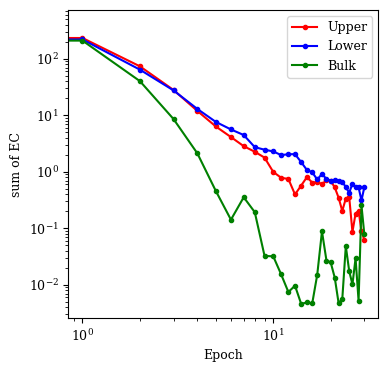

In [127]:
fig,ax=plt.subplots(figsize=(4,4))
ax.plot([rs['EC'][idx][0][:10].sum() for idx in range(len(rs['EC']))],'.-',color='r',label='Upper')
ax.plot([rs['EC'][idx][0][20:].sum() for idx in range(len(rs['EC']))],'.-',color='b',label='Lower')
ax.plot([rs['EC'][idx][0][10:20].sum() for idx in range(len(rs['EC']))],'.-',color='g',label='Bulk')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('sum of EC')
# ax[1].plot([rs['EC'][idx][0].sum(axis=1)[17:].sum() for idx in range(len(rs['EC']))])

In [64]:
rs['EC'][-1][0][:,:17].sum()

tensor(1.2193, dtype=torch.float64)

Text(0, 0.5, 'sum of EC')

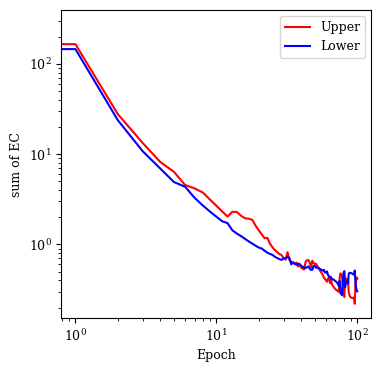

In [69]:
fig,ax=plt.subplots(figsize=(4,4))
ax.plot([rs['EC'][idx][0].sum(axis=1)[:10].sum() for idx in range(len(rs['EC']))],color='r',label='Upper')
ax.plot([rs['EC'][idx][0].sum(axis=1)[10:].sum() for idx in range(len(rs['EC']))],color='b',label='Lower')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('sum of EC')
# ax[1].plot([rs['EC'][idx][0].sum(axis=1)[17:].sum() for idx in range(len(rs['EC']))])

Text(0, 0.5, 'sum of EC')

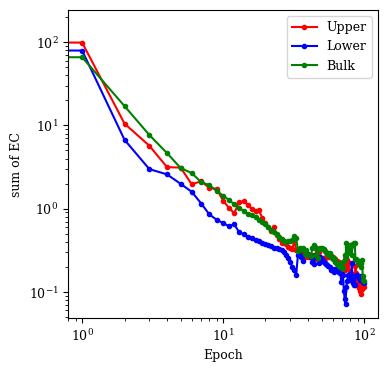

In [24]:
fig,ax=plt.subplots(figsize=(4,4))
ax.plot([rs['EC'][idx][0][:6].sum() for idx in range(len(rs['EC']))],'.-',color='r',label='Upper',)
ax.plot([rs['EC'][idx][0][14:].sum() for idx in range(len(rs['EC']))],'.-',color='b',label='Lower',)
ax.plot([rs['EC'][idx][0][6:14].sum()/2. for idx in range(len(rs['EC']))],'.-',color='g',label='Bulk',)
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('sum of EC')
# ax[1].plot([rs['EC'][idx][0].sum(axis=1)[17:].sum() for idx in range(len(rs['EC']))])

## Critical phase

In [27]:
def get_mean_std(rs,L_list):
    mean_list=[]
    sem_list=[]
    x_list=[]
    for L in L_list:
        n= (L-1)//2-1
        print(L,n)
        if (L,n) in rs:
            data = torch.tensor(rs[(L,n)]['EE'])
            mean_list.append(data.mean(axis=0)[-1].item())
            sem_list.append(data.std(axis=0)[-1].item()/np.sqrt(data.shape[0]))
            x_list.append(L)
    return np.array(x_list),np.array(mean_list),np.array(sem_list)
    
            


    

In [28]:
rs_crit ={}
L_list = range(5,23,2)
mu_list = [2.]
for mu in mu_list:
    for L in L_list:
        nshell_list = range(1,(L-1)//2)
        for nshell in nshell_list:
            try:
                rs_crit[(L,nshell)] = torch.load(f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_es10.pt', map_location='cpu')
            except:
                try:
                    rs_crit[(L,nshell)] = torch.load(f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_es5.pt', map_location='cpu')
                except:
                    pass


/tmp/ipykernel_238836/1815836953.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rs_crit[(L,nshell)] = torch.load(f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_es10.pt', m

In [29]:
rs_crit.keys()

dict_keys([(5, 1), (7, 1), (7, 2), (9, 1), (9, 2), (9, 3), (11, 1), (11, 2), (11, 3), (11, 4), (13, 1), (13, 2), (13, 3), (13, 4), (13, 5), (15, 1), (15, 2), (15, 3), (15, 4), (15, 5), (15, 6), (17, 1), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (19, 1), (19, 2), (19, 3), (19, 4), (19, 5), (19, 6), (19, 7), (21, 1), (21, 2), (21, 3), (21, 4), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9)])

In [30]:
L=11

np.array([(n,torch.tensor(rs_crit[(L,n)]['EE']).mean(axis=0)[-1].item()) for n in range(1,(L-1)//2) if (L,n) in rs_crit.keys()])

array([[ 1.        ,  8.34078955],
       [ 2.        ,  9.57942035],
       [ 3.        ,  9.91651428],
       [ 4.        , 10.04462593]])

Text(0, 0.5, '$S_{[1,L_x/2]\\times [1,L_y]}$')

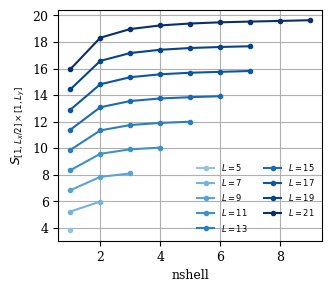

In [32]:
fig,ax=plt.subplots(figsize=(3.4,3))
color_list = iter(plt.cm.Blues(np.linspace(0.4,1,len(L_list))))
for L in L_list:
    data = np.array([(n,torch.tensor(rs_crit[(L,n)]['EE']).mean(axis=0)[-1].item()) for n in range(1,(L-1)//2) if (L,n) in rs_crit.keys()])
    ax.plot(data[:,0],data[:,1],'.-',label=f'$L={L}$',color=next(color_list))
ax.legend(ncols=2,frameon=False,fontsize=6)
ax.grid()

ax.set_xlabel('nshell')
ax.set_ylabel(r'$S_{[1,L_x/2]\times [1,L_y]}$')

# ax.set_xlim(None,8)

# fig.savefig('../Rp_SPTD/Fig/EE_nshell_mu2.pdf',bbox_inches='tight')


In [41]:
n=2
data = np.array([(L,torch.tensor(rs_crit[(L,n)]['Chern']).mean(axis=0)[-1].item()) for L in L_list if (L,n) in rs_crit.keys()])

In [46]:
np.linspace(1.1,1.5,5)

array([1.1, 1.2, 1.3, 1.4, 1.5])

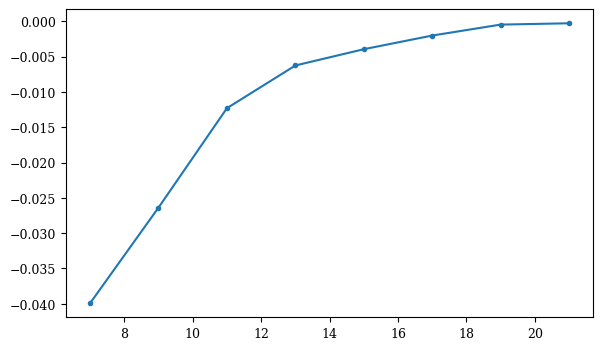

In [44]:
fig,ax=plt.subplots()
ax.plot(data[:,0],data[:,1],'.-')


In [36]:
data

array([[ 7.        ,  5.98673024],
       [ 9.        ,  7.8458838 ],
       [11.        ,  9.57942035],
       [13.        , 11.34058696],
       [15.        , 13.08554987],
       [17.        , 14.81601166],
       [19.        , 16.57509662],
       [21.        , 18.31984689]])

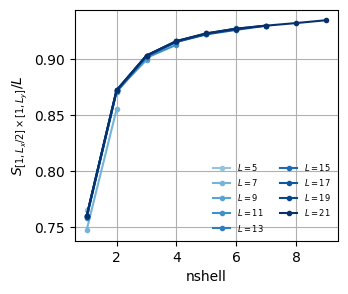

In [183]:
# fig,ax=plt.subplots()
fig,ax=plt.subplots(figsize=(3.4,3))
color_list = iter(plt.cm.Blues(np.linspace(0.4,1,len(L_list))))

for L in L_list:
    data = np.array([(n,torch.tensor(rs_crit[(L,n)]['EE']).mean(axis=0)[-1].item()) for n in range(1,(L-1)//2) if (L,n) in rs_crit.keys()])
    ax.plot(data[:,0],data[:,1]/L,'.-',label=f'$L={L}$',color=next(color_list))
ax.legend(ncols=2,frameon=False,fontsize=6)


ax.set_xlabel('nshell')
ax.set_ylabel(r'$S_{[1,L_x/2]\times [1,L_y]}/L$')
ax.grid()

fig.savefig('../Rp_SPTD/Fig/EE_L_nshell_mu2.pdf',bbox_inches='tight')


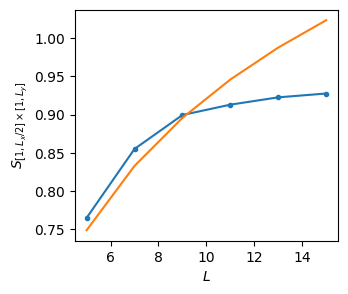

In [116]:
fig,ax=plt.subplots(figsize=(3.4,3))
data=[(L,torch.tensor(rs_crit[(L,(L-1)//2-1)]['EE']).mean(axis=0)[-1].item()/L) for L in L_list if (L,(L-1)//2-1) in rs_crit.keys()]
ax.plot((np.array(data)[:,0]),np.array(data)[:,1],'.-')
ax.set_ylabel(r'$S_{[1,L_x/2]\times [1,L_y]}$')
ax.set_xlabel('$L$')
# ax.set_xscale('log')

ax.plot(np.array(data)[:,0],0.25*np.log(4*np.array(data)[:,0]))

5 1
7 2
9 3
11 4
13 5
15 6
17 7
19 8
21 9


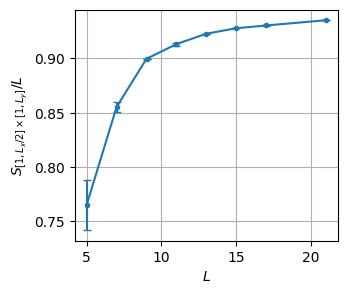

In [165]:
fig,ax=plt.subplots(figsize=(3.4,3))
x_list,mean_list,sem_list = get_mean_std(rs_crit,L_list)
ax.errorbar(x_list,mean_list/x_list,yerr=sem_list/x_list,fmt='.-',capsize=3)

ax.set_xlabel('$L$')
ax.set_ylabel(r'$S_{[1,L_x/2]\times [1,L_y]}/L$')
ax.grid()
fig.savefig('../Rp_SPTD/Fig/EE_L_nshell_max_mu2.pdf',bbox_inches='tight')

5 1
7 2
9 3
11 4
13 5
15 6
17 7
19 8
21 9


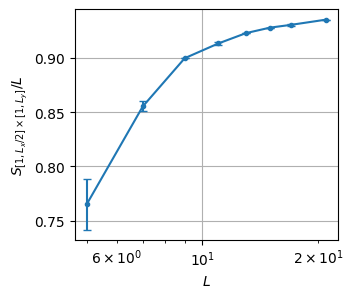

In [166]:
fig,ax=plt.subplots(figsize=(3.4,3))
x_list,mean_list,sem_list = get_mean_std(rs_crit,L_list)
ax.errorbar((x_list),mean_list/x_list,yerr=sem_list/x_list,fmt='.-',capsize=3)

ax.set_xlabel('$L$')
ax.set_ylabel(r'$S_{[1,L_x/2]\times [1,L_y]}/L$')
ax.set_xscale('log')
ax.grid()

fig.savefig('../Rp_SPTD/Fig/EE_L_nshell_max_mu2_log.pdf',bbox_inches='tight')

## Topological

In [169]:
rs_topo ={}
L_list = range(5,17,2)
mu_list = [1.]
for mu in mu_list:
    for L in L_list:
        nshell_list = range(1,(L-1)//2)
        for nshell in nshell_list:
            try:
                rs_topo[(L,nshell)] = torch.load(f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_es10.pt', map_location='cpu')
            except:
                pass


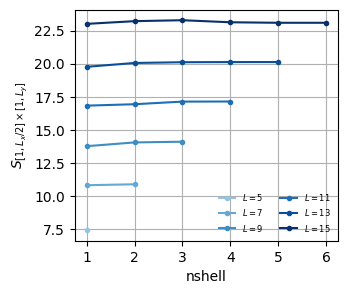

In [170]:
fig,ax=plt.subplots(figsize=(3.4,3))
color_list = iter(plt.cm.Blues(np.linspace(0.4,1,len(L_list))))
for L in L_list:
    data = np.array([(n,torch.tensor(rs_topo[(L,n)]['EE']).mean(axis=0)[-1].item()) for n in range(1,(L-1)//2) if (L,n) in rs_topo.keys()])
    ax.plot(data[:,0],data[:,1],'.-',label=f'$L={L}$',color=next(color_list))
ax.legend(ncols=2,frameon=False,fontsize=6)
ax.grid()

ax.set_xlabel('nshell')
ax.set_ylabel(r'$S_{[1,L_x/2]\times [1,L_y]}$')

# ax.set_xlim(None,8)
fig.savefig('../Rp_SPTD/Fig/EE_nshell_mu1.pdf',bbox_inches='tight')


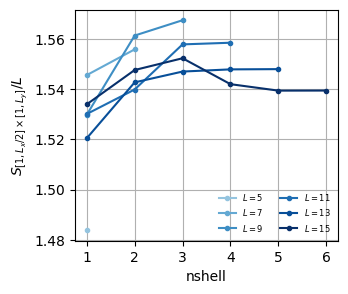

In [171]:
# fig,ax=plt.subplots()
fig,ax=plt.subplots(figsize=(3.4,3))
color_list = iter(plt.cm.Blues(np.linspace(0.4,1,len(L_list))))

for L in L_list:
    data = np.array([(n,torch.tensor(rs_topo[(L,n)]['EE']).mean(axis=0)[-1].item()) for n in range(1,(L-1)//2) if (L,n) in rs_topo.keys()])
    ax.plot(data[:,0],data[:,1]/L,'.-',label=f'$L={L}$',color=next(color_list))
ax.legend(ncols=2,frameon=False,fontsize=6)


ax.set_xlabel('nshell')
ax.set_ylabel(r'$S_{[1,L_x/2]\times [1,L_y]}/L$')
ax.grid()

fig.savefig('../Rp_SPTD/Fig/EE_L_nshell_mu1.pdf',bbox_inches='tight')


5 1
7 2
9 3
11 4
13 5
15 6


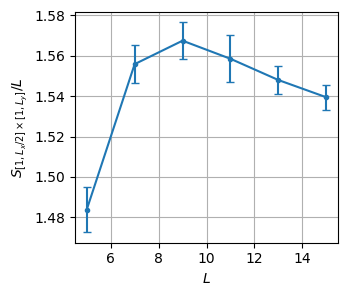

In [172]:
fig,ax=plt.subplots(figsize=(3.4,3))
x_list,mean_list,sem_list = get_mean_std(rs_topo,L_list)
ax.errorbar(x_list,mean_list/x_list,yerr=sem_list/x_list,fmt='.-',capsize=3)

ax.set_xlabel('$L$')
ax.set_ylabel(r'$S_{[1,L_x/2]\times [1,L_y]}/L$')
ax.grid()
fig.savefig('../Rp_SPTD/Fig/EE_L_nshell_max_mu1.pdf',bbox_inches='tight')

##  Trivial

In [174]:
rs_trivial ={}
L_list = range(5,17,2)
mu_list = [3.]
for mu in mu_list:
    for L in L_list:
        nshell_list = range(1,(L-1)//2)
        for nshell in nshell_list:
            try:
                rs_trivial[(L,nshell)] = torch.load(f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_es10.pt', map_location='cpu')
            except:
                pass


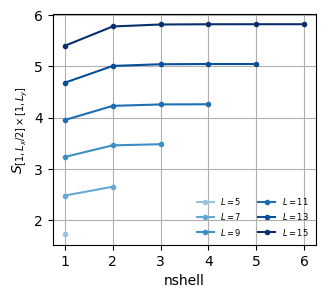

In [175]:
fig,ax=plt.subplots(figsize=(3.4,3))
color_list = iter(plt.cm.Blues(np.linspace(0.4,1,len(L_list))))
for L in L_list:
    data = np.array([(n,torch.tensor(rs_trivial[(L,n)]['EE']).mean(axis=0)[-1].item()) for n in range(1,(L-1)//2) if (L,n) in rs_trivial.keys()])
    ax.plot(data[:,0],data[:,1],'.-',label=f'$L={L}$',color=next(color_list))
ax.legend(ncols=2,frameon=False,fontsize=6)
ax.grid()

ax.set_xlabel('nshell')
ax.set_ylabel(r'$S_{[1,L_x/2]\times [1,L_y]}$')

# ax.set_xlim(None,8)
fig.savefig('../Rp_SPTD/Fig/EE_nshell_mu3.pdf',bbox_inches='tight')


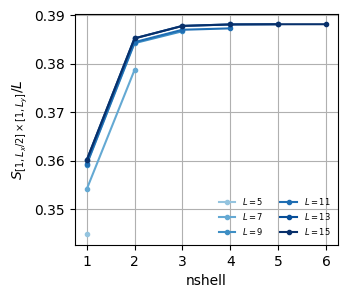

In [176]:
# fig,ax=plt.subplots()
fig,ax=plt.subplots(figsize=(3.4,3))
color_list = iter(plt.cm.Blues(np.linspace(0.4,1,len(L_list))))

for L in L_list:
    data = np.array([(n,torch.tensor(rs_trivial[(L,n)]['EE']).mean(axis=0)[-1].item()) for n in range(1,(L-1)//2) if (L,n) in rs_trivial.keys()])
    ax.plot(data[:,0],data[:,1]/L,'.-',label=f'$L={L}$',color=next(color_list))
ax.legend(ncols=2,frameon=False,fontsize=6)


ax.set_xlabel('nshell')
ax.set_ylabel(r'$S_{[1,L_x/2]\times [1,L_y]}/L$')
ax.grid()

fig.savefig('../Rp_SPTD/Fig/EE_L_nshell_mu3.pdf',bbox_inches='tight')


5 1
7 2
9 3
11 4
13 5
15 6


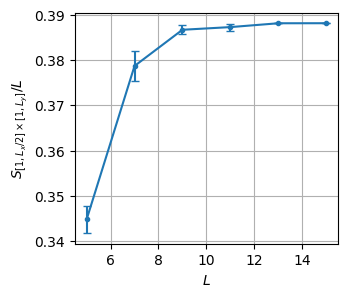

In [177]:
fig,ax=plt.subplots(figsize=(3.4,3))
x_list,mean_list,sem_list = get_mean_std(rs_trivial,L_list)
ax.errorbar(x_list,mean_list/x_list,yerr=sem_list/x_list,fmt='.-',capsize=3)

ax.set_xlabel('$L$')
ax.set_ylabel(r'$S_{[1,L_x/2]\times [1,L_y]}/L$')
ax.grid()
fig.savefig('../Rp_SPTD/Fig/EE_L_nshell_max_mu3.pdf',bbox_inches='tight')

5 1
7 2
9 3
11 4
13 5
15 6


<ErrorbarContainer object of 3 artists>

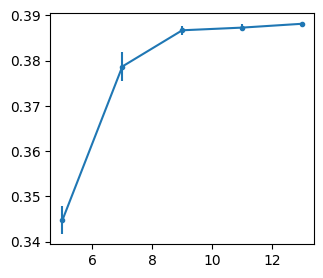

In [115]:
fig,ax=plt.subplots(figsize=(3.4,3))
x_list,mean_list,sem_list = get_mean_std(rs_trivial,L_list)
# ax.errorbar(x_list,mean_list,yerr=sem_list,fmt='.-')
ax.errorbar(x_list,mean_list/x_list,yerr=sem_list/x_list,fmt='.-')

Text(0.5, 0, '$L$')

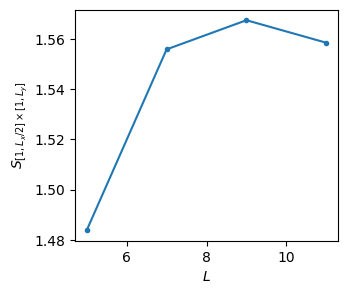

In [34]:
fig,ax=plt.subplots(figsize=(3.4,3))
data=[(L,torch.tensor(rs_topo[(L,(L-1)//2-1)]['EE']).mean(axis=0)[-1].item()/L) for L in L_list if (L,(L-1)//2-1) in rs_topo.keys()]


ax.plot(np.array(data)[:,0],np.array(data)[:,1],'.-')
ax.set_ylabel(r'$S_{[1,L_x/2]\times [1,L_y]}$')
ax.set_xlabel('$L$')

## As a function of mu

In [21]:
rs ={}
L_list = range(11,21,2)
# mu_list = np.round(np.linspace(1.1,1.5,11),2)
mu_list = np.round(np.linspace(1.1,2.1,11),2)
# nshell_list = [1,2,3]
nshell_list = [2,3,4]
for mu in mu_list:
    for L in L_list:
        for nshell in nshell_list:
            try:
                # rs[(L,nshell,mu)] = torch.load(f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_es20.pt', map_location='cpu')
                # rs[(L,nshell,mu)] = torch.load(f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_es200_seed00.pt', map_location='cpu')
                rs[(L,nshell,mu)] = torch.load(f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_es50_seed0_SE.pt', map_location='cpu')
            except:
                pass


/tmp/ipykernel_4142269/343890543.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_mean = [torch.tensor(rs[(L,nshell,mu)]['Chern']).mean() for mu in mu_list_1]
/tmp/ipykernel_4142269/343890543.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_std = [torch.tensor(rs[(L,nshell,mu)]['Chern']).std()/np.sqrt(len(rs[(L,nshell,mu)]['Chern'])) for mu in mu_list_1]


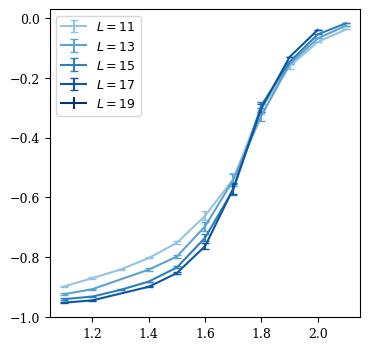

In [23]:
fig,ax=plt.subplots(figsize=(4,4))
L=11
nshell=4
color_list = iter(plt.cm.Blues(np.linspace(0.4,1,len(L_list))))
for L in L_list:
    mu_list_1 = [mu for mu in mu_list if (L,nshell,mu) in rs]
    data_mean = [torch.tensor(rs[(L,nshell,mu)]['Chern']).mean() for mu in mu_list_1]
    data_std = [torch.tensor(rs[(L,nshell,mu)]['Chern']).std()/np.sqrt(len(rs[(L,nshell,mu)]['Chern'])) for mu in mu_list_1]
    ax.errorbar(mu_list_1,data_mean,yerr=data_std,label=f'$L={L}$',capsize=3,color=next(color_list))
ax.legend()

In [ ]:
you can also try self average sytle

/tmp/ipykernel_3281644/1988052422.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_mean = [torch.tensor(rs[(L,nshell,mu)]['TMI']).mean() for mu in mu_list_1]
/tmp/ipykernel_3281644/1988052422.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_std = [torch.tensor(rs[(L,nshell,mu)]['TMI']).std()/np.sqrt(len(rs[(L,nshell,mu)]['Chern'])) for mu in mu_list_1]


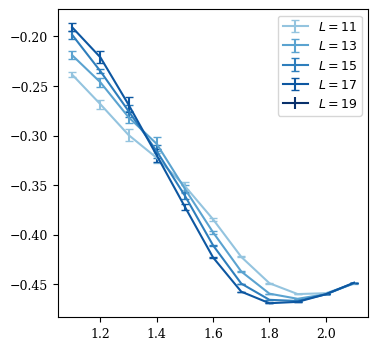

In [164]:
fig,ax=plt.subplots(figsize=(4,4))
# L=11
nshell=2
color_list = iter(plt.cm.Blues(np.linspace(0.4,1,len(L_list))))
for L in L_list:
    mu_list_1 = [mu for mu in mu_list if (L,nshell,mu) in rs]
    data_mean = [torch.tensor(rs[(L,nshell,mu)]['TMI']).mean() for mu in mu_list_1]
    data_std = [torch.tensor(rs[(L,nshell,mu)]['TMI']).std()/np.sqrt(len(rs[(L,nshell,mu)]['Chern'])) for mu in mu_list_1]
    ax.errorbar(mu_list_1,data_mean,yerr=data_std,label=f'$L={L}$',capsize=3,color=next(color_list))
ax.legend()

In [30]:
torch.tensor(rs[(L,nshell,mu)]['TMI'])

tensor([-0.2921, -0.2922, -0.2935, -0.1528, -0.2921, -0.2921, -0.2923, -0.2927,
        -0.2928, -0.2921, -0.2938, -0.2924, -0.2923, -0.2923, -0.2929, -0.2925,
        -0.2962, -0.2920, -0.2923, -0.1528], dtype=torch.float64)

In [ ]:
[rs[(L,nshell,mu)] for mu in mu_list]

In [ ]:
plt.plot(mu_list,nu_list[:,-1])
plt.plot(np.linspace(1,2.2,13),rs1_map[:,0,-1])

In [48]:
[(L,torch.tensor(rs_crit[(L,(L-1)//2)]['EE']).mean(axis=0)[-1].item()) for L in L_list]


KeyError: (15, 7)

In [13]:
torch.tensor(rs['Chern'])

tensor([[ 0.0000e+00, -8.3829e-48, -2.2224e-06, -2.8175e-05, -6.1616e-05,
         -6.1961e-05, -6.2142e-05, -6.2129e-05, -6.2167e-05, -6.2167e-05,
         -6.2167e-05, -6.2167e-05, -6.2261e-05, -6.2261e-05, -6.2261e-05,
         -6.2261e-05],
        [ 0.0000e+00, -8.3829e-48,  6.6527e-05, -5.3107e-05, -5.8126e-05,
         -6.0240e-05, -6.1726e-05, -6.2173e-05, -6.2179e-05, -6.2261e-05,
         -6.2261e-05, -6.2261e-05, -6.2261e-05, -6.2261e-05, -6.2261e-05,
         -6.2261e-05],
        [ 0.0000e+00, -8.3829e-48, -8.3573e-06, -1.7608e-04, -4.8789e-05,
         -5.6891e-05, -6.2099e-05, -6.2093e-05, -6.2167e-05, -6.2261e-05,
         -6.2261e-05, -6.2261e-05, -6.2261e-05, -6.2261e-05, -6.2261e-05,
         -6.2261e-05],
        [ 0.0000e+00, -8.3829e-48, -1.1284e-05, -3.3054e-05, -6.0105e-05,
         -6.1121e-05, -6.2093e-05, -6.2261e-05, -6.2261e-05, -6.2261e-05,
         -6.2261e-05, -6.2261e-05, -6.2261e-05, -6.2261e-05, -6.2261e-05,
         -6.2261e-05],
        [ 0.0000e+00

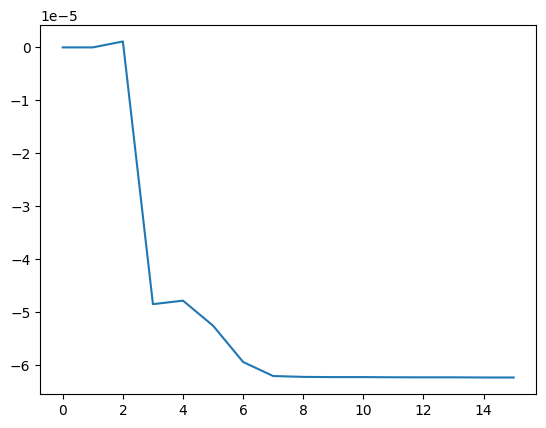

In [17]:
plt.plot(torch.tensor(rs['Chern']).mean(axis=0))

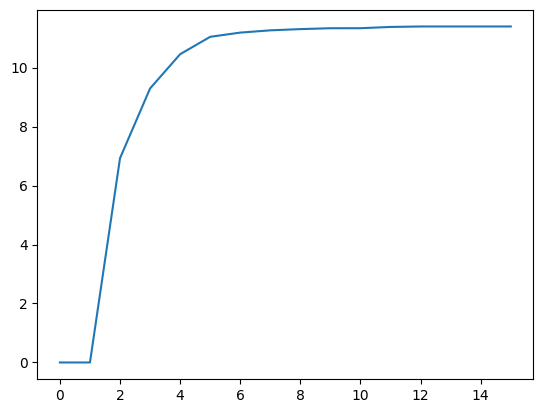

In [16]:
plt.plot(torch.tensor(rs['EE']).mean(axis=0))

In [55]:
rs['EC'][-1][0].sum(axis=1)[:10].sum()

tensor(0.5806, dtype=torch.float64)

In [ ]:
y=A/epoch + B

In [23]:
rs['EC'][-1][0].sum(axis=1)[17:].sum()

tensor(1.2411, dtype=torch.float64)

In [150]:
z0=gtn2_torch.C_m.cpu().clone()

In [153]:
measure_feedback_layer(gtn2_torch)

100%|██████████| 400/400 [00:04<00:00, 98.43it/s] 


In [159]:
%timeit measure_feedback_layer(gtn2_torch)

100%|██████████| 400/400 [00:02<00:00, 163.19it/s]

2.73 s ± 299 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit measure_feedback_layer(gtn2_torch)

100%|██████████| 400/400 [00:02<00:00, 180.89it/s]

2.38 s ± 155 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [154]:
z1=gtn2_torch.C_m.cpu().clone()

In [155]:
torch.allclose(z0,z1)

True

In [68]:
torch.allclose(z0,gtn2_torch.C_m.cpu())

True

In [16]:
torch.abs(torch.einsum(gtn2_torch.C_m,[0,1],gtn2_torch.C_m,[1,0],[0])+1).max()

tensor(2.3452e-06, device='cuda:0', dtype=torch.float64)

In [18]:
def purify(A):
    # purify A, see App. B2 in PhysRevB.106.134206
    U, _, Vh=torch.linalg.svd(A)
    return U@Vh

In [19]:
z=purify(gtn2_torch.C_m)

In [23]:
torch.abs(torch.einsum(z,[0,1],z,[1,0],[0])+1).max()

tensor(2.6246e-13, device='cuda:0', dtype=torch.float64)

In [24]:
gtn2_torch.C_m@gtn2_torch.C_m

tensor([[-1.0000e+00, -6.9959e-16, -2.4727e-09,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.4417e-16, -1.0000e+00,  3.8323e-09,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-2.4727e-09,  3.8323e-09, -1.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -1.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00, -1.0000e+00]], device='cuda:0', dtype=torch.float64)

In [34]:
torch.abs((z@z)+torch.eye(z.shape[0],device='cuda',dtype=torch.float64)).max()

tensor(2.6201e-13, device='cuda:0', dtype=torch.float64)

In [35]:
torch.allclose((z@z),-torch.eye(z.shape[0],device='cuda',dtype=torch.float64))

True

In [97]:
%timeit measure_feedback_layer(gtn2_torch,)

100%|██████████| 400/400 [00:02<00:00, 143.36it/s]

3.05 s ± 293 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [143]:
%timeit measure_feedback_layer(gtn2_torch,)

100%|██████████| 400/400 [00:01<00:00, 301.92it/s]

1.39 s ± 64.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [171]:
z=torch.tensor([1,2,4])

In [98]:
%lprun -f gtn2_torch.measure_single_mode_Born measure_feedback_layer(gtn2_torch,)

100%|██████████| 400/400 [00:02<00:00, 142.55it/s]


Timer unit: 1e-09 s

Total time: 2.23365 s
File: /home/hnpan/GTN/GTN2_torch.py
Function: measure_single_mode_Born at line 130

Line #      Hits         Time  Per Hit   % Time  Line Contents
   130                                               def measure_single_mode_Born(self,legs,mode):
   131                                                   """measure the single mode with mode = (wf, n), wavefunction and occupation number 
   132                                                   """
   133       800  806149221.0 1007686.5     36.1          legs=torch.tensor(legs,device=self.device)
   134       800   39828639.0  49785.8      1.8          Gamma = self.C_m[legs[:,None],legs[None,:]]
   135       800  219266636.0 274083.3      9.8          n = self.get_Born_single_mode(Gamma=Gamma,mode=mode,rng=self.rng)
   136       800 1168126765.0 1460158.5     52.3          self.measure_single_mode_force(kind=(mode,n),ix=legs)
   137       800     276761.0    346.0      0.0          return (mode,n)

In [20]:
%lprun -f purify measure_feedback_layer(gtn2_torch,)

100%|██████████| 100/100 [00:26<00:00,  3.83it/s]


Timer unit: 1e-09 s

Total time: 25.594 s
File: /home/hnpan/GTN/utils_torch.py
Function: purify at line 48

Line #      Hits         Time  Per Hit   % Time  Line Contents
    48                                           def purify(A):
    49       230 25588765805.0 111255503.5    100.0      U, _, Vh=torch.linalg.svd(A)
    50       230    5228016.0  22730.5      0.0      return U@Vh

In [21]:
111255503.5/1e6

111.2555035

In [ ]:
%lprun -f purify measure_feedback_layer(gtn2_torch,)

In [18]:
%timeit torch.linalg.svd(gtn2_torch.C_m,driver='gesvd')

74.5 ms ± 8.44 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit torch.linalg.eigh(gtn2_torch.C_m/1j)

In [23]:
torch.linalg.svd(gtn2_torch.C_m,driver='gesvd')

torch.return_types.linalg_svd(
U=tensor([[-2.5537e-04,  4.4020e-02, -5.4253e-03,  ...,  1.8833e-05,
         -5.1753e-02,  2.7000e-04],
        [ 7.7587e-03, -5.6294e-02, -7.2406e-02,  ...,  8.5907e-03,
         -4.6422e-02, -9.9476e-03],
        [-1.7822e-02,  1.4610e-03,  2.3213e-02,  ...,  4.8628e-02,
         -5.2428e-02, -8.7792e-03],
        ...,
        [-2.2226e-02,  5.6293e-02, -2.2022e-02,  ..., -4.8094e-02,
         -3.8499e-03, -4.5338e-03],
        [ 5.1551e-02,  2.3581e-02, -1.5027e-02,  ..., -5.0315e-03,
          1.4565e-02, -3.5377e-02],
        [ 2.4744e-02, -3.5089e-02, -1.8049e-02,  ..., -3.0509e-02,
         -8.0133e-02, -1.4957e-03]], device='cuda:0', dtype=torch.float64),
S=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000

In [28]:
z=gtn2_torch.C_m.cpu().numpy()

In [30]:
%timeit np.linalg.svd(z)

124 ms ± 813 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [31]:
%timeit np.linalg.eigh(z/1j)

126 ms ± 775 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%lprun -f gtn2_torch.measure_single_mode_force measure_feedback_layer(gtn2_torch,)

In [14]:
%lprun -f P_contraction_torch gtn2_torch.measure_feedback([0,1])

tensor(1.7881e-06, device='cuda:0')
tensor(2.0266e-06, device='cuda:0')
tensor(2.1458e-06, device='cuda:0')
tensor(2.4438e-06, device='cuda:0')


Timer unit: 1e-09 s

Total time: 0.527896 s
File: /home/hnpan/GTN/utils_torch.py
Function: P_contraction_torch at line 2

Line #      Hits         Time  Per Hit   % Time  Line Contents
     2                                           def P_contraction_torch(Gamma,Upsilon,ix,ix_bar,device,err,Gamma_like=None,reset_Gamma_like=True,):
     3                                               """ same analytical expression for contraction as _contraction(), differences:
     4                                               1. assume intput and output tensor have the same shape, thus, it should be Gamma(L,R) -- Upsilon (L,R), where Gamma_R = Upsilon_L =Upsilon_R, such that in-place operator is applied here.
     5                                               2. manually compute the inverse of mat2 before
     6                                               Here, Gamma is m, and proj is Upsilon
     7                                               Assume Upsilon = [A,B;C,D], the logic is to first 

In [11]:
%timeit gtn2_torch.measure_feedback([0,1])

24.4 ms ± 29.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
%timeit gtn2_torch.randomize([0,1])

74.2 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [136]:
%lprun -f gtn2_torch.measure gtn2_torch.randomize([0,1])

Timer unit: 1e-09 s

Total time: 0.00127411 s
File: /home/hnpan/GTN/GTN2_torch.py
Function: measure at line 181

Line #      Hits         Time  Per Hit   % Time  Line Contents
   181                                           
   182                                               def measure(self,n,ix):
   183                                                   ''' Majorana site index for ix, 
   184         1     315800.0 315800.0     24.8          n should be a scalar'''
   185         1      13756.0  13756.0      1.1          # ix_bar=torch.tensor(list(self.full_ix-set(ix)),device=self.device)
   186         1        361.0    361.0      0.0          self.ix_bool[ix]=True
   187         1     183645.0 183645.0     14.4          ix_bar = torch.nonzero(~self.ix_bool,as_tuple=True)[0]
   188         1     756443.0 756443.0     59.4          Psi=self.C_m
   189                                                   proj=self.kraus(n)
   190         1        852.0    852.0      0.1          P_cont

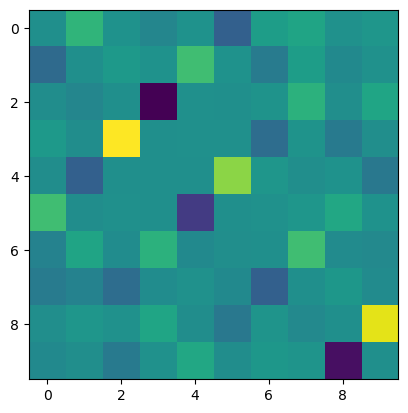

In [39]:
plt.imshow(gtn2_torch.C_m.cpu()[:10,:10])

In [8]:
device = torch.device("cuda")

In [10]:
# Ggpu=torch.from_numpy(Gamma).cuda()
op_gpu= torch.from_numpy(op).cuda()
ix_gpu = torch.from_numpy(np.array(ix)).cuda()
ix_bar_gpu = torch.from_numpy(np.array(ix_bar)).cuda()
err = torch.tensor(1e-10,device=device)

In [43]:
op

NameError: name 'op' is not defined

In [12]:
P_contraction_torch(gtn2_torch.C_m,op_gpu,ix_gpu,ix_bar_gpu,device=device,err=err)

In [ ]:
%lprun -f P_contraction_torch P_contraction_torch(Ggpu,op_gpu,ix_gpu,ix_bar_gpu,device=device,err=err)

In [17]:
%timeit P_contraction_torch(Ggpu,op_gpu,ix_gpu,ix_bar_gpu,device=device)

42.2 ms ± 5.03 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [143]:
%timeit P_contraction_torch(Ggpu,op_gpu,ix_gpu,ix_bar_gpu,device=device,err=err)

50.9 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [155]:
%timeit P_contraction_torch(Ggpu,op_gpu,ix_gpu,ix_bar_gpu,device=device,err=err)

12.4 ms ± 22.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [137]:
%timeit P_contraction_torch(Ggpu,op_gpu,ix_gpu,ix_bar_gpu,device=device,err=err)

51.3 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [156]:
Ggpu

tensor([[ 0.0000,  0.9600,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.9600,  0.0000,  0.0400,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0400,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000, -1.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  1.0000,  0.0000]],
       device='cuda:0', dtype=torch.float64)

In [188]:
Gz=purify(Ggpu)

In [190]:
torch.allclose(Gz,Ggpu)

True

In [187]:
%timeit purify(Ggpu)

1.38 s ± 2.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [160]:
val,vec=torch.linalg.eigh(Ggpu/1j)

In [177]:
U, S, Vh =torch.linalg.svd(Ggpu)

In [180]:
np.linalg.svd(np.array([[0,-1],[1,0]]))

(array([[ 0., -1.],
        [-1.,  0.]]),
 array([1., 1.]),
 array([[-1., -0.],
        [ 0.,  1.]]))

In [178]:
S

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0',
       dtype=torch.float64)

In [185]:
torch.allclose(U@Vh,Ggpu)

True

In [176]:
Vh

tensor([[ 8.8166e-03-0.0000j,  0.0000e+00-0.0170j, -2.5560e-01-0.0000j,
          ...,  0.0000e+00-0.0000j,  0.0000e+00-0.0000j,
          0.0000e+00-0.0000j],
        [ 1.7594e-02-0.0000j,  0.0000e+00+0.0041j, -9.5215e-01-0.0000j,
          ...,  0.0000e+00-0.0000j,  0.0000e+00-0.0000j,
          0.0000e+00-0.0000j],
        [-1.3285e-01-0.0000j,  0.0000e+00-0.0639j, -1.2723e-01-0.0000j,
          ...,  0.0000e+00-0.0000j,  0.0000e+00-0.0000j,
          0.0000e+00-0.0000j],
        ...,
        [-8.6209e-03-0.0000j,  0.0000e+00-0.0356j, -6.8445e-04-0.0000j,
          ...,  0.0000e+00-0.0000j,  0.0000e+00-0.0000j,
          0.0000e+00-0.0000j],
        [ 1.4508e-02-0.0000j,  0.0000e+00-0.0070j,  7.6398e-03-0.0000j,
          ...,  0.0000e+00-0.0000j,  0.0000e+00-0.0000j,
          0.0000e+00-0.0000j],
        [ 1.5218e-02-0.0000j,  0.0000e+00+0.0120j,  4.6112e-03-0.0000j,
          ...,  0.0000e+00-0.0000j,  0.0000e+00-0.0000j,
          0.0000e+00-0.0000j]], device='cuda:0', dtype=tor

In [168]:
vec@vec.T.conj()

tensor([[ 1.0000e+00+0.0000e+00j, -1.0971e-16+4.8945e-17j,
          3.7673e-17-6.0546e-19j,  ...,
          0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j],
        [-1.0971e-16-4.8945e-17j,  1.0000e+00+1.8705e-21j,
          7.1700e-19-5.6463e-17j,  ...,
          0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j],
        [ 3.7673e-17+6.0546e-19j,  7.1700e-19+4.9596e-17j,
          1.0000e+00-1.1297e-18j,  ...,
          0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j],
        ...,
        [ 0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j,  ...,
          1.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j],
        [ 0.0000e+00+0.0000e+00j,  0.0000e+00+0.0000e+00j,
          0.0000e+00+0.0000e+00j,  ...,
          0.0000e+00+0.0000e+00j,  1.0000e+00+0.0000e+00j,
          0.0000e+00+2.2371e-17j],
        [ 0.0000e+00+0

In [167]:
vec@torch.diag(val)

RuntimeError: expected scalar type ComplexDouble but found Double

In [165]:
vec@torch.diag(val)
# @vec.conj().T

RuntimeError: expected scalar type ComplexDouble but found Double

In [97]:
gtn2.C_m

array([[-1.41370405e-19,  9.14121153e-03,  8.43629885e-04, ...,
         5.45335233e-03,  9.16385308e-03, -4.98478879e-03],
       [-9.14121153e-03,  1.41370405e-19,  1.08348735e-02, ...,
        -8.01868528e-03,  9.43240753e-03, -2.38126923e-02],
       [-8.43629885e-04, -1.08348735e-02,  0.00000000e+00, ...,
         7.01912681e-04,  1.27848725e-02,  2.29915716e-04],
       ...,
       [-5.45335233e-03,  8.01868528e-03, -7.01912681e-04, ...,
         0.00000000e+00,  2.33343122e-02,  1.55717965e-02],
       [-9.16385308e-03, -9.43240753e-03, -1.27848725e-02, ...,
        -2.33343122e-02,  0.00000000e+00,  1.46735660e-02],
       [ 4.98478879e-03,  2.38126923e-02, -2.29915716e-04, ...,
        -1.55717965e-02, -1.46735660e-02,  0.00000000e+00]])

In [127]:
np.allclose(gtn2.C_m,Ggpu.cpu())

True

In [192]:
torch.tensor([[0,1.],[-1.,0]],device=device)

tensor([[ 0.,  1.],
        [-1.,  0.]], device='cuda:0')

In [197]:
device

device(type='cuda')

In [14]:
rng=torch.Generator(device=device)

In [207]:
rng.manual_seed(0)

In [16]:
# torch.normal(0,1,(10,10),generator=rng,device=device)
torch.rand(size=(10, ), generator=rng, device='cuda', dtype=torch.float32)

tensor([0.1452, 0.5480, 0.7146, 0.9941, 0.6706, 0.4023, 0.4849, 0.4496, 0.3975,
        0.3477], device='cuda:0')

In [223]:
torch.vstack([torch.arange(10),torch.arange(10)]).T

tensor([[0, 0],
        [1, 1],
        [2, 2],
        [3, 3],
        [4, 4],
        [5, 5],
        [6, 6],
        [7, 7],
        [8, 8],
        [9, 9]])

In [184]:
def P_contraction_torch(Gamma,Upsilon,ix,ix_bar,device,err,Gamma_like=None,reset_Gamma_like=True,):
    """ same analytical expression for contraction as _contraction(), differences:
    1. assume intput and output tensor have the same shape, thus, it should be Gamma(L,R) -- Upsilon (L,R), where Gamma_R = Upsilon_L =Upsilon_R, such that in-place operator is applied here.
    2. manually compute the inverse of mat2 before
    Here, Gamma is m, and proj is Upsilon
    Assume Upsilon = [A,B;C,D], the logic is to first compute C= (1+ Gamma_RR @ Upsilon_LL)^{-1}, (where then B=-C.T) 
    then A= Upsilon_LL @C, D= Gamma_RR@ C.T
    ---
    reset_Gamma_like: in usual case, because each application of the gate will be like the brick layer, therefore, ix_bar will overwrite the previous. However, for the staircase pattern, one should reset it. 
    """
    Gamma_RR=Gamma[ix[:,None],ix[None,:]]
    Gamma_LR=Gamma[ix_bar[:,None],ix[None,:]]
    Upsilon_LL=Upsilon[:len(ix),:len(ix)]
    Upsilon_RR=Upsilon[len(ix):,len(ix):]
    Upsilon_RL=Upsilon[len(ix):,:len(ix)]
    eye=torch.eye(len(ix),device=device)
    try: 
        C=torch.linalg.inv(Gamma_RR@Upsilon_LL+eye)
        # lu,pivots=torch.linalg.lu_factor(Gamma_RR@Upsilon_LL+eye)
    except:
        raise ValueError("the contraction will lead to a vanishing state")
    A=Upsilon_LL@C
    D=Gamma_RR@C.T
    # A= torch.linalg.lu_solve(lu,pivots,Upsilon_LL,left=False)
    # D= torch.linalg.lu_solve(lu,pivots,Gamma_RR.T).T
    tmp=Gamma_LR@A@Gamma_LR.T
    if Gamma_like is None:
        Gamma_like=torch.zeros_like(Gamma)
    if reset_Gamma_like:
        Gamma_like.fill_(0)
    Gamma_like[ix_bar[:,None],ix_bar[None,:]]=tmp
    Gamma+=Gamma_like
    Gamma[ix[:,None],ix_bar[None,:]]=Upsilon_RL@C@Gamma_LR.T
    # Gamma[ix[:,None],ix_bar[None,:]]=torch.linalg.lu_solve(lu,pivots,Upsilon_RL,left=False)@Gamma_LR.T
    Gamma[ix[:,None],ix[None,:]]=Upsilon_RR+Upsilon_RL@D@Upsilon_RL.T
    Gamma[ix_bar[:,None],ix[None,:]]=-Gamma[ix[:,None],ix_bar[None,:]].T
    # why is it neccessary?
    # Gamma-=Gamma.T
    # Gamma/=2

    if torch.abs(torch.einsum(Gamma,[0,1],Gamma,[1,0],[0])+1).max() > err:
        Gamma=purify(Gamma)
        Gamma-=Gamma.T
        Gamma/=2


def purify(A):
    # purify A, see App. B2 in PhysRevB.106.134206
    U, _, Vh=torch.linalg.svd(A)
    return U@Vh

In [145]:
Ggpu

tensor([[ 0.0000,  0.9600,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.9600,  0.0000,  0.0400,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0400,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000, -1.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  1.0000,  0.0000]],
       device='cuda:0', dtype=torch.float64)

In [147]:
Ggpu.shape

torch.Size([7200, 7200])

# Draft

In [ ]:
# parser=argparse.ArgumentParser()


# parser.add_argument('--L','-L',type=int)
# parser.add_argument('--nshell','-nshell',type=int)
# parser.add_argument('--mu','-mu',type=float)
# parser.add_argument('--es','-es',type=int,default=10)
# parser.add_argument('--seed0','-seed0',type=int,default=0)

# args=parser.parse_args()

In [6]:
import argparse
import os
import numpy as np
import torch

In [14]:
# rs ={}
L_list = range(11,21,2)
# mu_list = np.round(np.linspace(1.1,1.5,11),2)
mu_list = np.round(np.linspace(1.1,2.1,21),2)
nshell_list = [2,3,4,5]
# nshell_list = [5]
fn_list = os.listdir()
sigma=0
for mu in mu_list:
    for L in L_list:
        for nshell in nshell_list:
            # try:
            fn=f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_es50_seed0_SE.pt'
            fn_new=f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_sigma{sigma:.3f}_es50_seed0_SE.pt'
            if fn in fn_list:
                print(f"rename {fn} to {fn_new}")
                rs = torch.load(fn, map_location='cpu')
                rs['args'] = argparse.Namespace(L=L, nshell=nshell,mu=mu,es=50,seed0=0, sigma=sigma)
                torch.save(rs,fn_new)
                os.remove(fn)

            # except:
            #     pass


rename class_A_2D_L11_nshell2_mu1.10_es50_seed0_SE.pt to class_A_2D_L11_nshell2_mu1.10_sigma0.000_es50_seed0_SE.pt
rename class_A_2D_L11_nshell3_mu1.10_es50_seed0_SE.pt to class_A_2D_L11_nshell3_mu1.10_sigma0.000_es50_seed0_SE.pt
rename class_A_2D_L11_nshell4_mu1.10_es50_seed0_SE.pt to class_A_2D_L11_nshell4_mu1.10_sigma0.000_es50_seed0_SE.pt
rename class_A_2D_L11_nshell5_mu1.10_es50_seed0_SE.pt to class_A_2D_L11_nshell5_mu1.10_sigma0.000_es50_seed0_SE.pt
rename class_A_2D_L13_nshell2_mu1.10_es50_seed0_SE.pt to class_A_2D_L13_nshell2_mu1.10_sigma0.000_es50_seed0_SE.pt
rename class_A_2D_L13_nshell3_mu1.10_es50_seed0_SE.pt to class_A_2D_L13_nshell3_mu1.10_sigma0.000_es50_seed0_SE.pt
rename class_A_2D_L13_nshell4_mu1.10_es50_seed0_SE.pt to class_A_2D_L13_nshell4_mu1.10_sigma0.000_es50_seed0_SE.pt
rename class_A_2D_L15_nshell2_mu1.10_es50_seed0_SE.pt to class_A_2D_L15_nshell2_mu1.10_sigma0.000_es50_seed0_SE.pt
rename class_A_2D_L15_nshell3_mu1.10_es50_seed0_SE.pt to class_A_2D_L15_nshell3_

In [45]:
# rs ={}
L_list = range(11,21,2)
# mu_list = np.round(np.linspace(1.1,1.5,11),2)
# mu_list = np.round(np.linspace(1.1,2.1,21),2)
mu_list=[1]
nshell_list = [2,]
# nshell_list = [5]
fn_list = os.listdir()
sigma_list=np.linspace(0,1,21)
for mu in mu_list:
    for L in L_list:
        for nshell in nshell_list:
            for sigma in sigma_list:
                # try:
                fn_old=f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_sigma{sigma:.3f}_es300_seed50_SE.pt'
                fn_new=f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_sigma{sigma:.3f}_es300_seed0_SE.pt'
                if fn_old in fn_list:
                    print(f"rename {fn_old} {fn_new}")
                    os.rename(fn_old,fn_new)
                    # rs_0 = torch.load(fn_0, map_location='cpu')
                    # rs_1 = torch.load(fn_1, map_location='cpu')
                    # rs_new = {}
                    # rs_new['Chern']=torch.cat([rs_0['Chern'],rs_1['Chern']])
                    # rs_new['TMI']=torch.cat([rs_0['TMI'],rs_1['TMI']])
                    # rs_new['args'] = argparse.Namespace(L=L, nshell=nshell,mu=mu,es=300,seed0=0, sigma=sigma)
                    # torch.save(rs_new,fn_new)
                    # os.remove(fn_0)
                    # os.remove(fn_1)

                # except:
                #     pass


rename class_A_2D_L15_nshell2_mu1.00_sigma0.750_es300_seed50_SE.pt class_A_2D_L15_nshell2_mu1.00_sigma0.750_es300_seed0_SE.pt
rename class_A_2D_L15_nshell2_mu1.00_sigma0.850_es300_seed50_SE.pt class_A_2D_L15_nshell2_mu1.00_sigma0.850_es300_seed0_SE.pt
rename class_A_2D_L17_nshell2_mu1.00_sigma0.000_es300_seed50_SE.pt class_A_2D_L17_nshell2_mu1.00_sigma0.000_es300_seed0_SE.pt
rename class_A_2D_L17_nshell2_mu1.00_sigma0.150_es300_seed50_SE.pt class_A_2D_L17_nshell2_mu1.00_sigma0.150_es300_seed0_SE.pt
rename class_A_2D_L17_nshell2_mu1.00_sigma0.200_es300_seed50_SE.pt class_A_2D_L17_nshell2_mu1.00_sigma0.200_es300_seed0_SE.pt
rename class_A_2D_L17_nshell2_mu1.00_sigma0.400_es300_seed50_SE.pt class_A_2D_L17_nshell2_mu1.00_sigma0.400_es300_seed0_SE.pt
rename class_A_2D_L17_nshell2_mu1.00_sigma0.450_es300_seed50_SE.pt class_A_2D_L17_nshell2_mu1.00_sigma0.450_es300_seed0_SE.pt
rename class_A_2D_L17_nshell2_mu1.00_sigma0.500_es300_seed50_SE.pt class_A_2D_L17_nshell2_mu1.00_sigma0.500_es300_seed

In [13]:
rs['args']

Namespace(L=15, nshell=5, mu=2.1, es=50, seed0=0)

In [44]:
# rs ={}
L_list = range(11,21,2)
# mu_list = np.round(np.linspace(1.1,1.5,11),2)
# mu_list = np.round(np.linspace(1.1,2.1,21),2)
mu_list=[1]
nshell_list = [2,]
# nshell_list = [5]
fn_list = os.listdir()
sigma_list=np.linspace(0,1,21)
for mu in mu_list:
    for L in L_list:
        for nshell in nshell_list:
            for sigma in sigma_list:
                # try:
                fn_0=f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_sigma{sigma:.3f}_es50_seed0_SE.pt'
                fn_1=f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_sigma{sigma:.3f}_es250_seed50_SE.pt'
                fn_new=f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_sigma{sigma:.3f}_es300_seed0_SE.pt'
                if fn_0 not in fn_list and fn_1 in fn_list and fn_new not in fn_list:
                    # print(f"merge {fn_0}(missing) {fn_1} to {fn_new}")
                    print(f'{L} {mu:.2f} {nshell} {sigma:.3f}')
                    # rs_0 = torch.load(fn_0, map_location='cpu')
                    # rs_1 = torch.load(fn_1, map_location='cpu')
                    # rs_new = {}
                    # rs_new['Chern']=torch.cat([rs_0['Chern'],rs_1['Chern']])
                    # rs_new['TMI']=torch.cat([rs_0['TMI'],rs_1['TMI']])
                    # rs_new['args'] = argparse.Namespace(L=L, nshell=nshell,mu=mu,es=300,seed0=0, sigma=sigma)
                    # torch.save(rs_new,fn_new)
                    # os.remove(fn_0)
                    # os.remove(fn_1)

                # except:
                #     pass


In [42]:
# rs ={}
L_list = range(11,21,2)
# mu_list = np.round(np.linspace(1.1,1.5,11),2)
# mu_list = np.round(np.linspace(1.1,2.1,21),2)
mu_list=[1]
nshell_list = [2,]
# nshell_list = [5]
fn_list = os.listdir()
sigma_list=np.linspace(0,1,21)
for mu in mu_list:
    for L in L_list:
        for nshell in nshell_list:
            for sigma in sigma_list:
                # try:
                fn_0=f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_sigma{sigma:.3f}_es50_seed0_SE.pt'
                fn_1=f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_sigma{sigma:.3f}_es250_seed50_SE.pt'
                fn_new=f'class_A_2D_L{L}_nshell{nshell}_mu{mu:.2f}_sigma{sigma:.3f}_es300_seed0_SE.pt'
                if fn_0 in fn_list and fn_1 in fn_list:
                    print(f"merge {fn_0} {fn_1} to {fn_new}")
                    rs_0 = torch.load(fn_0, map_location='cpu')
                    rs_1 = torch.load(fn_1, map_location='cpu')
                    rs_new = {}
                    rs_new['Chern']=torch.cat([rs_0['Chern'],rs_1['Chern']])
                    rs_new['TMI']=torch.cat([rs_0['TMI'],rs_1['TMI']])
                    rs_new['args'] = argparse.Namespace(L=L, nshell=nshell,mu=mu,es=300,seed0=0, sigma=sigma)
                    torch.save(rs_new,fn_new)
                    os.remove(fn_0)
                    os.remove(fn_1)

                # except:
                #     pass


merge class_A_2D_L17_nshell2_mu1.00_sigma0.150_es50_seed0_SE.pt class_A_2D_L17_nshell2_mu1.00_sigma0.150_es250_seed50_SE.pt to class_A_2D_L17_nshell2_mu1.00_sigma0.150_es300_seed50_SE.pt
merge class_A_2D_L17_nshell2_mu1.00_sigma0.450_es50_seed0_SE.pt class_A_2D_L17_nshell2_mu1.00_sigma0.450_es250_seed50_SE.pt to class_A_2D_L17_nshell2_mu1.00_sigma0.450_es300_seed50_SE.pt
merge class_A_2D_L17_nshell2_mu1.00_sigma0.550_es50_seed0_SE.pt class_A_2D_L17_nshell2_mu1.00_sigma0.550_es250_seed50_SE.pt to class_A_2D_L17_nshell2_mu1.00_sigma0.550_es300_seed50_SE.pt
merge class_A_2D_L17_nshell2_mu1.00_sigma0.650_es50_seed0_SE.pt class_A_2D_L17_nshell2_mu1.00_sigma0.650_es250_seed50_SE.pt to class_A_2D_L17_nshell2_mu1.00_sigma0.650_es300_seed50_SE.pt
merge class_A_2D_L17_nshell2_mu1.00_sigma0.750_es50_seed0_SE.pt class_A_2D_L17_nshell2_mu1.00_sigma0.750_es250_seed50_SE.pt to class_A_2D_L17_nshell2_mu1.00_sigma0.750_es300_seed50_SE.pt
merge class_A_2D_L17_nshell2_mu1.00_sigma0.850_es50_seed0_SE.pt c

In [11]:
rs_0.keys()

dict_keys(['Chern', 'TMI', 'args'])

In [12]:
rs_1.keys()

dict_keys(['Chern', 'TMI', 'args'])

In [13]:
rs_0['Chern'].shape

torch.Size([50])

In [14]:
rs_1['Chern'].shape

torch.Size([250])

In [16]:
torch.cat([rs_0['Chern'],rs_1['Chern']]).shape

torch.Size([300])

In [17]:
torch.cat([rs_0['TMI'],rs_1['TMI']]).shape

torch.Size([300])